In [1]:
import sys
import os

# Absolute path to your module's directory
module_path = os.path.abspath('/localscratch/zippoema/git/HPA/src/')
if module_path not in sys.path:
    sys.path.insert(0, module_path)

import hpa.cluster as hpacl  # Now this should work
import hpa.util as hpau  # Now this should work

/localscratch/zippoema/lib/python_envs/hpa_env/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/localscratch/zippoema/lib/python_envs/hpa_env/lib/python3.11/site-packages/MDAnalysis/topology/TPRParser.py:160: DeprecationWarning: 'xdrlib' is deprecated and slated for removal in Python 3.13
  import xdrlib


In [2]:
import numpy as np
from matplotlib import pyplot as plt
import matplotlib.cm as cm
from tqdm import tqdm
import gsd.hoomd 

In [3]:
plt.style.use('default')
plt.style.use('/localscratch/zippoema/md_plots/rates_plot.mplstyle')

In [4]:
path_drop = '/localscratch/zippoema/project_ness/simulations/droplet_200-tdp43-lcd/'
path_slab = '/localscratch/zippoema/project_ness/simulations/slab_200-tdp43-lcd/'
path_bckp = '/localscratch/zippoema/zippo_phd_data_bckp/project_hps_phospho_tdp43_natcomm_bckp/'
path_drop_an = '/localscratch/zippoema/project_ness/analysis/droplet_200-tdp43-lcd/'
path_slab_an = '/localscratch/zippoema/project_ness/analysis/slab_200-tdp43-lcd/'
path_drop_pl = '/localscratch/zippoema/project_ness/plots/droplet_200-tdp43-lcd/'
path_slab_pl = '/localscratch/zippoema/project_ness/plots/slab_200-tdp43-lcd/'
path_dp = '/localscratch/zippoema/project_ness/simulations/condensate_dephospho/'
path_struct = '/localscratch/zippoema/project_ness/simulations/condensate_structure/'
path_struct_an = '/localscratch/zippoema/project_ness/analysis/condensate_structure/'
path_struct_pl = '/localscratch/zippoema/project_ness/plots/condensate_structure/'


In [32]:
def plot_radial_density_profiles_by_npSer(
    r_centers,
    density_profiles,
    chain_counts,
    select=None,
    groups=None,
    cmap="viridis",
    lw=2,
    per_chain=True,
    radial=False,
    logscale=False,
    save=None
):
    """
    Plot radial density profiles split or grouped by phosphorylation state.

    Parameters
    ----------
    r_centers : np.ndarray
        Radial bin centers.
    density_profiles : dict
        {n_pSer: density(r)}.
    chain_counts : dict
        {n_pSer: number of chains in that class}.
    select : list[int] or None
        Plot only specific phosphorylation states (ignored if groups is used).
    groups : dict or None
        Optional grouping rules:
            {label: function(n_pSer) -> bool}
        Example:
            groups = {
                "0–5 pSer": lambda x: 0 <= x <= 5,
                "6–15 pSer": lambda x: 6 <= x <= 15,
                ">15 pSer": lambda x: x > 15
            }
    cmap : str
        Colormap.
    lw : float
        Line width.
    per_chain : bool
        If True, normalize densities per chain.
    radial : bool
        If True, xaxis label is r
    logscale : bool
        If True, yscale is log.
    """

    # ---------- GROUPED MODE ----------
    if groups is not None:
        merged_profiles = {}
        labels = []

        for label, rule in groups.items():
            matching_classes = [c for c in density_profiles if rule(c)]
            if not matching_classes:
                continue

            total_chains = sum(chain_counts[c] for c in matching_classes)

            if per_chain:
                merged_density = sum(
                    density_profiles[c] for c in matching_classes
                ) / total_chains
            else:
                merged_density = sum(
                    density_profiles[c] for c in matching_classes
                )

            merged_profiles[label] = merged_density
            labels.append(label)

        colors = cm.get_cmap(cmap)(np.linspace(0, 1, len(labels)))

        plt.figure(figsize=(6, 4))
        for label, color in zip(labels, colors):
            plt.plot(r_centers, merged_profiles[label],
                     color=color, lw=lw, label=label)

        plt.legend(title="Phosphorylation groups", fontsize=8)

    # ---------- INDIVIDUAL CLASS MODE ----------
    else:
        classes = sorted(density_profiles.keys())
        if select is not None:
            classes = [c for c in classes if c in select]

        colors = cm.get_cmap(cmap)(np.linspace(0, 1, len(classes)))

        plt.figure(figsize=(6, 4))
        for c, color in zip(classes, colors):
            rho = density_profiles[c]
            if per_chain:
                rho = rho / chain_counts[c]

            plt.plot(r_centers, rho, color=color, lw=lw, label=f"{c} pSer")

        plt.legend(title="Phosphorylation", fontsize=9)

    if radial:
        plt.xlabel("r")
    else:
        plt.xlabel("z")
    plt.ylabel("Density per chain")
    if logscale:
        plt.yscale('log')
    plt.legend(title="Phosphorylation", fontsize=9)
    plt.tight_layout()
    if save is not None:
        plt.savefig(save+'.png', dpi=600)
        plt.savefig(save+'.pdf', dpi=600)
    else:
        plt.show()


In [47]:
step = 20
times = np.arange(step,5000+step,step, dtype=int)-1
len(times)

250

### Size of the cluster

In [49]:
nc_5ck1d, np_5ck1d = hpacl.chains_in_condensate(path_drop+'sim_200-tdp43-lcd_5-ck1d-open/',
                                                '200-tdp43-lcd_5-com-ck1d-open_CAL3_dump_centered.gsd', 
                                                4, times)

/localscratch/zippoema/lib/python_envs/hpa_env/lib/python3.11/site-packages/gsd/hoomd.py:1125: FutureWarning: The 'rb' mode is deprecated, use 'r'
  gsdfileobj = fl.open(name=str(name),


5000


100%|█████████████████████████████████████████████████████████████████| 250/250 [00:21<00:00, 11.55it/s]
/localscratch/zippoema/lib/python_envs/hpa_env/lib/python3.11/site-packages/gsd/hoomd.py:1125: FutureWarning: The 'rb' mode is deprecated, use 'r'
  gsdfileobj = fl.open(name=str(name),


5000


100%|█████████████████████████████████████████████████████████████████| 250/250 [00:21<00:00, 11.77it/s]
/localscratch/zippoema/lib/python_envs/hpa_env/lib/python3.11/site-packages/gsd/hoomd.py:1125: FutureWarning: The 'rb' mode is deprecated, use 'r'
  gsdfileobj = fl.open(name=str(name),


5000


100%|█████████████████████████████████████████████████████████████████| 250/250 [00:21<00:00, 11.75it/s]
/localscratch/zippoema/lib/python_envs/hpa_env/lib/python3.11/site-packages/gsd/hoomd.py:1125: FutureWarning: The 'rb' mode is deprecated, use 'r'
  gsdfileobj = fl.open(name=str(name),


5000


100%|█████████████████████████████████████████████████████████████████| 250/250 [00:21<00:00, 11.89it/s]


In [51]:
nc_5pp3, np_5pp3 = hpacl.chains_in_condensate(path_drop+'sim_200-tdp43-lcd_5-pp3/',
                                                '200-tdp43-lcd-2100pser_5-com-pp3_CAL3_dump_centered.gsd', 
                                                4, times)

/localscratch/zippoema/lib/python_envs/hpa_env/lib/python3.11/site-packages/gsd/hoomd.py:1125: FutureWarning: The 'rb' mode is deprecated, use 'r'
  gsdfileobj = fl.open(name=str(name),


5000


100%|█████████████████████████████████████████████████████████████████| 250/250 [00:28<00:00,  8.91it/s]
/localscratch/zippoema/lib/python_envs/hpa_env/lib/python3.11/site-packages/gsd/hoomd.py:1125: FutureWarning: The 'rb' mode is deprecated, use 'r'
  gsdfileobj = fl.open(name=str(name),


5000


100%|█████████████████████████████████████████████████████████████████| 250/250 [00:27<00:00,  9.14it/s]
/localscratch/zippoema/lib/python_envs/hpa_env/lib/python3.11/site-packages/gsd/hoomd.py:1125: FutureWarning: The 'rb' mode is deprecated, use 'r'
  gsdfileobj = fl.open(name=str(name),


5000


100%|█████████████████████████████████████████████████████████████████| 250/250 [00:28<00:00,  8.89it/s]
/localscratch/zippoema/lib/python_envs/hpa_env/lib/python3.11/site-packages/gsd/hoomd.py:1125: FutureWarning: The 'rb' mode is deprecated, use 'r'
  gsdfileobj = fl.open(name=str(name),


5000


100%|█████████████████████████████████████████████████████████████████| 250/250 [00:21<00:00, 11.50it/s]


In [12]:
nc_5ck1d_hps, np_5ck1d_hps = hpacl.chains_in_condensate(path_bckp+'multi-tdp43/simulations_folded-ck1d/sim_5-folded-ck1d/',
                                                '5-folded-ck1d_multi-tdp43_32b_dump_centered.gsd', 
                                                4, times[:-1])

/localscratch/zippoema/lib/python_envs/hpa_env/lib/python3.11/site-packages/gsd/hoomd.py:1125: FutureWarning: The 'rb' mode is deprecated, use 'r'
  gsdfileobj = fl.open(name=str(name),


2500


100%|█████████████████████████████████████████████████████████████████| 114/114 [00:25<00:00,  4.42it/s]
/localscratch/zippoema/lib/python_envs/hpa_env/lib/python3.11/site-packages/gsd/hoomd.py:1125: FutureWarning: The 'rb' mode is deprecated, use 'r'
  gsdfileobj = fl.open(name=str(name),


2500


100%|█████████████████████████████████████████████████████████████████| 114/114 [00:25<00:00,  4.47it/s]
/localscratch/zippoema/lib/python_envs/hpa_env/lib/python3.11/site-packages/gsd/hoomd.py:1125: FutureWarning: The 'rb' mode is deprecated, use 'r'
  gsdfileobj = fl.open(name=str(name),


2500


100%|█████████████████████████████████████████████████████████████████| 114/114 [00:25<00:00,  4.40it/s]
/localscratch/zippoema/lib/python_envs/hpa_env/lib/python3.11/site-packages/gsd/hoomd.py:1125: FutureWarning: The 'rb' mode is deprecated, use 'r'
  gsdfileobj = fl.open(name=str(name),


2500


100%|█████████████████████████████████████████████████████████████████| 114/114 [00:25<00:00,  4.55it/s]


In [50]:
np.savetxt(path_drop_an+'sim_200-tdp43-lcd_5-ck1d-open/size_cond_200-tdp43-lcd_5-com-ck1d-open_CAL3.txt', nc_5ck1d)
np.savetxt(path_drop_an+'sim_200-tdp43-lcd_5-ck1d-open/nphospho_200-tdp43-lcd_5-com-ck1d-open_CAL3.txt', np_5ck1d)

In [53]:
np.savetxt(path_drop_an+'sim_200-tdp43-lcd_5-pp3/size_cond_200-tdp43-lcd_5-com-pp3_CAL3.txt', nc_5pp3)
np.savetxt(path_drop_an+'sim_200-tdp43-lcd_5-pp3/nphospho_200-tdp43-lcd_5-com-pp3_CAL3.txt', np_5pp3)

In [13]:
np.savetxt(path_bckp+'multi-tdp43/simulations_folded-ck1d/sim_5-folded-ck1d/size_cond_5-folded-ck1d_multi-tdp43_32b.txt', nc_5ck1d_hps)
np.savetxt(path_bckp+'multi-tdp43/simulations_folded-ck1d/sim_5-folded-ck1d/nphospho_5-folded-ck1d_multi-tdp43_32b.txt', np_5ck1d_hps)

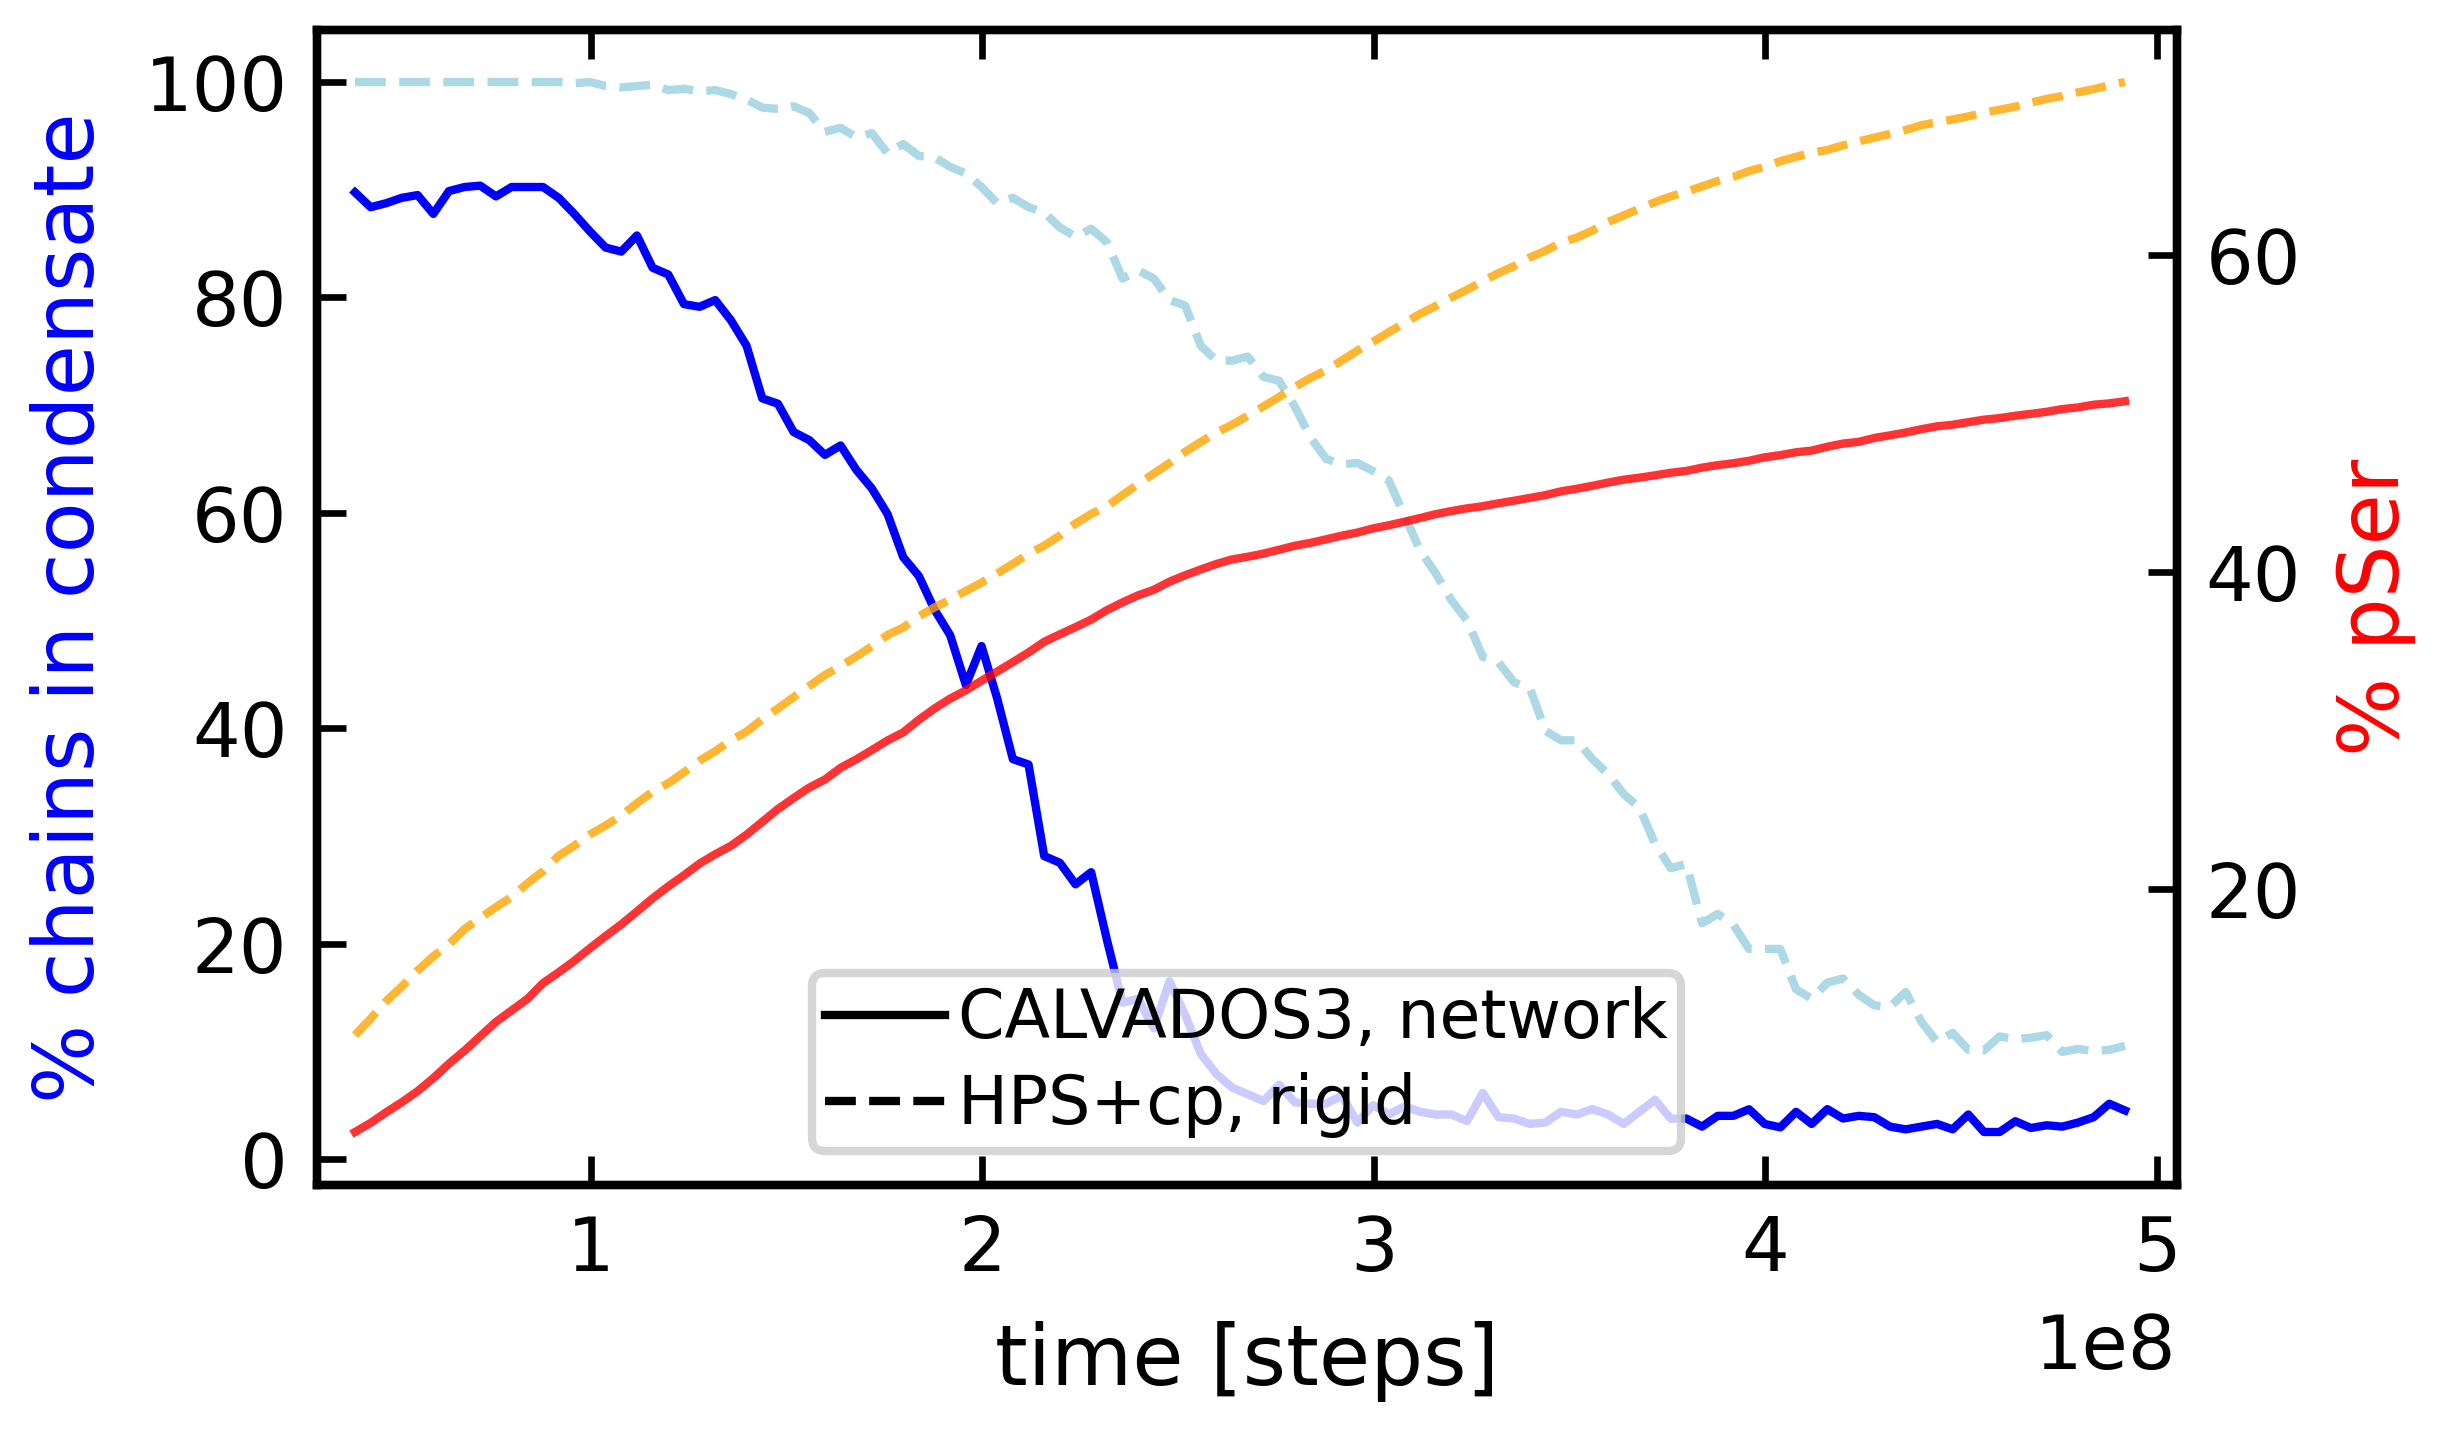

In [23]:
time_step = times*200000
#td_5 = np.where(nc_5ck1d/200 == 0.995)[0][0]

fig, ax1 = plt.subplots(figsize=(4, 2.5))

# Plot the first array with the primary y-axis
ax1.plot(time_step[:-1], nc_5ck1d/2, 'b-')
ax1.plot(time_step[:-1], nc_5ck1d_hps/2, '--', color='lightblue')
ax1.set_xlabel('time [steps]')
ax1.set_ylabel('% chains in condensate', color='b')
ax1.plot(time_step[0], nc_5ck1d[0]/2, 'k-', label=r'CALVADOS3, network')
ax1.plot(time_step[0], nc_5ck1d[0]/2, 'k--', label=r'HPS+cp, rigid')

#secax = ax1.secondary_xaxis('top')
#secax.set_xticks([ time_step[td_5]], ['$t^\mathrm{5CK1\delta}_\mathrm{diss}$'], fontsize='x-small' )
#secax.tick_params(direction='in', color='grey' , length=0)

#ax1.vlines([time_step[td_5]],ymin=-10,ymax=105, ls=['-.'] ,color='grey', linewidth=1, alpha=0.6)
#ax1.set_ylim((-10,105))

# Create a secondary y-axis and plot the second array
ax2 = ax1.twinx()
ax2.plot(time_step[:-1], np_5ck1d/48, 'r-', alpha=0.8)
ax2.plot(time_step[:-1], np_5ck1d_hps/48, '--', color='orange', alpha=0.8)
ax2.set_ylabel('% pSer', color='r')
#ax2.hlines([ np_5ck1d[td_5]],xmin=0.3*10**8,xmax=5.05*10**8, ls=['-.'], color='grey', linewidth=1, alpha=0.6)
ax2.set_xlim((0.3*10**8,5.05*10**8))

#ax2.plot([time_step[td_5]], [ np_5ck1d[td_5]], 'or', alpha=0.4, ms=5)

ax1.legend(ncols=1, loc='lower center')

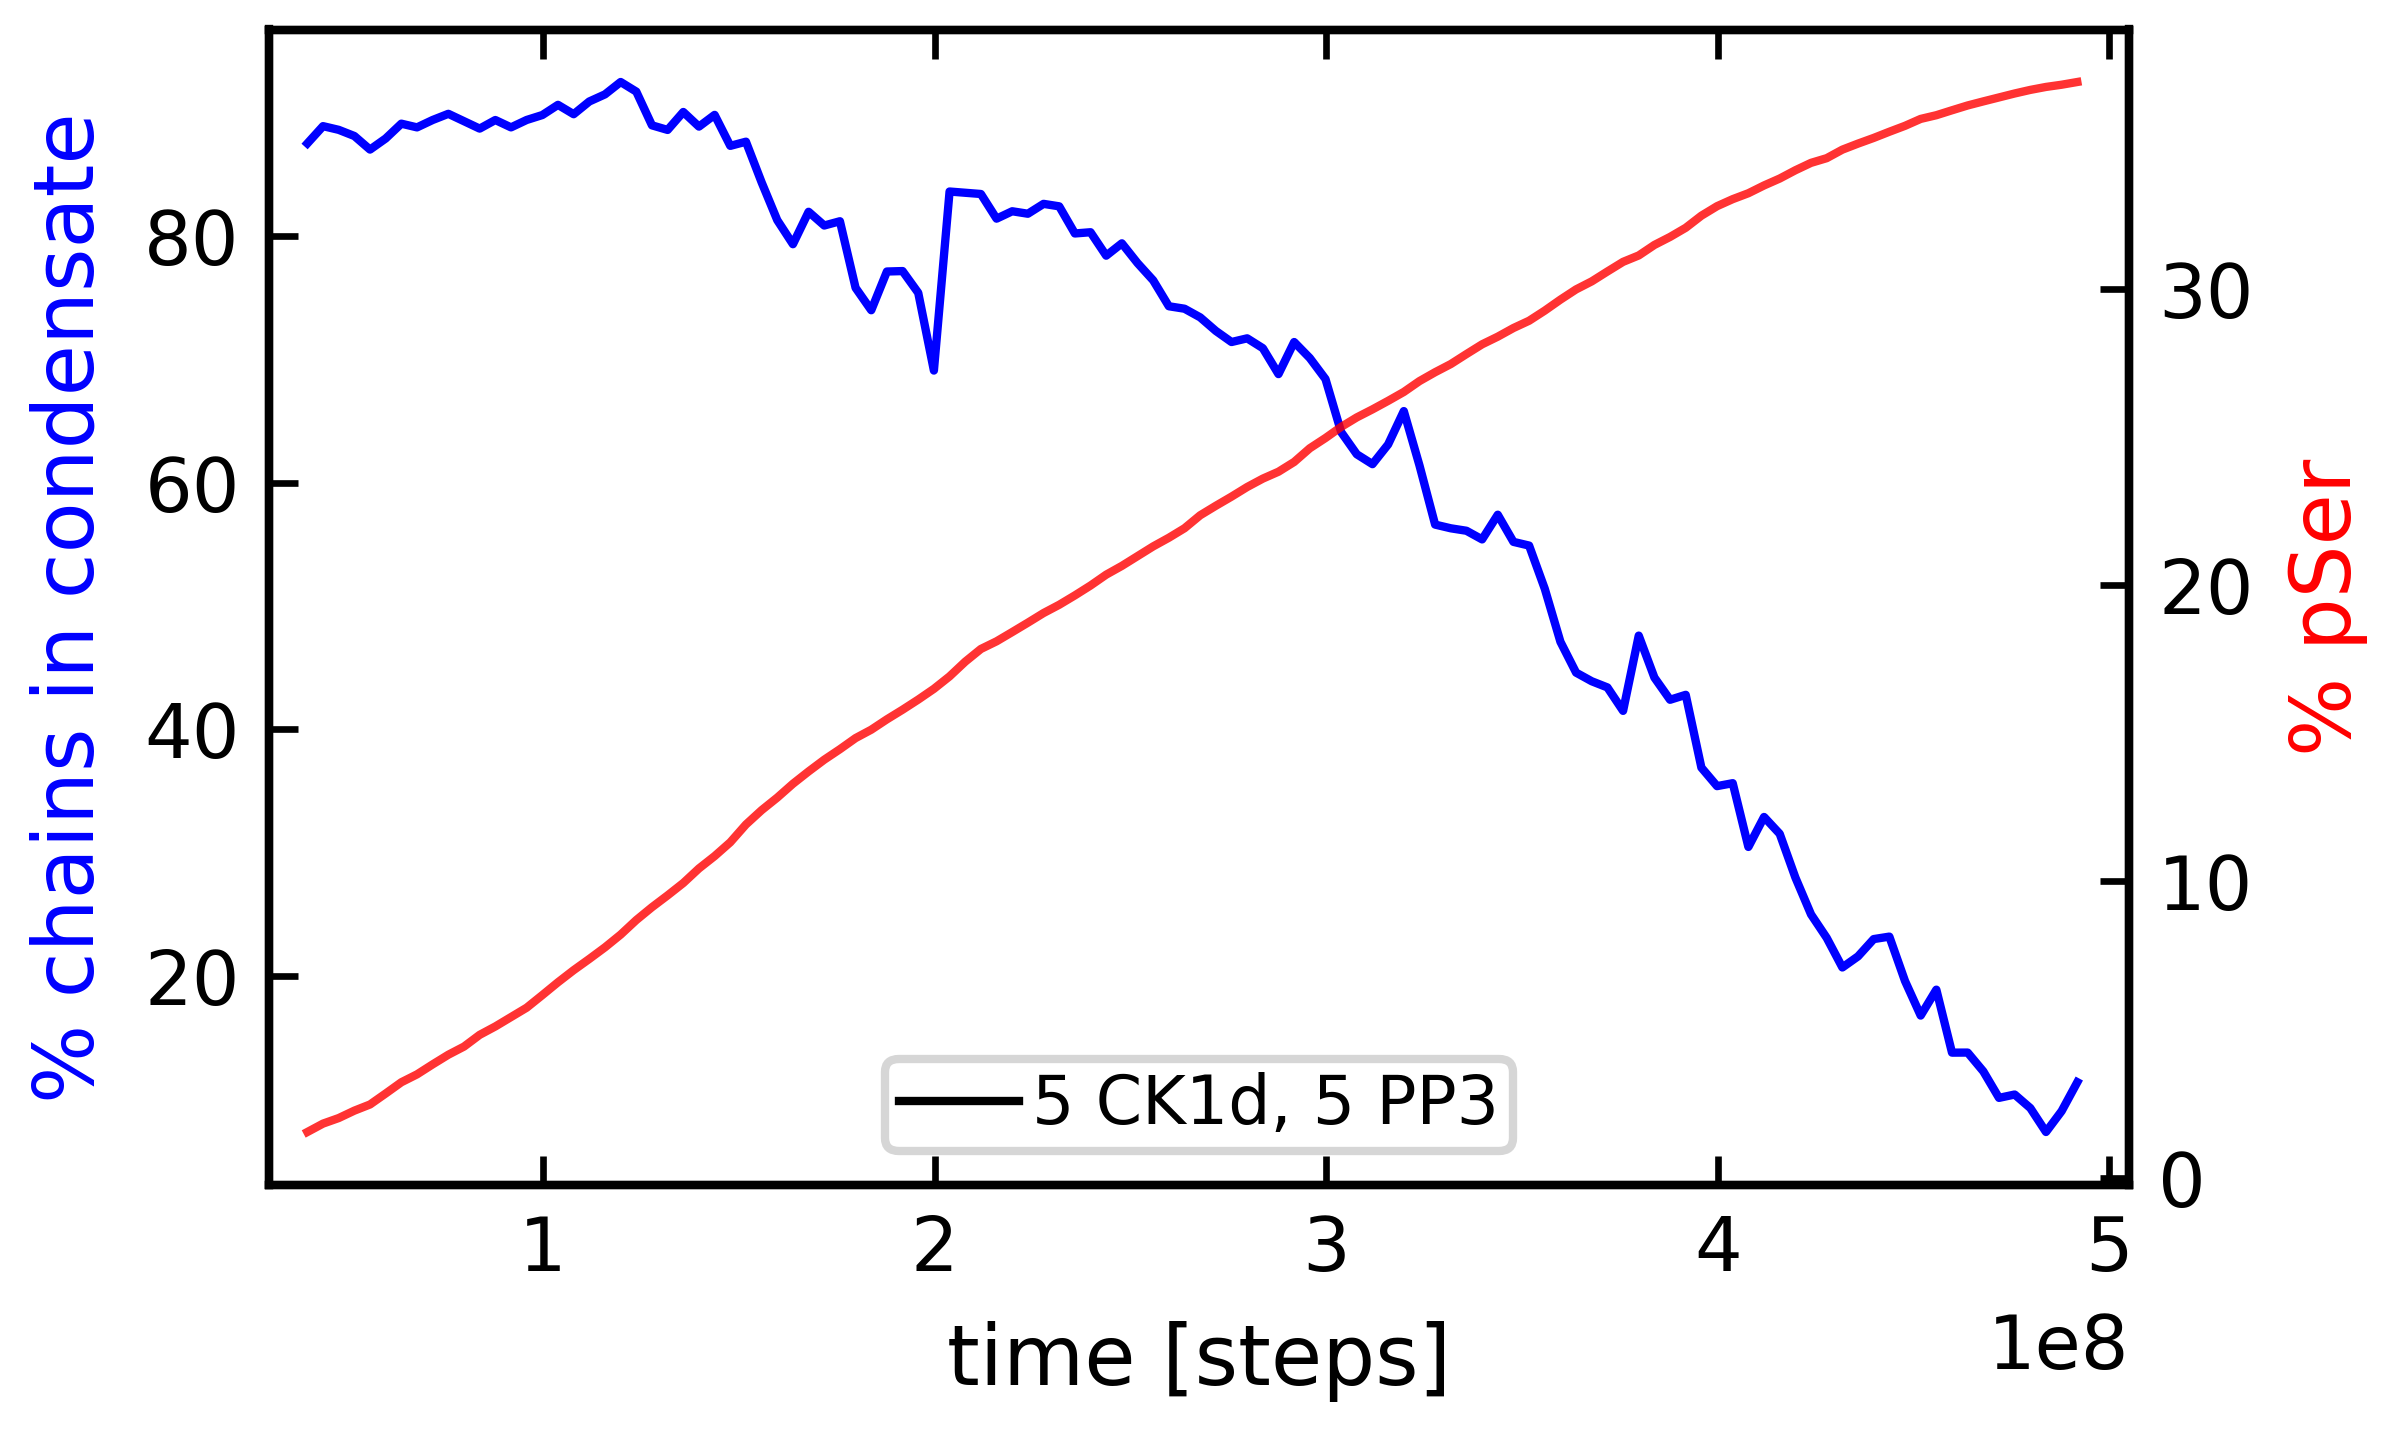

In [10]:
time_step = times*200000
#td_5 = np.where(nc_5ck1d/200 == 0.995)[0][0]

fig, ax1 = plt.subplots(figsize=(4, 2.5))

# Plot the first array with the primary y-axis
ax1.plot(time_step[:-1], nc_5ck1d_5pp3/2, 'b-')
ax1.set_xlabel('time [steps]')
ax1.set_ylabel('% chains in condensate', color='b')
ax1.plot(time_step[0], nc_5ck1d_5pp3[0]/2, 'k-', label=r'5 CK1d, 5 PP3')

#secax = ax1.secondary_xaxis('top')
#secax.set_xticks([ time_step[td_5]], ['$t^\mathrm{5CK1\delta}_\mathrm{diss}$'], fontsize='x-small' )
#secax.tick_params(direction='in', color='grey' , length=0)

#ax1.vlines([time_step[td_5]],ymin=-10,ymax=105, ls=['-.'] ,color='grey', linewidth=1, alpha=0.6)
#ax1.set_ylim((-10,105))

# Create a secondary y-axis and plot the second array
ax2 = ax1.twinx()
ax2.plot(time_step[:-1], np_5ck1d_5pp3/48, 'r-', alpha=0.8)
ax2.set_ylabel('% pSer', color='r')
#ax2.hlines([ np_5ck1d[td_5]],xmin=0.3*10**8,xmax=5.05*10**8, ls=['-.'], color='grey', linewidth=1, alpha=0.6)
ax2.set_xlim((0.3*10**8,5.05*10**8))

#ax2.plot([time_step[td_5]], [ np_5ck1d[td_5]], 'or', alpha=0.4, ms=5)

ax1.legend(ncols=1, loc='lower center')

## Density profile 


### Droplet

In [12]:
file_ck1d_in = '/localscratch/zippoema/working_dir/condensate_struct_CAL3/sim_eq_200-tdp43-lcd_5-ck1d-open/sim1_200-tdp43-lcd-961pser_5-com-ck1d-open_CAL3_eq_dump_centered.gsd'
step = 5
times_fin = np.arange(10,500,step, dtype=int)
bin_edges = np.linspace(0,25,50)

counts_ser_in = np.zeros(len(bin_edges)-1)
counts_pser_in = np.zeros(len(bin_edges)-1)
counts_enz_in = np.zeros(len(bin_edges)-1)

tmp_counts_ser_in, tmp_counts_pser_in = hpacl.radial_distribution_pSer(file_ck1d_in, times_fin, bin_edges, nenz=5, norm_particles=False)
tmp_counts_enz_in = hpacl.radial_distribution_enzyme(file_ck1d_in, times_fin, bin_edges, nenz=5, norm_particles=False)
counts_ser_in += tmp_counts_ser_in
counts_enz_in += tmp_counts_enz_in 

/localscratch/zippoema/lib/python_envs/hpa_env/lib/python3.11/site-packages/gsd/hoomd.py:1125: FutureWarning: The 'rb' mode is deprecated, use 'r'
  gsdfileobj = fl.open(name=str(name),


500


100%|███████████████████████████████████████████| 98/98 [00:10<00:00,  9.68it/s]
/localscratch/zippoema/lib/python_envs/hpa_env/lib/python3.11/site-packages/gsd/hoomd.py:1125: FutureWarning: The 'rb' mode is deprecated, use 'r'
  gsdfileobj = fl.open(name=str(name),


500


  1%|▍                                           | 1/98 [00:00<00:09,  9.83it/s]

4.982876712328767


  3%|█▎                                          | 3/98 [00:00<00:09,  9.97it/s]

4.982876712328767
4.982876712328767
4.982876712328767


  5%|██▏                                         | 5/98 [00:00<00:09,  9.96it/s]

4.982876712328767


  6%|██▋                                         | 6/98 [00:00<00:09,  9.96it/s]

4.982876712328767
4.982876712328767


  8%|███▌                                        | 8/98 [00:00<00:08, 10.03it/s]

4.982876712328767


 10%|████▍                                      | 10/98 [00:00<00:08, 10.08it/s]

4.982876712328767
4.982876712328767
4.982876712328767


 12%|█████▎                                     | 12/98 [00:01<00:08, 10.08it/s]

4.982876712328767
4.982876712328767


 14%|██████▏                                    | 14/98 [00:01<00:08, 10.07it/s]

4.982876712328767
4.982876712328767


 16%|███████                                    | 16/98 [00:01<00:08, 10.01it/s]

4.982876712328767
4.982876712328767


 18%|███████▉                                   | 18/98 [00:01<00:08,  9.92it/s]

4.982876712328767


 19%|████████▎                                  | 19/98 [00:01<00:07,  9.94it/s]

4.982876712328767
4.982876712328767


 21%|█████████▏                                 | 21/98 [00:02<00:07,  9.97it/s]

4.982876712328767


 22%|█████████▋                                 | 22/98 [00:02<00:07,  9.93it/s]

4.982876712328767


 23%|██████████                                 | 23/98 [00:02<00:07,  9.94it/s]

4.982876712328767


 24%|██████████▌                                | 24/98 [00:02<00:07,  9.91it/s]

4.982876712328767


 26%|██████████▉                                | 25/98 [00:02<00:07,  9.84it/s]

4.982876712328767


 27%|███████████▍                               | 26/98 [00:02<00:07,  9.79it/s]

4.982876712328767


 28%|███████████▊                               | 27/98 [00:02<00:07,  9.77it/s]

4.982876712328767


 29%|████████████▎                              | 28/98 [00:02<00:07,  9.77it/s]

4.982876712328767


 30%|████████████▋                              | 29/98 [00:02<00:07,  9.79it/s]

4.982876712328767


 31%|█████████████▏                             | 30/98 [00:03<00:06,  9.83it/s]

4.982876712328767
4.982876712328767


 33%|██████████████                             | 32/98 [00:03<00:06,  9.93it/s]

4.982876712328767


 34%|██████████████▍                            | 33/98 [00:03<00:06,  9.89it/s]

4.982876712328767


 35%|██████████████▉                            | 34/98 [00:03<00:06,  9.89it/s]

4.982876712328767


 36%|███████████████▎                           | 35/98 [00:03<00:06,  9.91it/s]

4.982876712328767


 37%|███████████████▊                           | 36/98 [00:03<00:06,  9.84it/s]

4.982876712328767


 38%|████████████████▏                          | 37/98 [00:03<00:06,  9.85it/s]

4.982876712328767


 39%|████████████████▋                          | 38/98 [00:03<00:06,  9.85it/s]

4.982876712328767


 40%|█████████████████                          | 39/98 [00:03<00:05,  9.87it/s]

4.982876712328767
4.982876712328767


 42%|█████████████████▉                         | 41/98 [00:04<00:05,  9.93it/s]

4.982876712328767


 43%|██████████████████▍                        | 42/98 [00:04<00:05,  9.92it/s]

4.982876712328767


 44%|██████████████████▊                        | 43/98 [00:04<00:05,  9.88it/s]

4.982876712328767


 46%|███████████████████▋                       | 45/98 [00:04<00:05,  9.92it/s]

4.982876712328767
4.982876712328767
4.982876712328767


 48%|████████████████████▌                      | 47/98 [00:04<00:05,  9.89it/s]

4.982876712328767


 49%|█████████████████████                      | 48/98 [00:04<00:05,  9.85it/s]

4.982876712328767


 50%|█████████████████████▌                     | 49/98 [00:04<00:04,  9.86it/s]

3.982876712328767


 51%|█████████████████████▉                     | 50/98 [00:05<00:04,  9.87it/s]

3.982876712328767


 53%|██████████████████████▊                    | 52/98 [00:05<00:04,  9.96it/s]

3.982876712328767
3.982876712328767
3.982876712328767


 55%|███████████████████████▋                   | 54/98 [00:05<00:04,  9.98it/s]

3.982876712328767
3.982876712328767
3.982876712328767

 58%|█████████████████████████                  | 57/98 [00:05<00:04,  9.97it/s]


4.982876712328767


 61%|██████████████████████████▎                | 60/98 [00:06<00:03, 10.01it/s]

4.982876712328767
4.982876712328767
4.982876712328767


 64%|███████████████████████████▋               | 63/98 [00:06<00:03, 10.04it/s]

4.982876712328767
4.982876712328767
4.982876712328767


 66%|████████████████████████████▌              | 65/98 [00:06<00:03, 10.03it/s]

4.982876712328767
4.982876712328767
4.982876712328767


 70%|██████████████████████████████▎            | 69/98 [00:06<00:02, 10.04it/s]

4.982876712328767
4.982876712328767
4.982876712328767


 72%|███████████████████████████████▏           | 71/98 [00:07<00:02, 10.04it/s]

4.982876712328767
4.982876712328767
4.982876712328767


 77%|████████████████████████████████▉          | 75/98 [00:07<00:02, 10.06it/s]

4.982876712328767
4.982876712328767
4.982876712328767


 79%|█████████████████████████████████▊         | 77/98 [00:07<00:02, 10.05it/s]

4.982876712328767
4.982876712328767
4.982876712328767


 83%|███████████████████████████████████▌       | 81/98 [00:08<00:01, 10.10it/s]

4.982876712328767
4.982876712328767
4.982876712328767


 85%|████████████████████████████████████▍      | 83/98 [00:08<00:01, 10.10it/s]

4.982876712328767
4.982876712328767
4.982876712328767


 89%|██████████████████████████████████████▏    | 87/98 [00:08<00:01, 10.02it/s]

4.982876712328767
4.982876712328767
4.982876712328767


 91%|███████████████████████████████████████    | 89/98 [00:08<00:00,  9.98it/s]

4.982876712328767
4.982876712328767


 93%|███████████████████████████████████████▉   | 91/98 [00:09<00:00,  9.94it/s]

4.982876712328767
4.982876712328767


 95%|████████████████████████████████████████▊  | 93/98 [00:09<00:00,  9.91it/s]

4.982876712328767
4.982876712328767


 97%|█████████████████████████████████████████▋ | 95/98 [00:09<00:00,  9.89it/s]

4.982876712328767
4.982876712328767


 99%|██████████████████████████████████████████▌| 97/98 [00:09<00:00,  9.86it/s]

4.982876712328767
4.982876712328767


100%|███████████████████████████████████████████| 98/98 [00:09<00:00,  9.96it/s]

4.982876712328767


(0.0, 31.0)

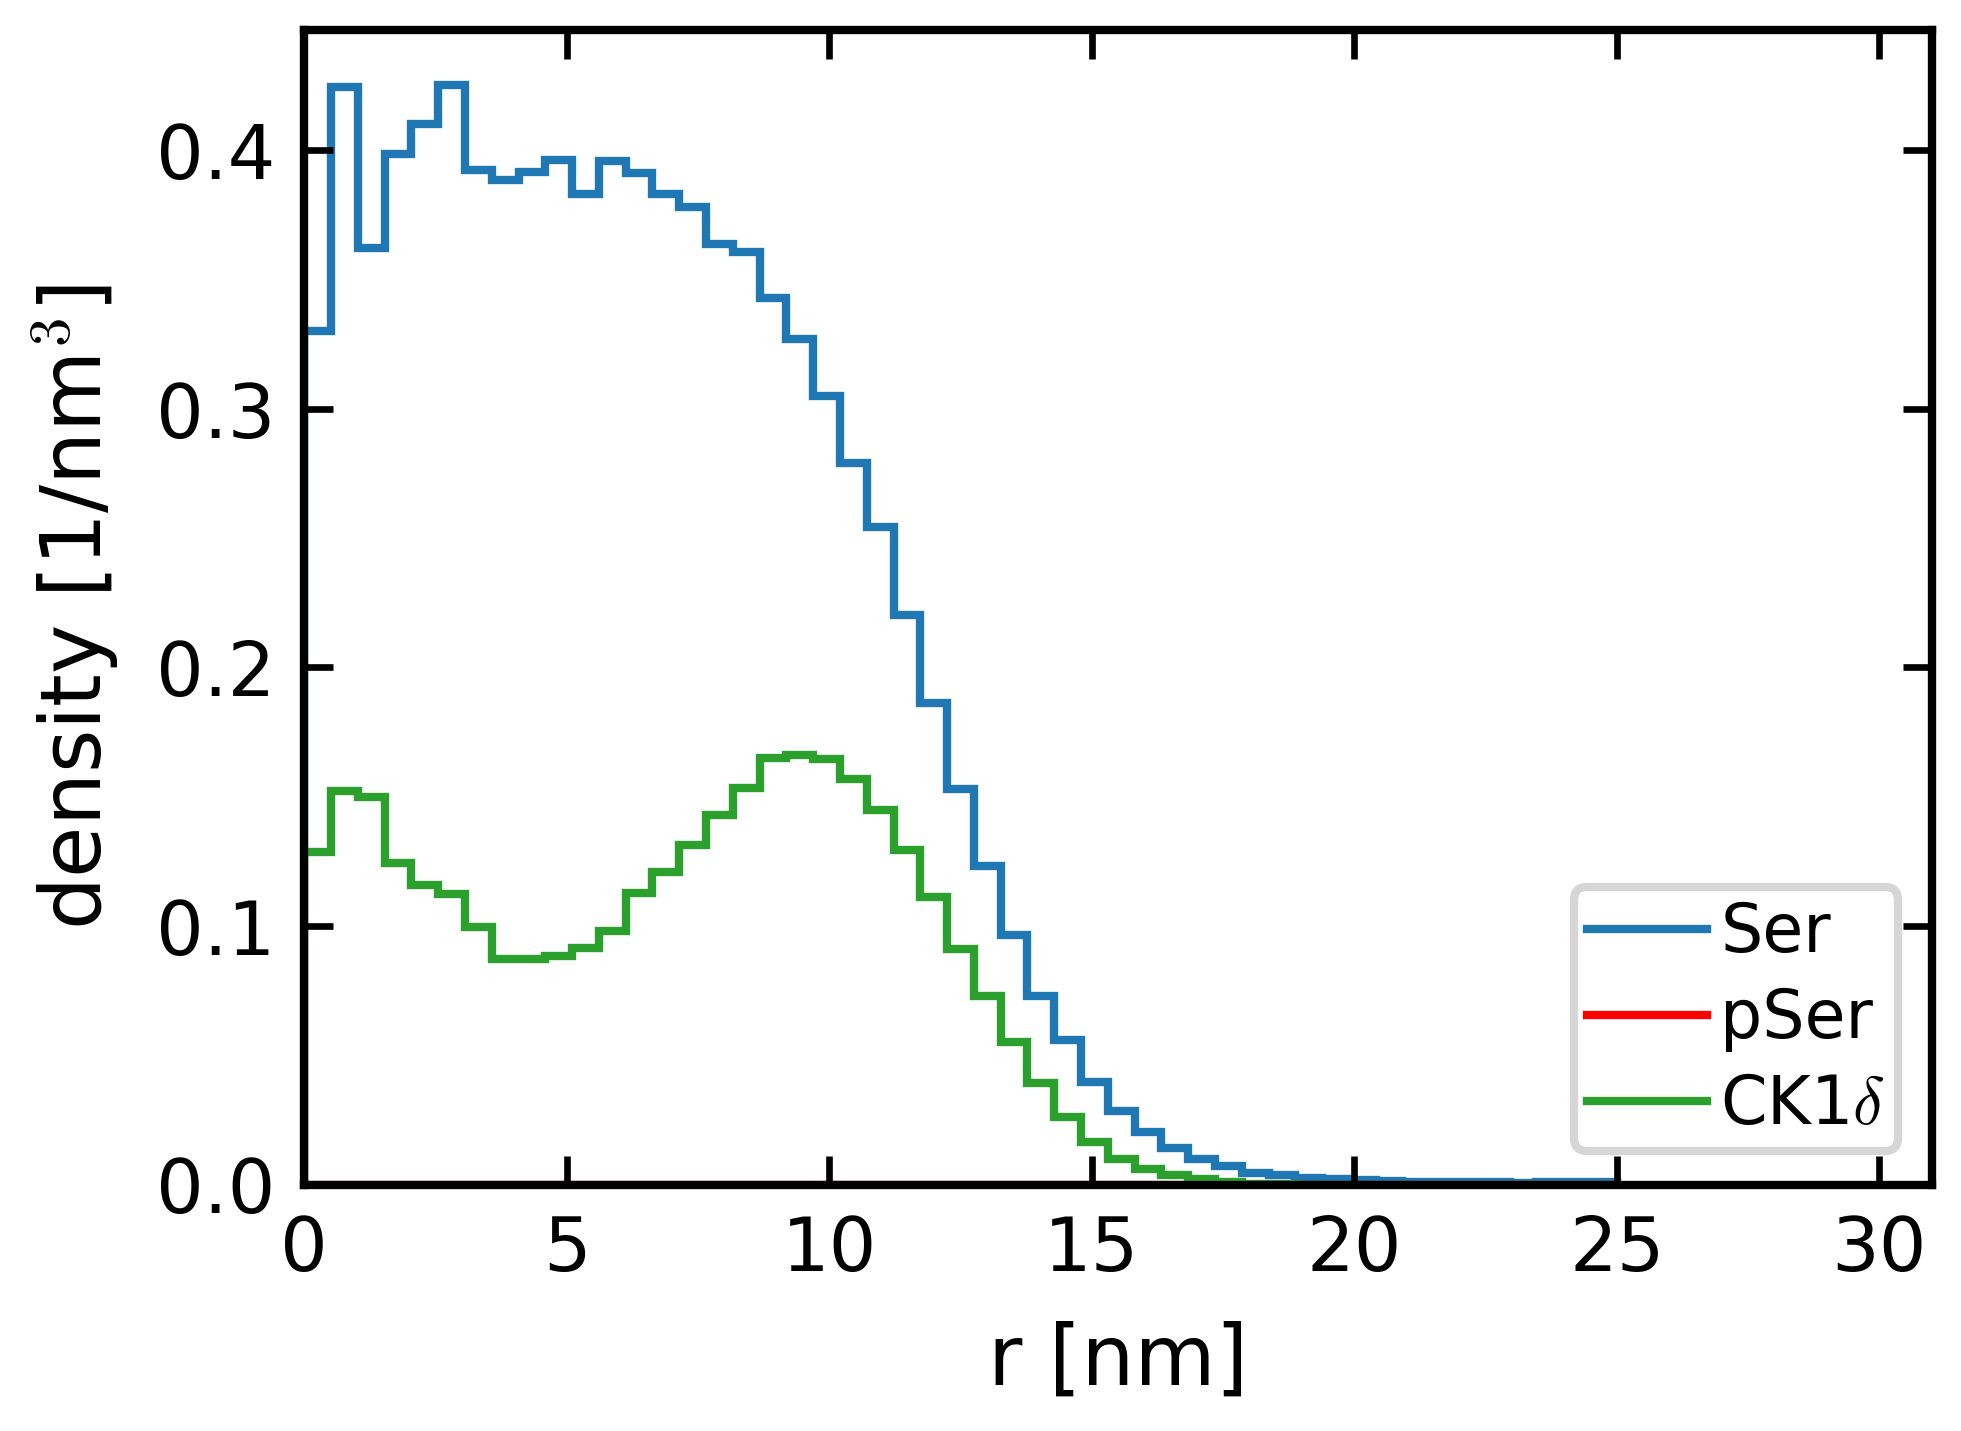

In [13]:
fig, ax = plt.subplots(figsize=(3.5,2.5))

plt.stairs(counts_ser_in, bin_edges, label='Ser')
plt.stairs(counts_pser_in, bin_edges, color='r', label='pSer')
plt.stairs(counts_enz_in, bin_edges, color='tab:green', label='CK1$\delta$')

plt.legend(loc='lower right')
plt.xlabel('r [nm]')
plt.ylabel('density [1/nm$^3$]')
plt.xlim(0,31)

### TDP-43 species arrangements

In [38]:
filename = 'sim_eq_200-tdp43-lcd/sim1_eq_200-tdp43-lcd-1400pser_CAL3_dump_centered.gsd'

bin_centers, densities_by_pser, chain_counts = hpau.compute_radial_density_by_npSer(path_struct+filename, n_chains=200, beads_per_chain=154, 
                                                                       nbins=200, therm=100)


/localscratch/zippoema/lib/python_envs/hpa_env/lib/python3.11/site-packages/gsd/hoomd.py:1125: FutureWarning: The 'rb' mode is deprecated, use 'r'
  gsdfileobj = fl.open(name=str(name),
Computing radial densities: 100%|████████████████████████████████████| 400/400 [00:01<00:00, 279.18it/s]


/tmp/ipykernel_3430250/3975240226.py:87: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = cm.get_cmap(cmap)(np.linspace(0, 1, len(classes)))


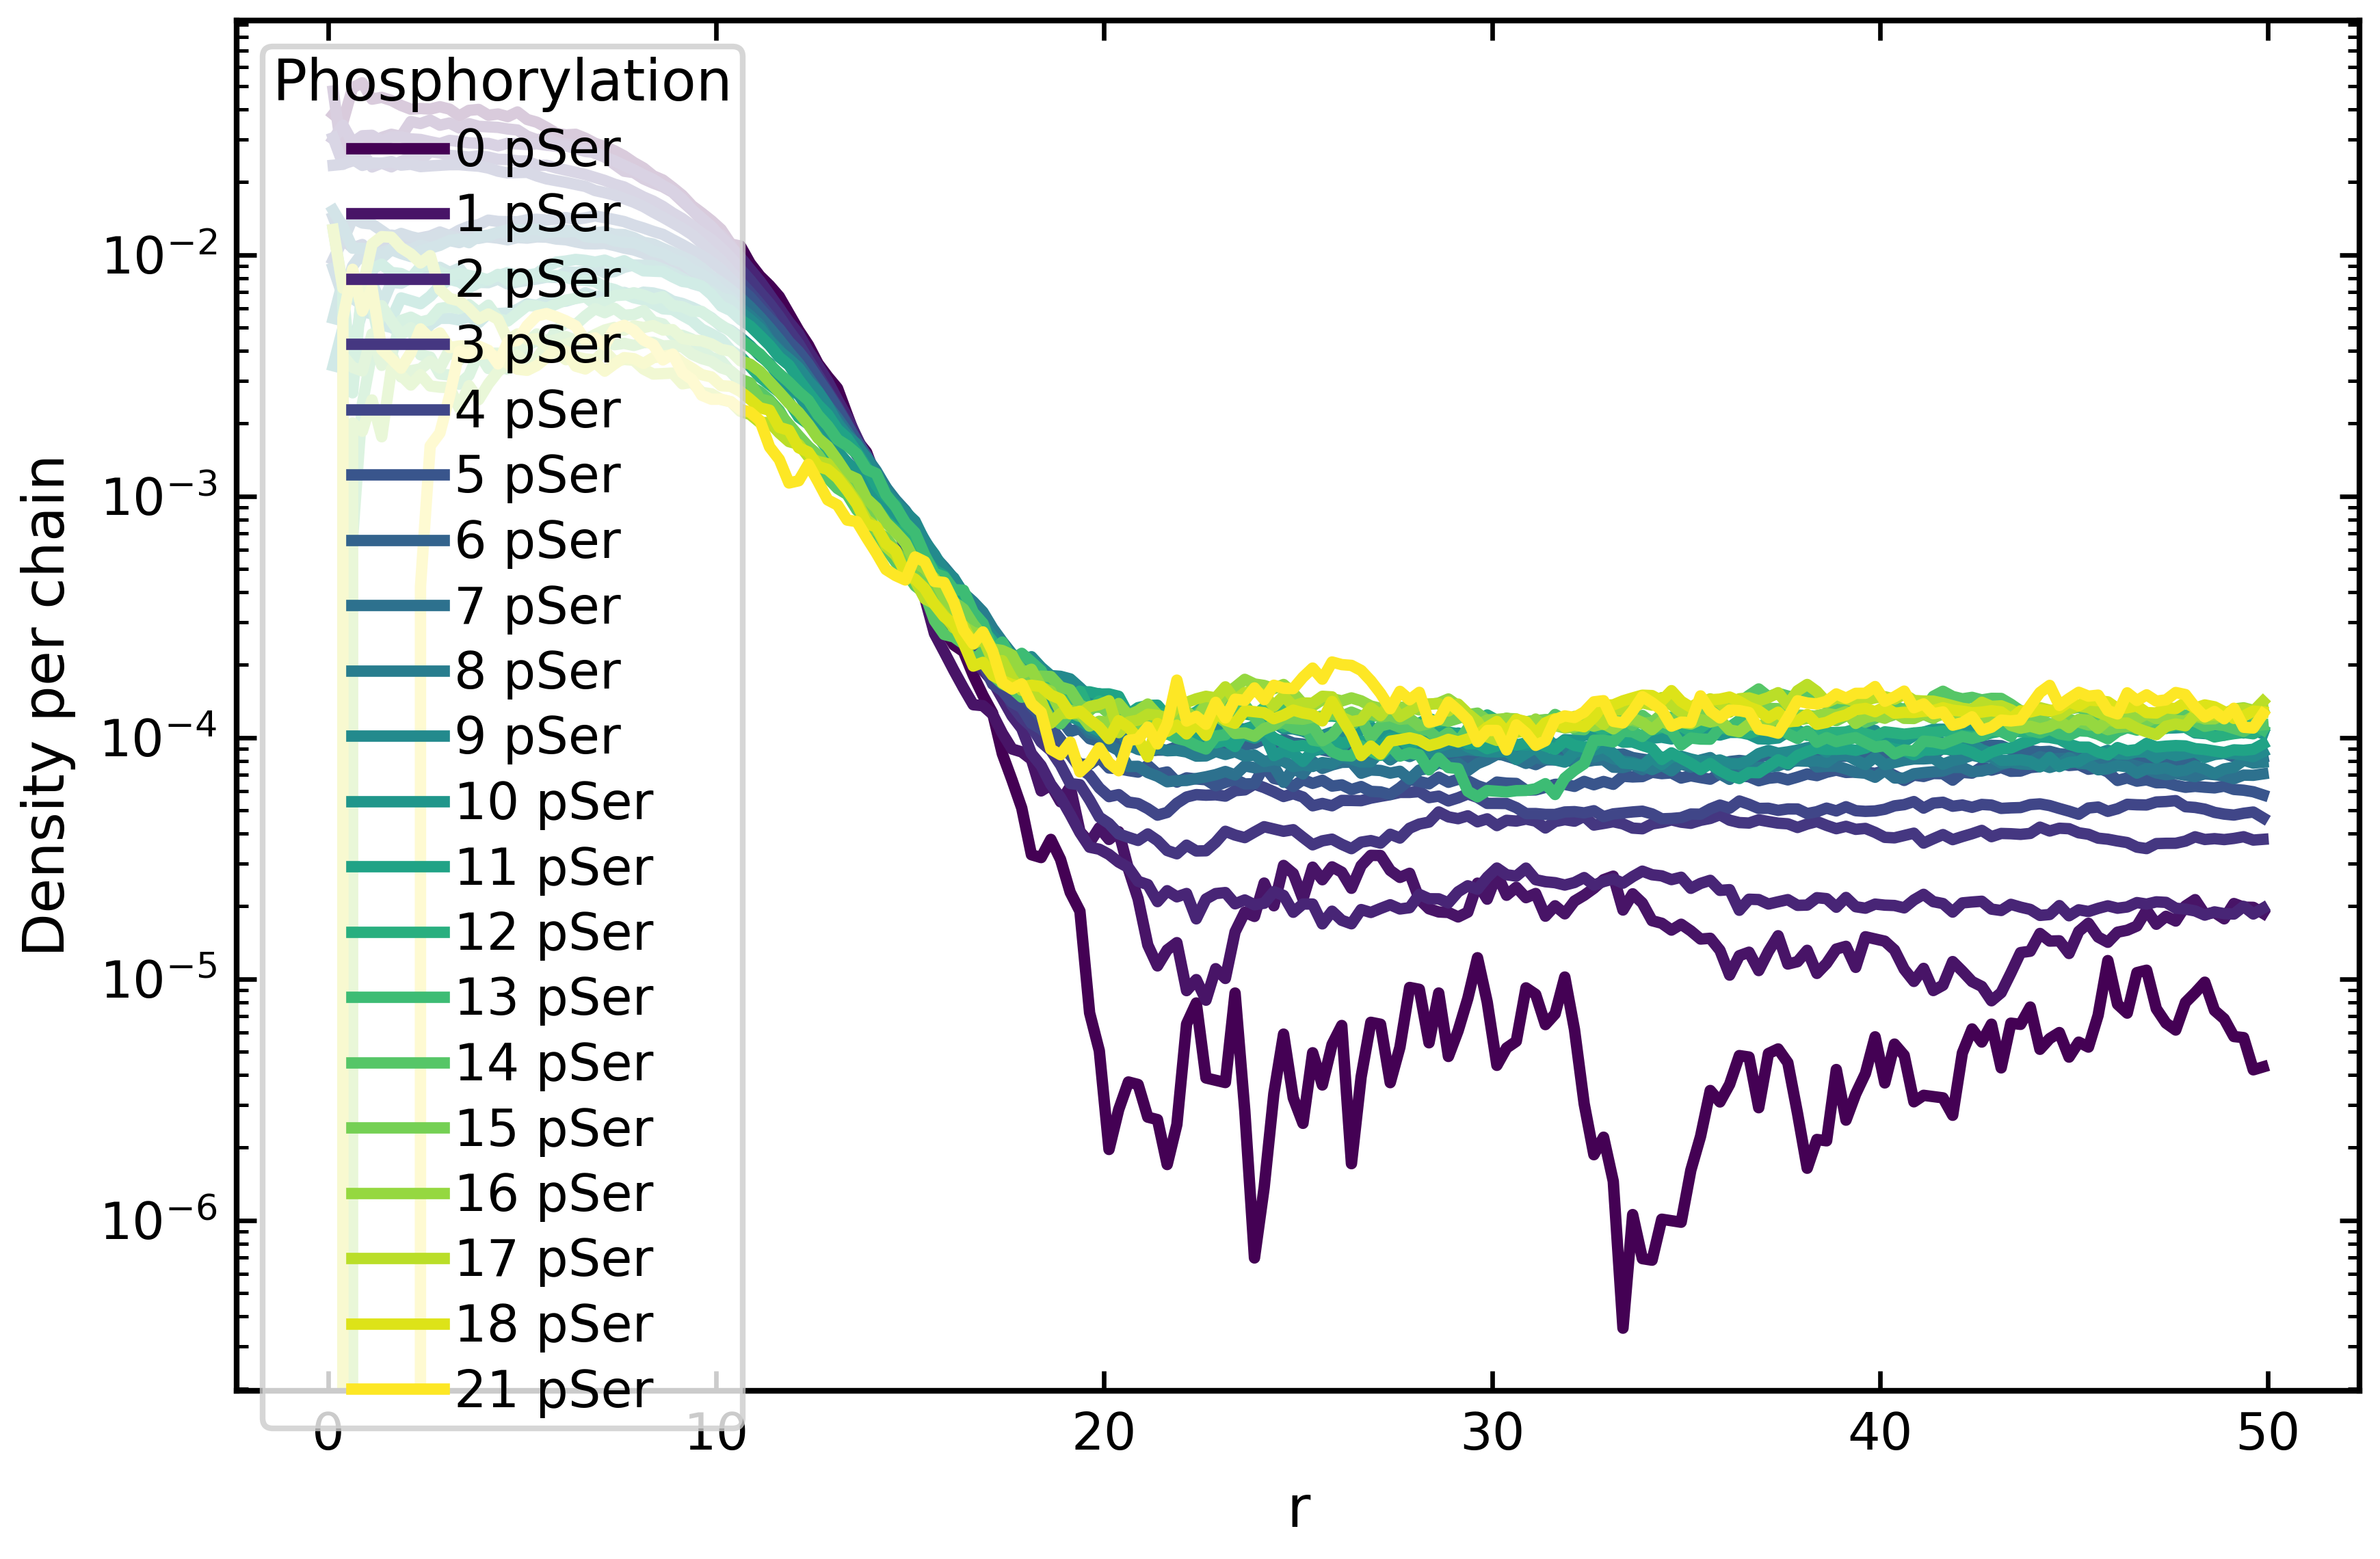

In [12]:
plot_radial_density_profiles_by_npSer(bin_centers, densities_by_pser,
    chain_counts, logscale=True, radial=True)  


/tmp/ipykernel_3430250/3975240226.py:72: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = cm.get_cmap(cmap)(np.linspace(0, 1, len(labels)))


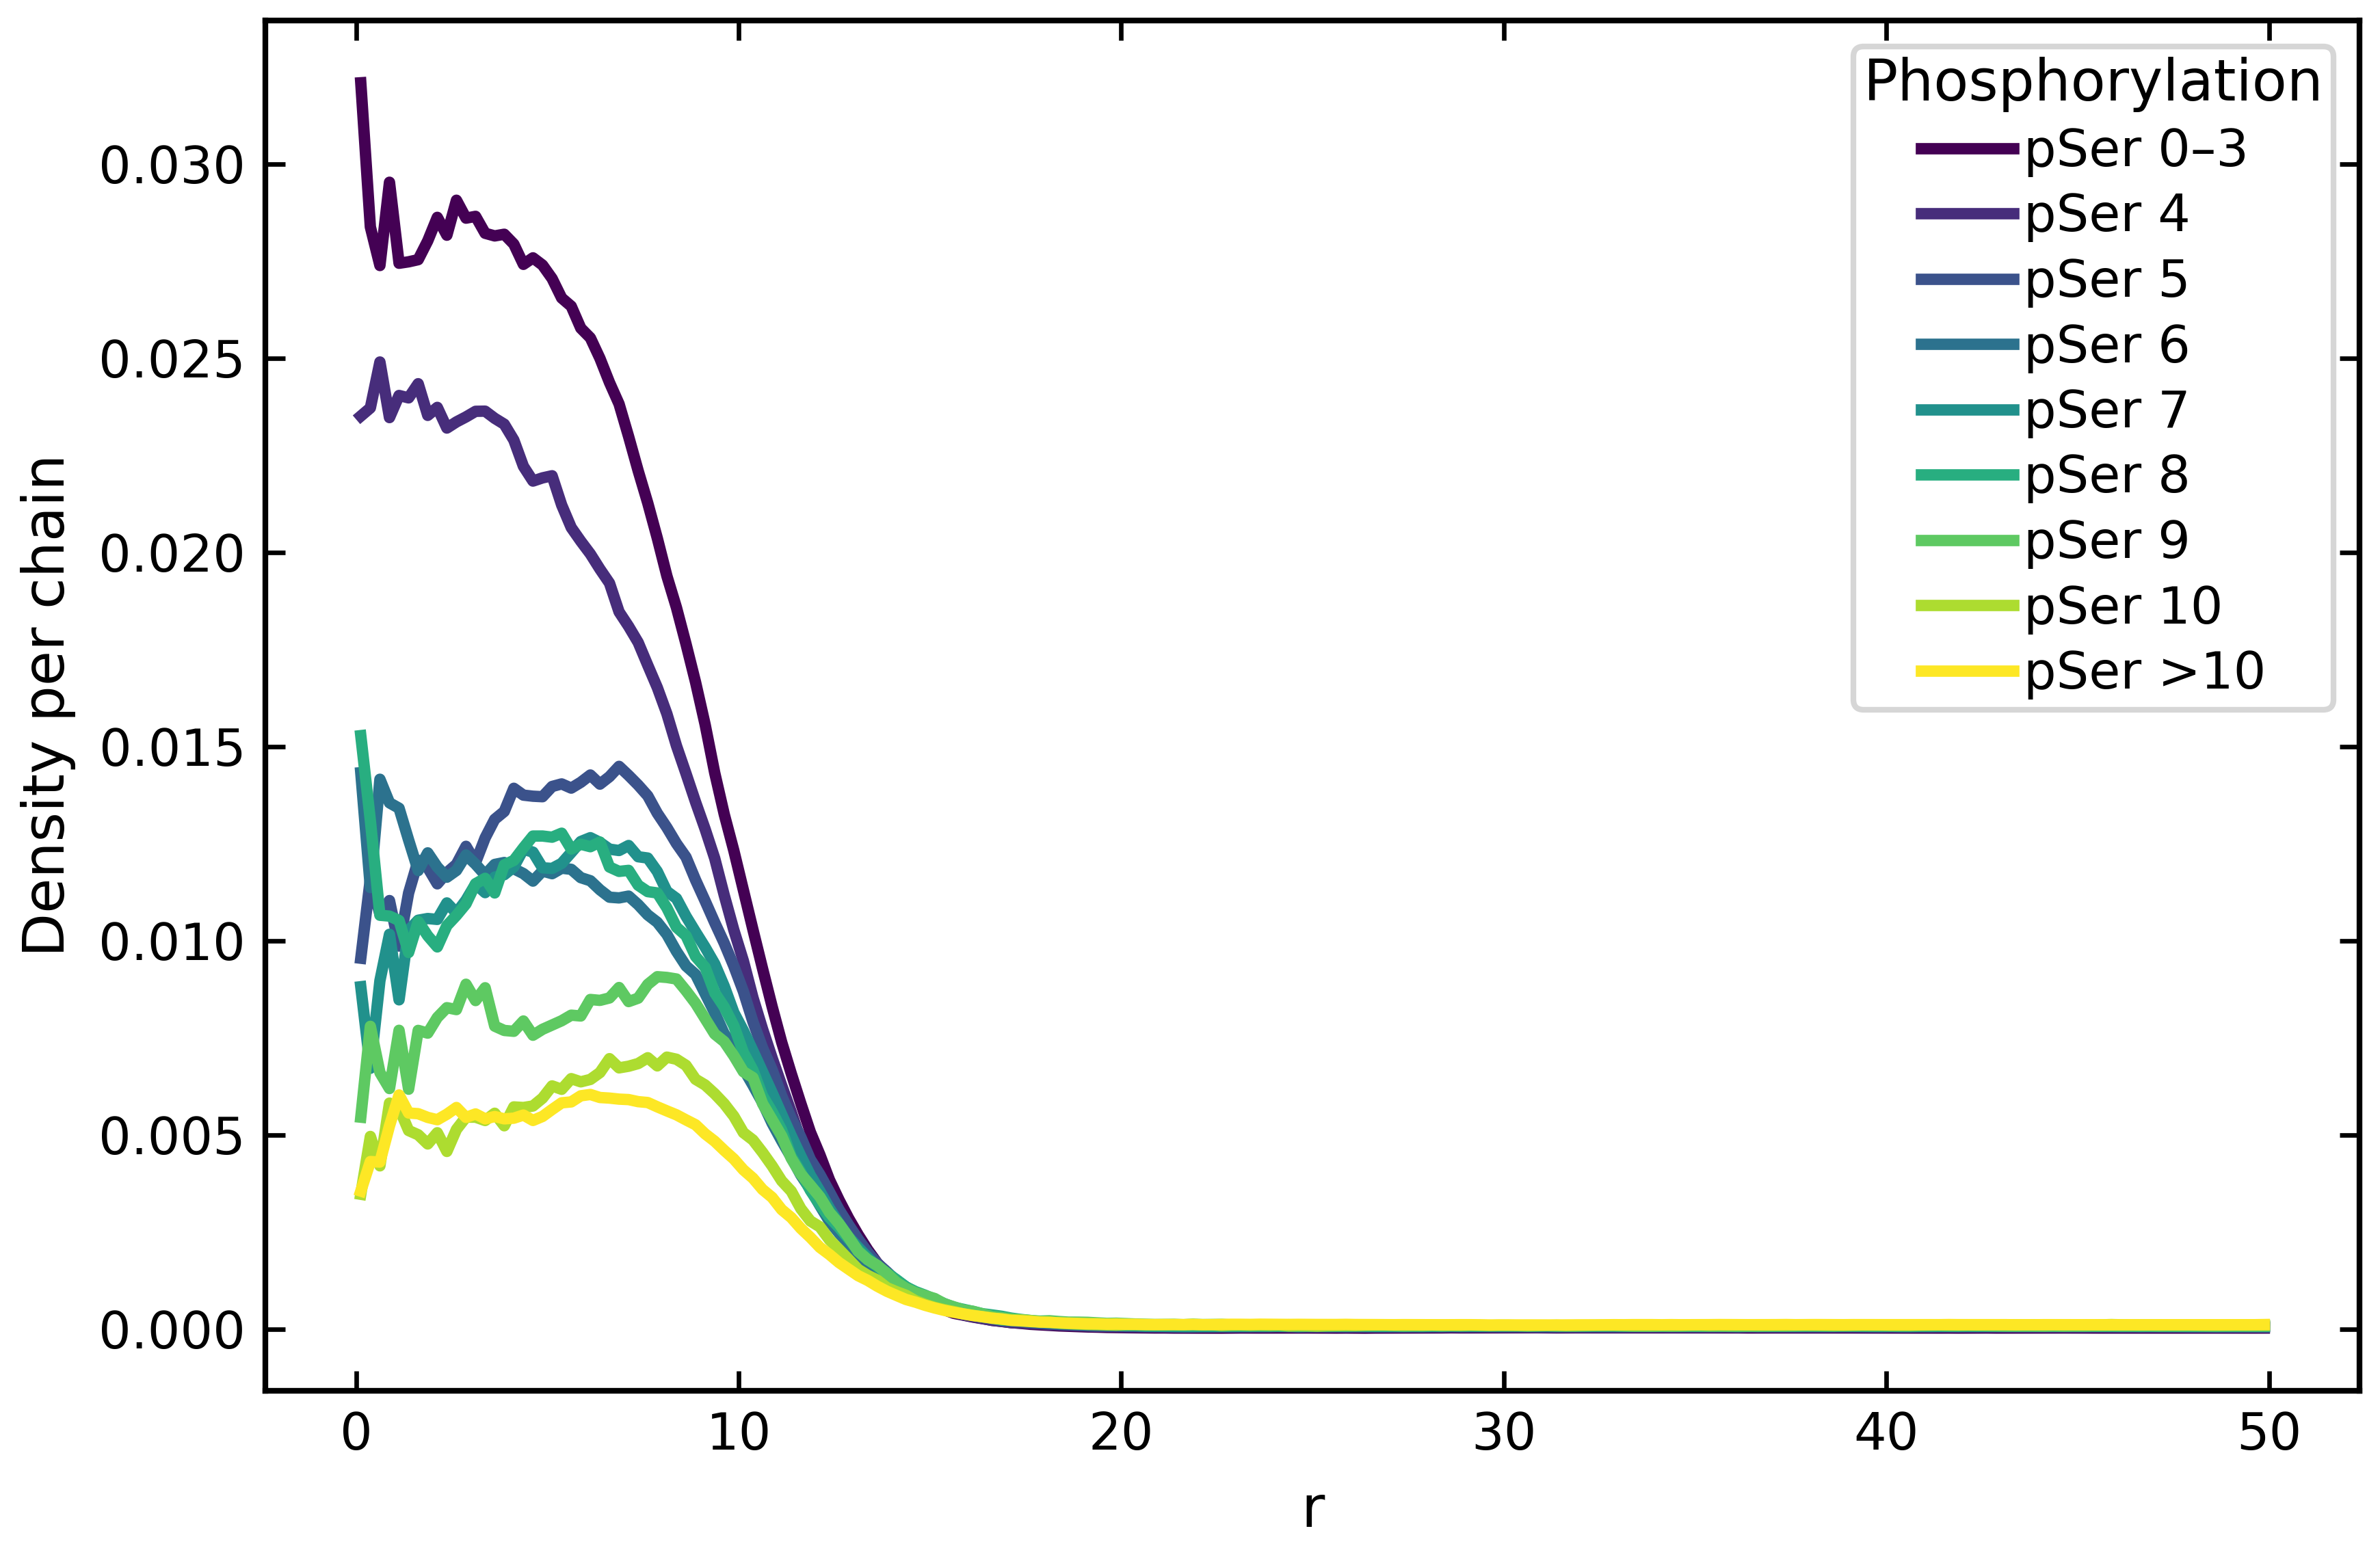

In [40]:
groups = {
    "pSer 0–3": lambda x: 0 <= x <= 3,
    "pSer 4": lambda x: x == 4,
    "pSer 5": lambda x: x == 5,
    "pSer 6": lambda x: x == 6,
    "pSer 7": lambda x: x == 7,
    "pSer 8": lambda x: x == 8,
    "pSer 9": lambda x: x == 9,
    "pSer 10": lambda x: x == 10,
    "pSer >10": lambda x: x > 10
}


plot_radial_density_profiles_by_npSer(bin_centers, densities_by_pser,
    chain_counts, logscale=False, radial=True, groups=groups, save=path_struct_pl+"density_r_by_npSer_200-tdp43-lcd-1400pSer")  


### Density profile slab

#### Position enzymes

In [7]:
filename = 'equilibrium/sim_eq_slab_150-full-tdp43_2-ck1d-open_10-pp3/sim_eq_slab_150-com-full-tdp43_2-com-ck1d-open_10-com-pp3_CAL3_dump_centered.gsd'

bin_centers_ck1d_p, density_ck1d_p = hpau.compute_density_profile(path_dir+filename, axis=2, 
                                                         nbins=200, group=[i for i in range(62100,62100+292+292)], therm=100)
bin_centers_pp3_p, density_pp3_p = hpau.compute_density_profile(path_dir+filename, axis=2, 
                                                         nbins=200, group=[i for i in range(62100+292+292,67954)], therm=100)
bin_centers_tdp_p, density_tdp_p = hpau.compute_density_profile(path_dir+filename, axis=2, 
                                                         nbins=200, group=[i for i in range(0,62100)], therm=100)


/localscratch/zippoema/lib/python_envs/hpa_env/lib/python3.11/site-packages/gsd/hoomd.py:1125: FutureWarning: The 'rb' mode is deprecated, use 'r'
  gsdfileobj = fl.open(name=str(name),


In [8]:
filename = 'equilibrium/sim_eq_slab_150-full-tdp43_2-ck1d-open_10-pp3/sim_eq_slab_150-com-full-tdp43-396pser_2-com-ck1d-open_10-com-pp3_CAL3_dump_centered.gsd'

bin_centers_ck1d_p_8pc, density_ck1d_p_8pc = hpau.compute_density_profile(path_dir+filename, axis=2, 
                                                         nbins=200, group=[i for i in range(62100,62100+292+292)], therm=100)
bin_centers_pp3_p_8pc, density_pp3_p_8pc = hpau.compute_density_profile(path_dir+filename, axis=2, 
                                                         nbins=200, group=[i for i in range(62100+292+292,67954)], therm=100)
bin_centers_tdp_p_8pc, density_tdp_p_8pc = hpau.compute_density_profile(path_dir+filename, axis=2, 
                                                         nbins=200, group=[i for i in range(0,62100)], therm=100)


In [16]:
filename = 'sim_eq_slab_150-full-tdp43_5-ck1d-open/sim_eq_slab_150-com-full-tdp43_5-com-ck1d-open_CAL3_dump_centered.gsd'

bin_centers_ck1d, density_ck1d = hpau.compute_density_profile(path_struct+filename, axis=2, 
                                                         nbins=200, group=[i for i in range(62100,62100+292*5)], therm=100)

bin_centers_tdp, density_tdp = hpau.compute_density_profile(path_struct+filename, axis=2, 
                                                         nbins=200, group=[i for i in range(0,62100)], therm=100)


/localscratch/zippoema/lib/python_envs/hpa_env/lib/python3.11/site-packages/gsd/hoomd.py:1125: FutureWarning: The 'rb' mode is deprecated, use 'r'
  gsdfileobj = fl.open(name=str(name),


In [17]:
filename = 'sim_eq_slab_150-full-tdp43_5-ck1d-open/sim_eq_slab_150-com-full-tdp43-922pser_5-com-ck1d-open_CAL3_dump_centered.gsd'

bin_centers_ck1d_922, density_ck1d_922 = hpau.compute_density_profile(path_struct+filename, axis=2, 
                                                         nbins=200, group=[i for i in range(62100,62100+292*5)], therm=100)

bin_centers_tdp_922, density_tdp_922 = hpau.compute_density_profile(path_struct+filename, axis=2, 
                                                         nbins=200, group=[i for i in range(0,62100)], therm=100)


In [18]:
filename = 'sim_eq_slab_150-full-tdp43_5-pp3/sim_eq_slab_150-com-full-tdp43_5-com-pp3_CAL3_dump_centered.gsd'

bin_centers_pp3, density_pp3 = hpau.compute_density_profile(path_struct+filename, axis=2, 
                                                         nbins=200, group=[i for i in range(62100,62100+527*5)], therm=100)

bin_centers_tdp_pp3, density_tdp_pp3 = hpau.compute_density_profile(path_struct+filename, axis=2, 
                                                         nbins=200, group=[i for i in range(0,62100)], therm=100)

filename = 'sim_eq_slab_150-full-tdp43_5-pp3/sim_eq_slab_150-com-full-tdp43-922pser_5-com-pp3_CAL3_dump_centered.gsd'

bin_centers_pp3_922, density_pp3_922 = hpau.compute_density_profile(path_struct+filename, axis=2, 
                                                         nbins=200, group=[i for i in range(62100,62100+527*5)], therm=100)

bin_centers_tdp_pp3_922, density_tdp_pp3_922 = hpau.compute_density_profile(path_struct+filename, axis=2, 
                                                         nbins=200, group=[i for i in range(0,62100)], therm=100)



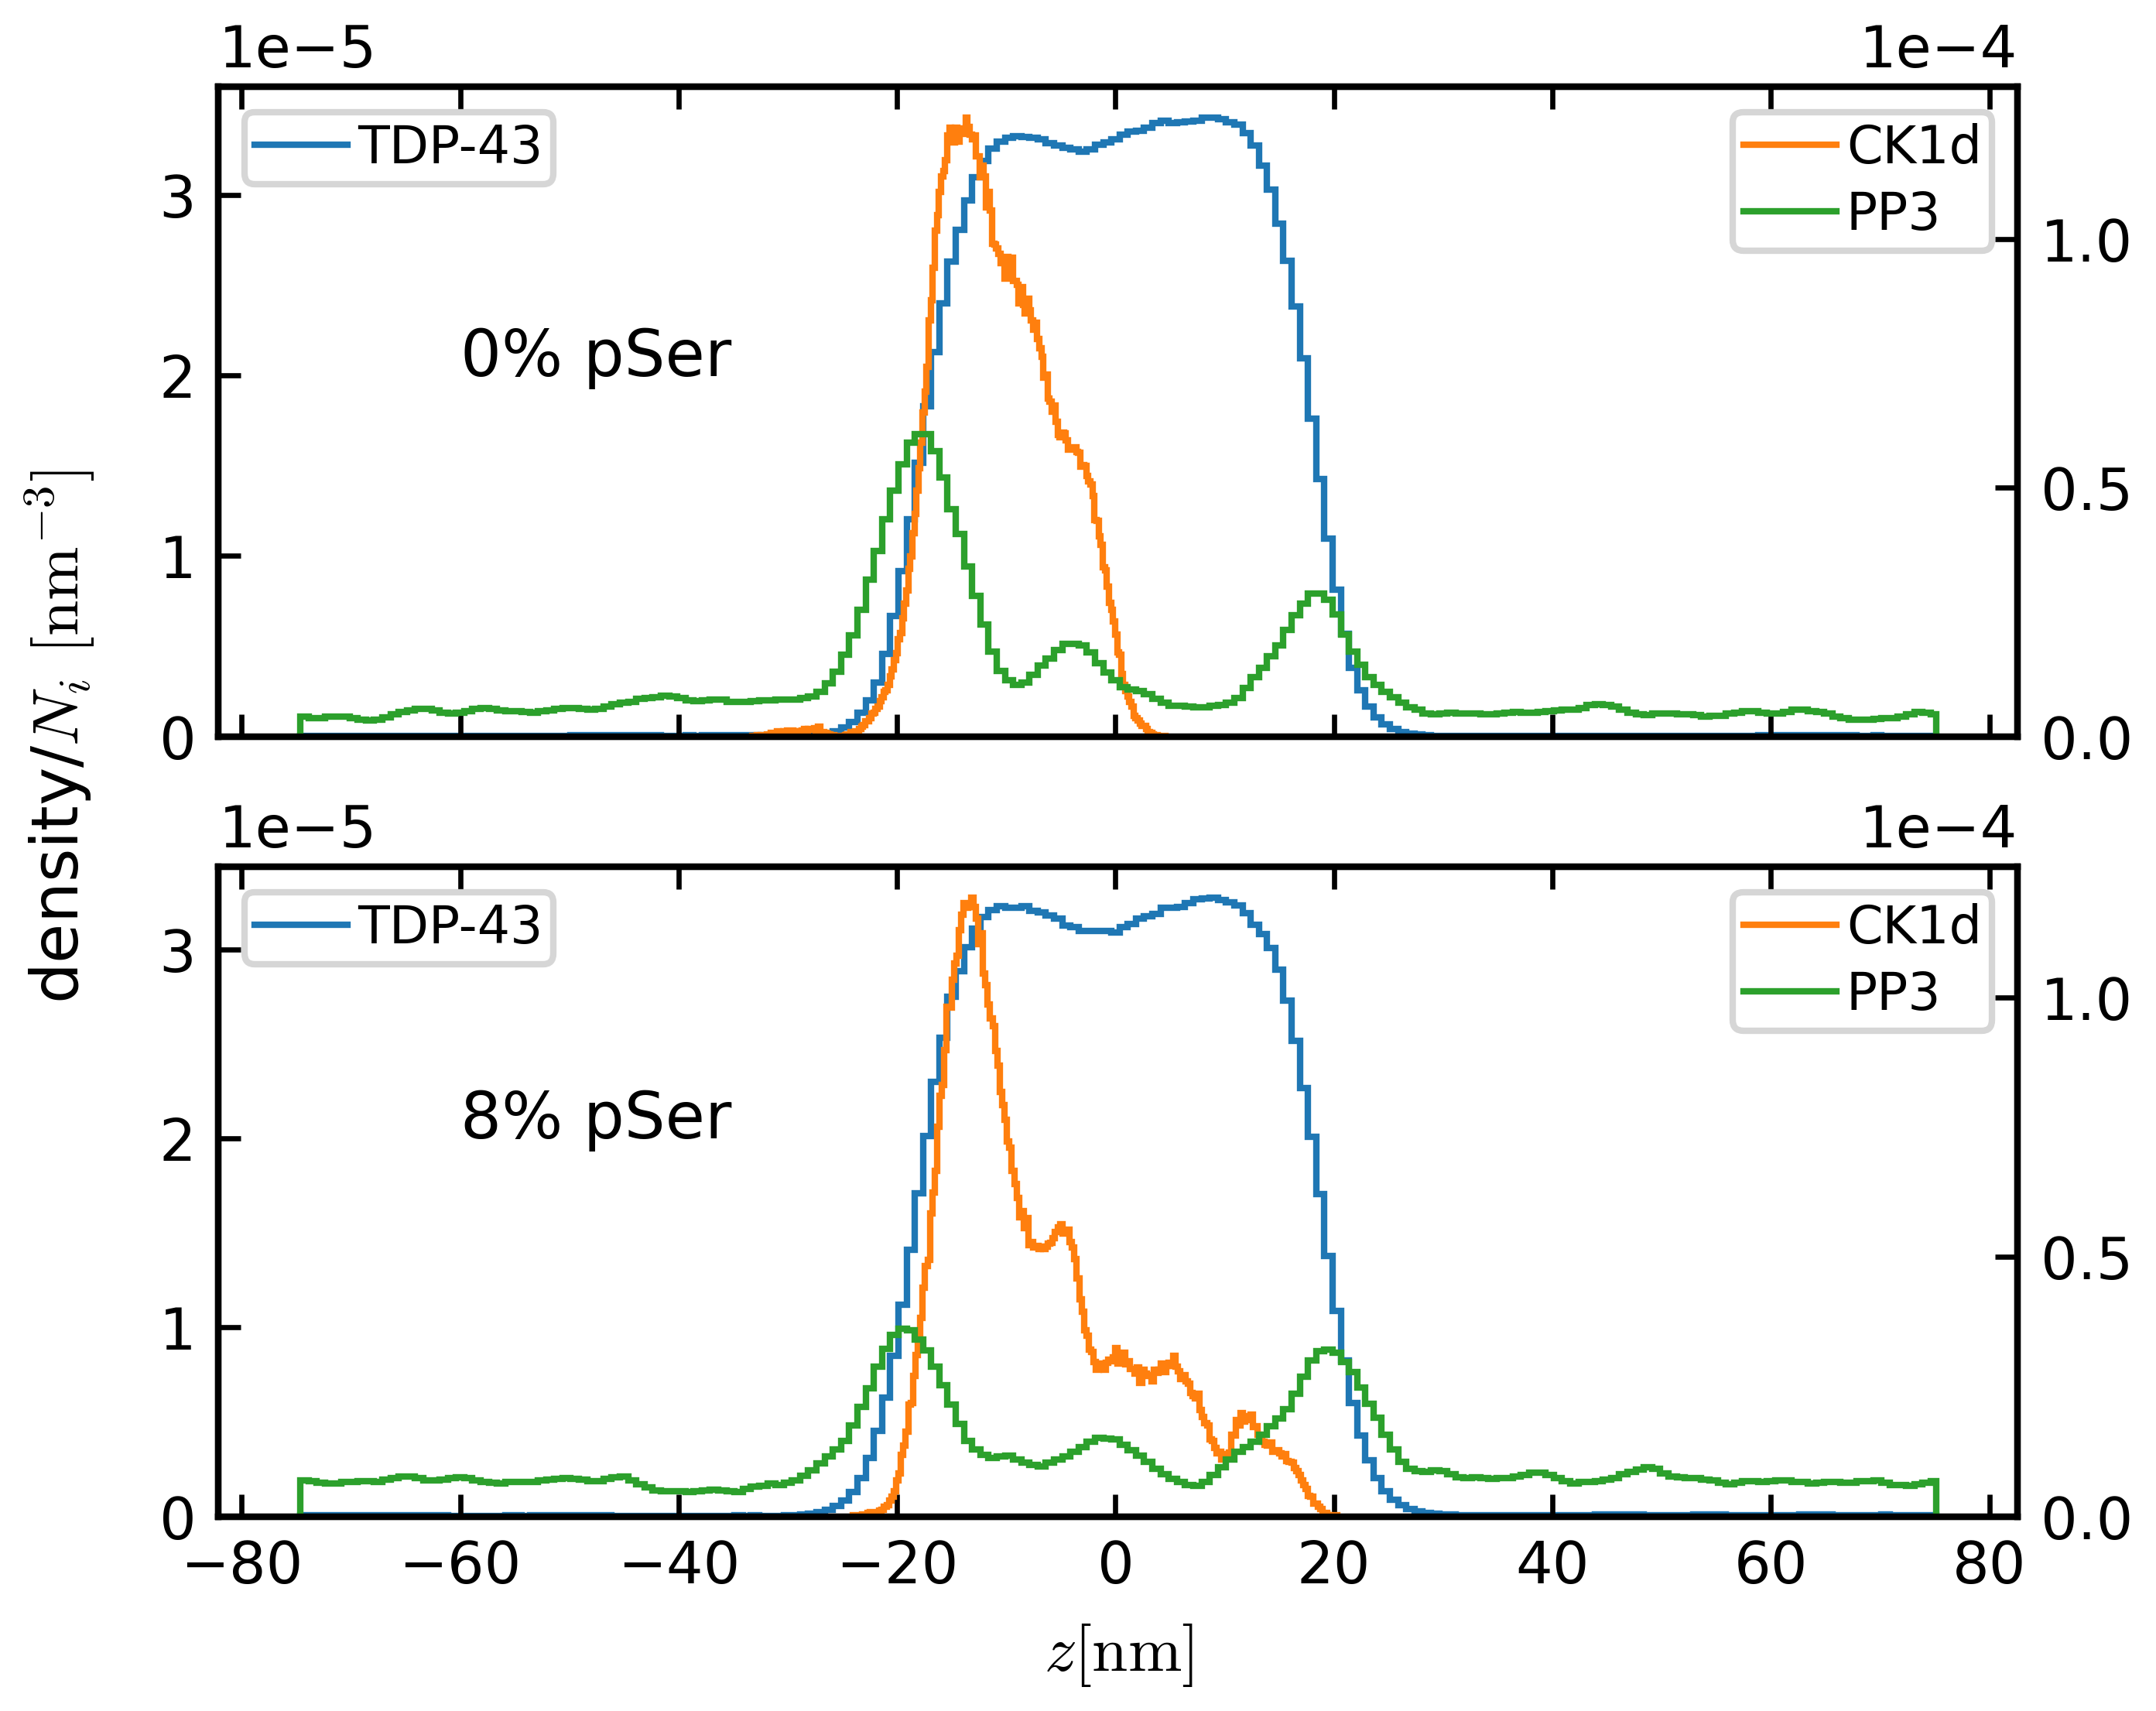

In [11]:
f, (ax1, ax2) = plt.subplots(2, 1, figsize=(5,4), sharex=True)
plt.subplots_adjust(hspace=0.2)

ax11 = ax1.twinx()
ax1.stairs(density_tdp_p/200/414, np.append(bin_centers_tdp_p,bin_centers_tdp_p[-1]+0.5), ls='-', color='tab:blue', label='TDP-43')
ax11.stairs(density_ck1d_p/2/292, np.append(bin_centers_ck1d_p,bin_centers_ck1d_p[-1]+0.5), color='tab:orange', label='CK1d')
ax11.stairs(density_pp3_p/10/527, np.append(bin_centers_pp3_p,bin_centers_pp3_p[-1]+0.5), color='tab:green', label='PP3')

ax21 = ax2.twinx()
ax2.stairs(density_tdp_p_8pc/200/414, np.append(bin_centers_tdp_p_8pc,bin_centers_tdp_p_8pc[-1]+0.5), ls='-', color='tab:blue', label='TDP-43')
ax21.stairs(density_ck1d_p_8pc/2/292, np.append(bin_centers_ck1d_p_8pc,bin_centers_ck1d_p_8pc[-1]+0.5), ls='-', color='tab:orange', label='CK1d')
ax21.stairs(density_pp3_p_8pc/10/527, np.append(bin_centers_pp3_p_8pc,bin_centers_pp3_p_8pc[-1]+0.5), ls='-', color='tab:green', label='PP3')

ax1.legend(loc='upper left', )
ax2.legend(loc='upper left', )
ax11.legend(loc='upper right', )
ax21.legend(loc='upper right', )

ax2.set_xlabel('$z [\mathrm{nm}]$')
ax1.text(-100, 0., r'density/$N_i$ $[\mathrm{nm}^{-3}]$', va='center', rotation='vertical')

ax1.text(-60, 0.00002, '0% pSer')
ax2.text(-60, 0.00002, '8% pSer')

plt.savefig(f'/localscratch/zippoema/project_ness/plots/density_profile_2-ck1d-open_10-pp3.png', dpi=1200)


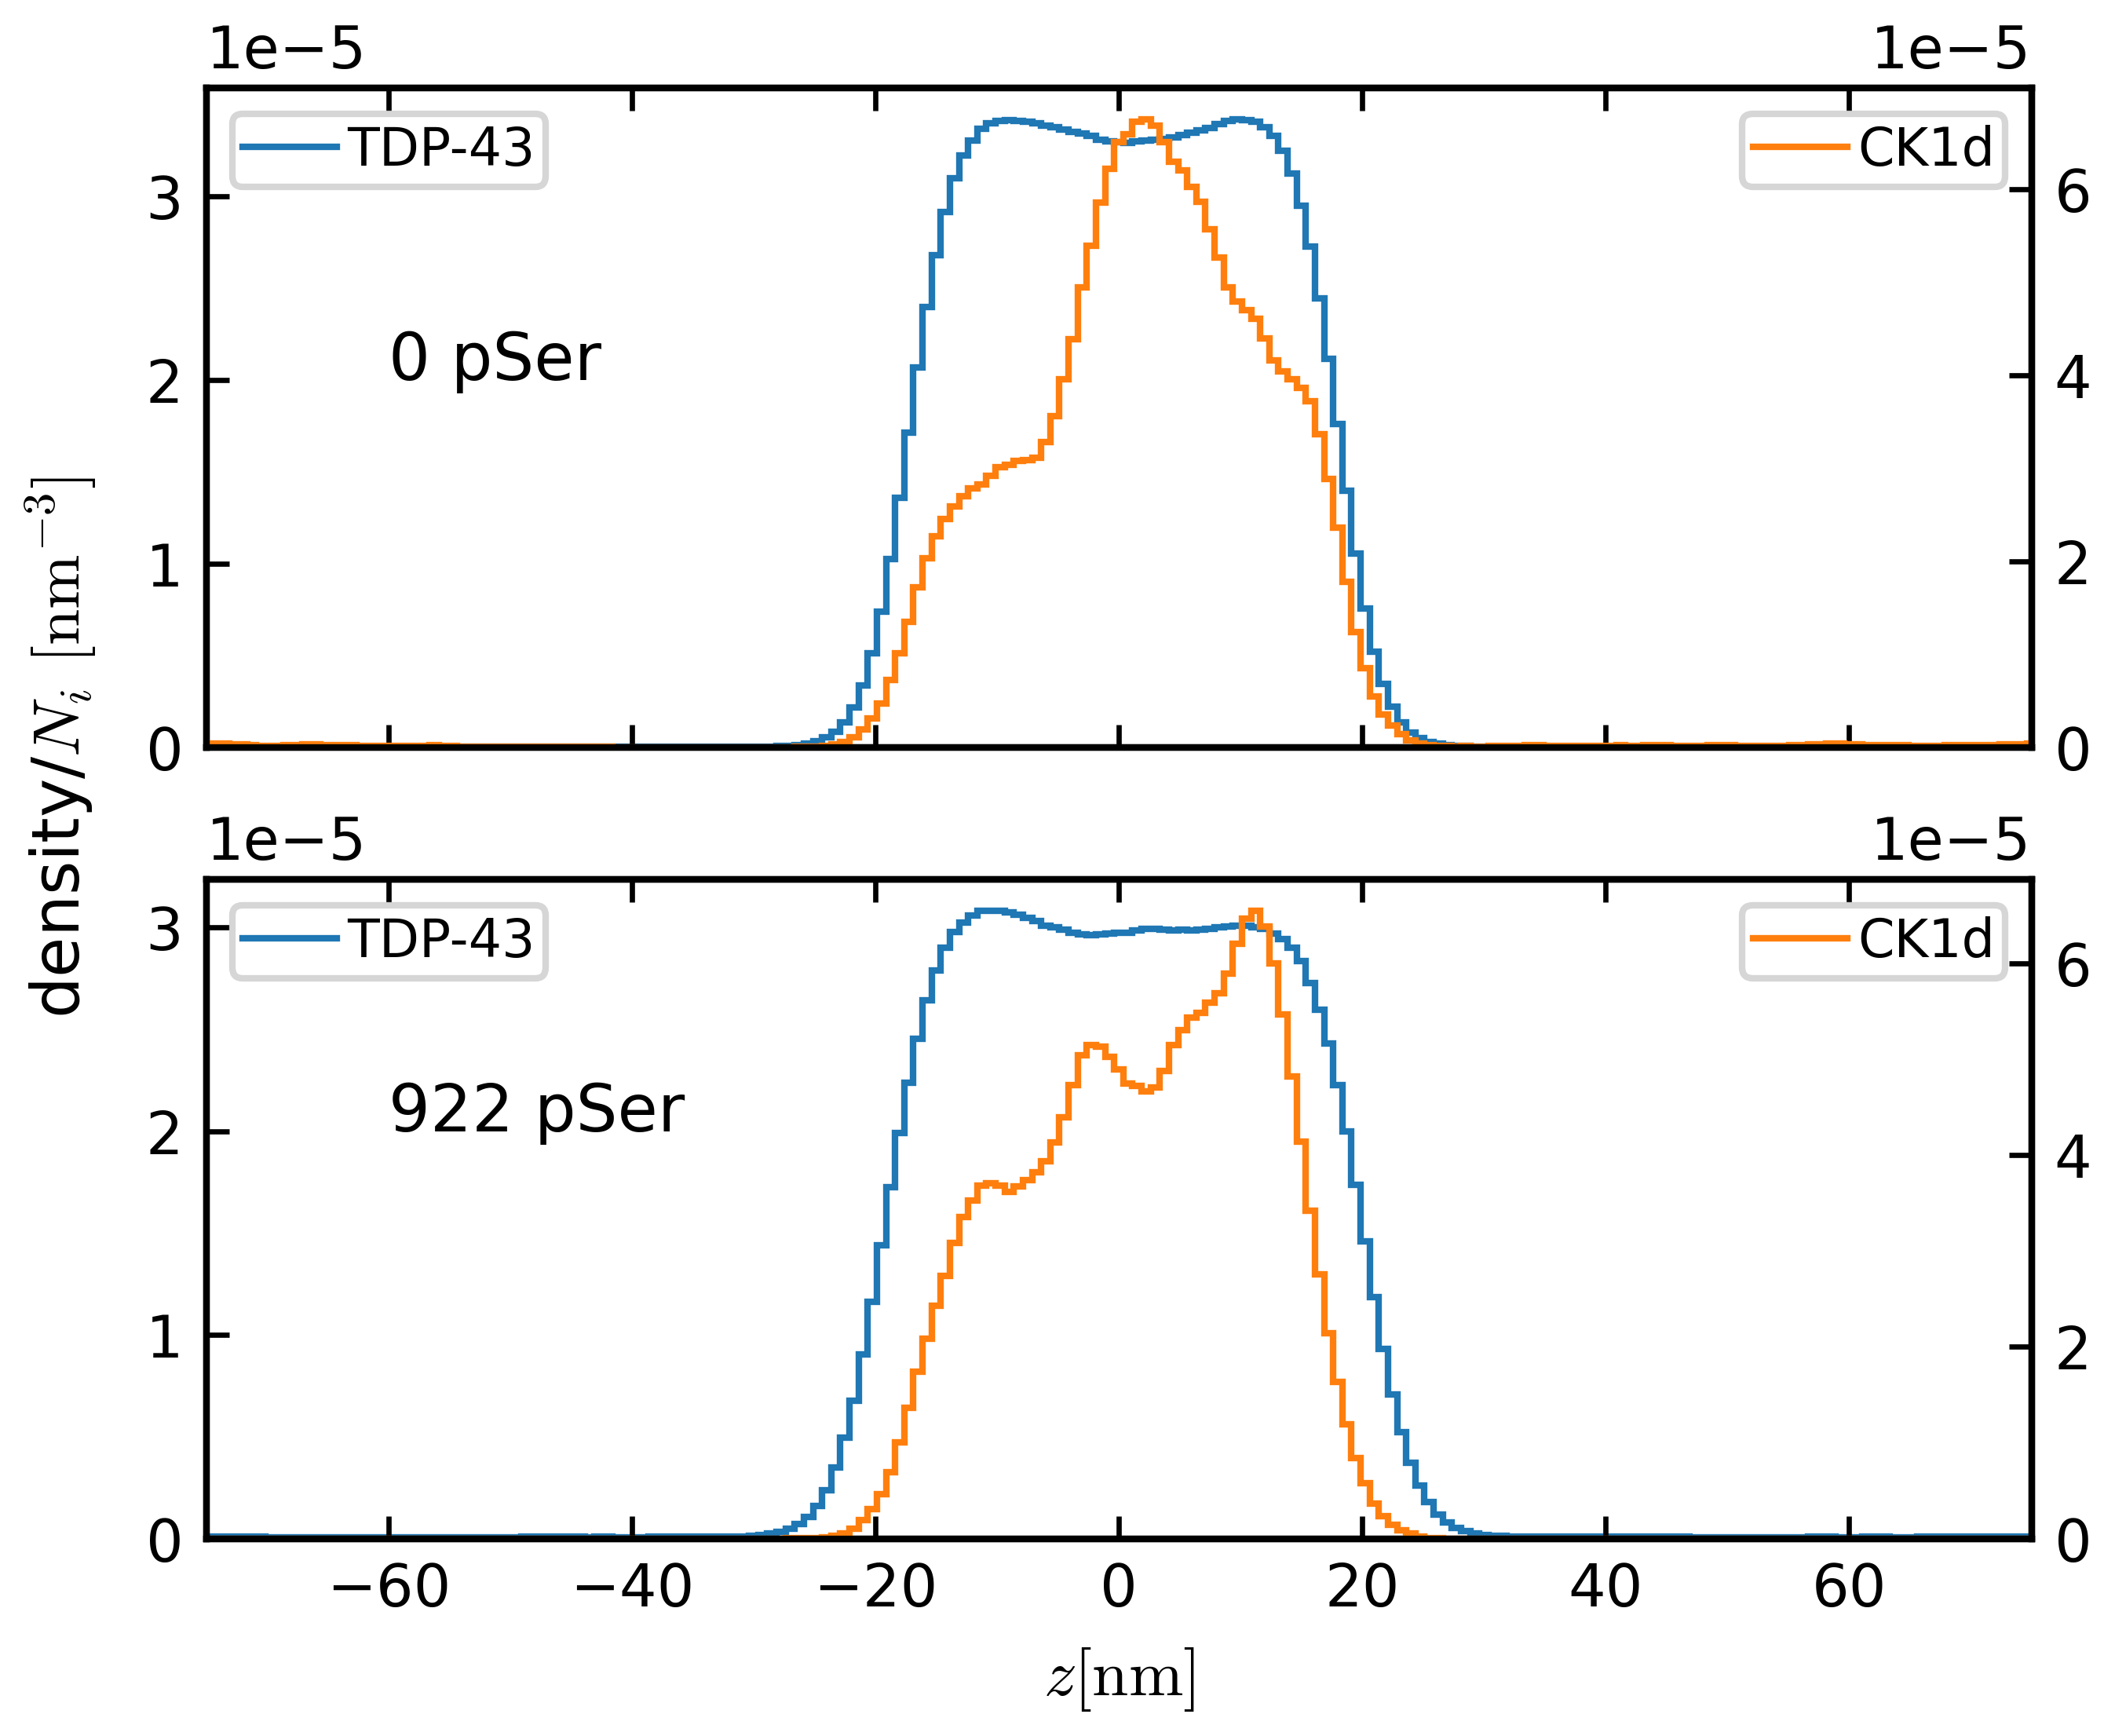

In [42]:
f, (ax1, ax2) = plt.subplots(2, 1, figsize=(5,4), sharex=True)
plt.subplots_adjust(hspace=0.2)
plt.xlim(-75,+75)

ax11 = ax1.twinx()
ax1.stairs(density_tdp/200/414, np.append(bin_centers_tdp,bin_centers_tdp[-1]+0.5), ls='-', color='tab:blue', label='TDP-43')
ax11.stairs(density_ck1d/5/292, np.append(bin_centers_ck1d,bin_centers_ck1d[-1]+0.5), color='tab:orange', label='CK1d')

ax21 = ax2.twinx()
ax2.stairs(density_tdp_922/200/414, np.append(bin_centers_tdp_922,bin_centers_tdp_922[-1]+0.5), ls='-', color='tab:blue', label='TDP-43')
ax21.stairs(density_ck1d_922/5/292, np.append(bin_centers_ck1d_922,bin_centers_ck1d_922[-1]+0.5), ls='-', color='tab:orange', label='CK1d')

ax1.legend(loc='upper left', )
ax2.legend(loc='upper left', )
ax11.legend(loc='upper right', )
ax21.legend(loc='upper right', )

ax2.set_xlabel('$z [\mathrm{nm}]$')
ax1.text(-90, 0., r'density/$N_i$ $[\mathrm{nm}^{-3}]$', va='center', rotation='vertical')

ax1.text(-60, 0.00002, '0 pSer')
ax2.text(-60, 0.00002, '922 pSer')

filename=path_struct_pl+f'density_profile_150-full-tdp43_5-ck1d-open'
plt.savefig(filename+'.png', dpi=600)
plt.savefig(filename+'.pdf', dpi=600)


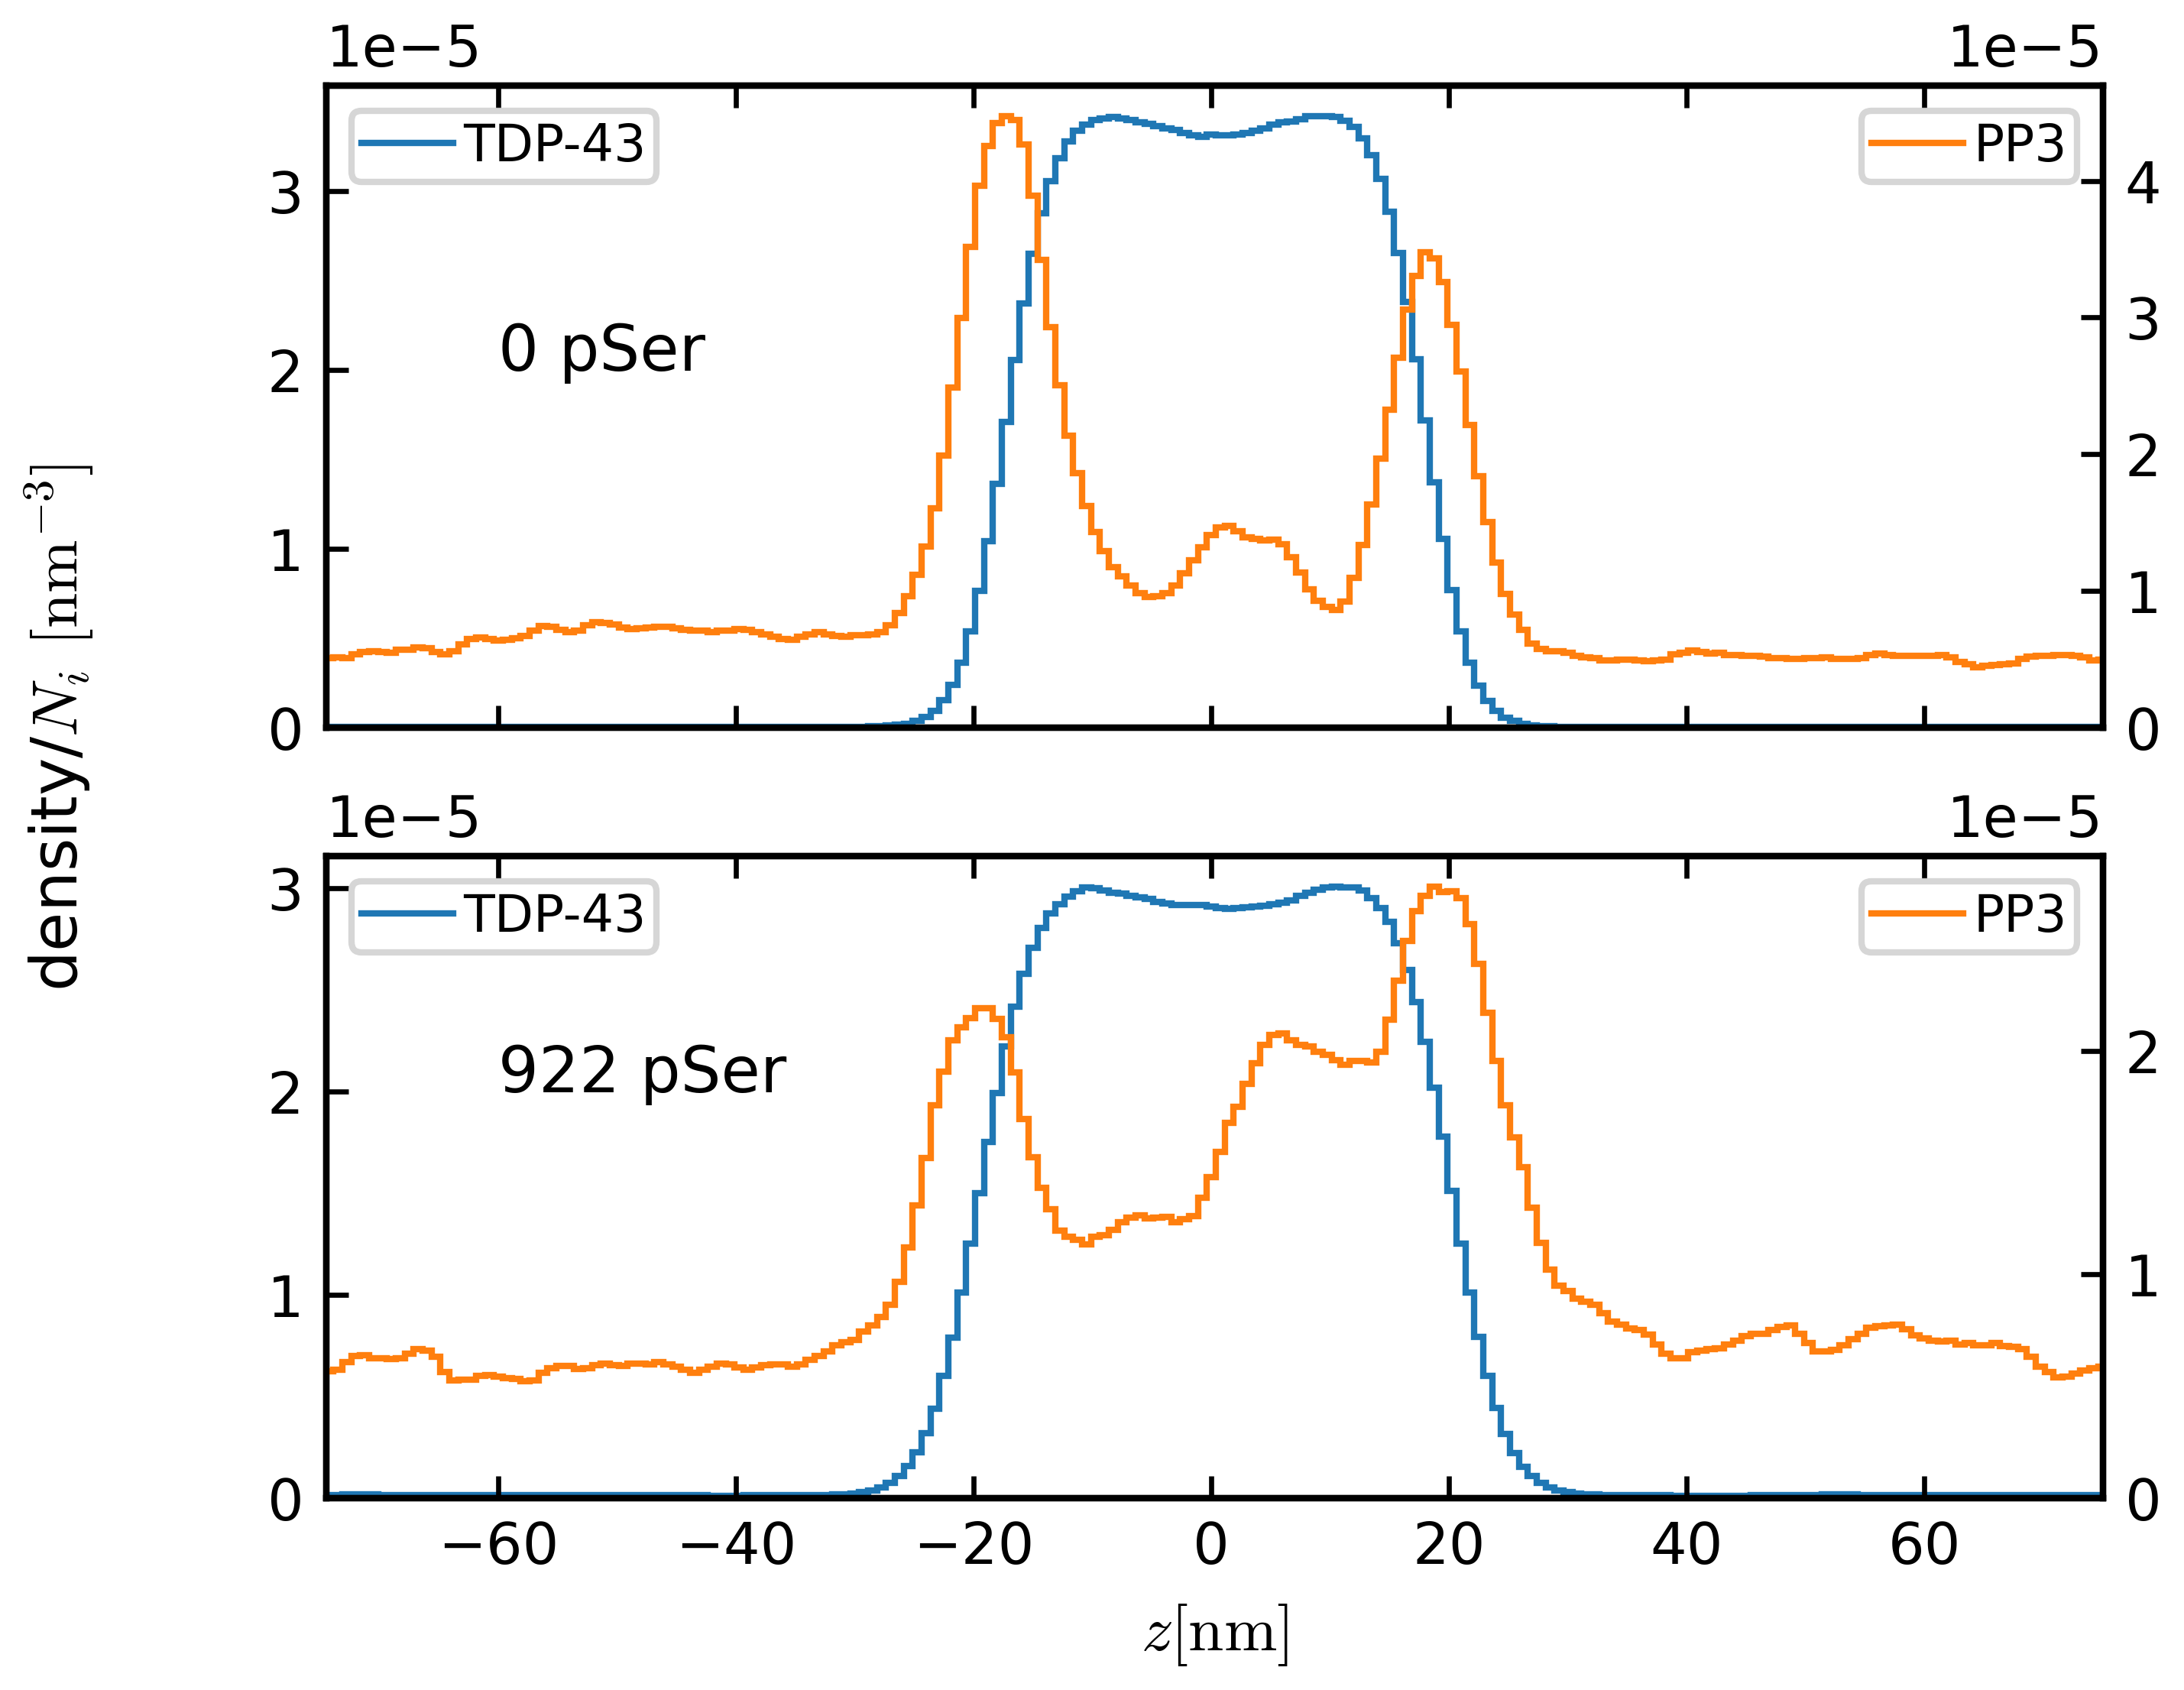

In [43]:
f, (ax1, ax2) = plt.subplots(2, 1, figsize=(5,4), sharex=True)
plt.subplots_adjust(hspace=0.2)
plt.xlim(-74.5,+75)

ax11 = ax1.twinx()
ax1.stairs(density_tdp_pp3/200/414, np.append(bin_centers_tdp_pp3,bin_centers_tdp_pp3[-1]+0.5), ls='-', color='tab:blue', label='TDP-43')
ax11.stairs(density_pp3/5/527, np.append(bin_centers_pp3,bin_centers_pp3[-1]+0.5), color='tab:orange', label='PP3')

ax21 = ax2.twinx()
ax2.stairs(density_tdp_pp3_922/200/414, np.append(bin_centers_tdp_pp3_922,bin_centers_tdp_pp3_922[-1]+0.5), ls='-', color='tab:blue', label='TDP-43')
ax21.stairs(density_pp3_922/5/527, np.append(bin_centers_pp3_922,bin_centers_pp3_922[-1]+0.5), ls='-', color='tab:orange', label='PP3')

ax1.legend(loc='upper left', )
ax2.legend(loc='upper left', )
ax11.legend(loc='upper right', )
ax21.legend(loc='upper right', )

ax2.set_xlabel('$z [\mathrm{nm}]$')
ax1.text(-100, 0., r'density/$N_i$ $[\mathrm{nm}^{-3}]$', va='center', rotation='vertical')

ax1.text(-60, 0.00002, '0 pSer')
ax2.text(-60, 0.00002, '922 pSer')

filename=path_struct_pl+f'density_profile_150-full-tdp43_5-pp3'
plt.savefig(filename+'.png', dpi=600)
plt.savefig(filename+'.pdf', dpi=600)


In [22]:
filename = 'sim_eq_slab_400-tdp43-lcd_5-ck1d-open/sim_eq_slab_400-tdp43-lcd-1715pser_5-com-ck1d-open_CAL3_dump_centered.gsd'

bin_centers_ck1d_400lcd_1715, density_ck1d_400lcd_1715 = hpau.compute_density_profile(path_struct+filename, axis=2, 
                                                         nbins=200, group=[i for i in range(61600,61600+292*5)], therm=100)

bin_centers_tdp_400lcd_1715, density_tdp_400lcd_1715 = hpau.compute_density_profile(path_struct+filename, axis=2, 
                                                         nbins=200, group=[i for i in range(0,61600)], therm=100)


/localscratch/zippoema/lib/python_envs/hpa_env/lib/python3.11/site-packages/gsd/hoomd.py:1125: FutureWarning: The 'rb' mode is deprecated, use 'r'
  gsdfileobj = fl.open(name=str(name),


In [23]:
filename = 'sim_eq_slab_400-tdp43-lcd_5-ck1d-open/sim_eq_slab_400-tdp43-lcd_5-com-ck1d-open_CAL3_dump_centered.gsd'

bin_centers_ck1d_400lcd, density_ck1d_400lcd = hpau.compute_density_profile(path_struct+filename, axis=2, 
                                                         nbins=200, group=[i for i in range(61600,61600+292*5)], therm=100)

bin_centers_tdp_400lcd, density_tdp_400lcd = hpau.compute_density_profile(path_struct+filename, axis=2, 
                                                         nbins=200, group=[i for i in range(0,61600)], therm=100)


In [24]:
filename = 'sim_eq_slab_400-tdp43-lcd_5-pp3/sim_eq_slab_400-tdp43-lcd-1715pser_5-com-pp3_CAL3_dump_centered.gsd'

bin_centers_pp3_400lcd_1715, density_pp3_400lcd_1715 = hpau.compute_density_profile(path_struct+filename, axis=2, 
                                                         nbins=200, group=[i for i in range(61600,61600+527*5)], therm=100)

bin_centers_tdp_pp3_400lcd_1715, density_tdp_pp3_400lcd_1715 = hpau.compute_density_profile(path_struct+filename, axis=2, 
                                                         nbins=200, group=[i for i in range(0,61600)], therm=100)


In [25]:
filename = 'sim_eq_slab_400-tdp43-lcd_5-pp3/sim_eq_slab_400-tdp43-lcd_5-com-pp3_CAL3_dump_centered.gsd'

bin_centers_pp3_400lcd, density_pp3_400lcd = hpau.compute_density_profile(path_struct+filename, axis=2, 
                                                         nbins=200, group=[i for i in range(61600,61600+527*5)], therm=100)

bin_centers_tdp_pp3_400lcd, density_tdp_pp3_400lcd = hpau.compute_density_profile(path_struct+filename, axis=2, 
                                                         nbins=200, group=[i for i in range(0,61600)], therm=100)


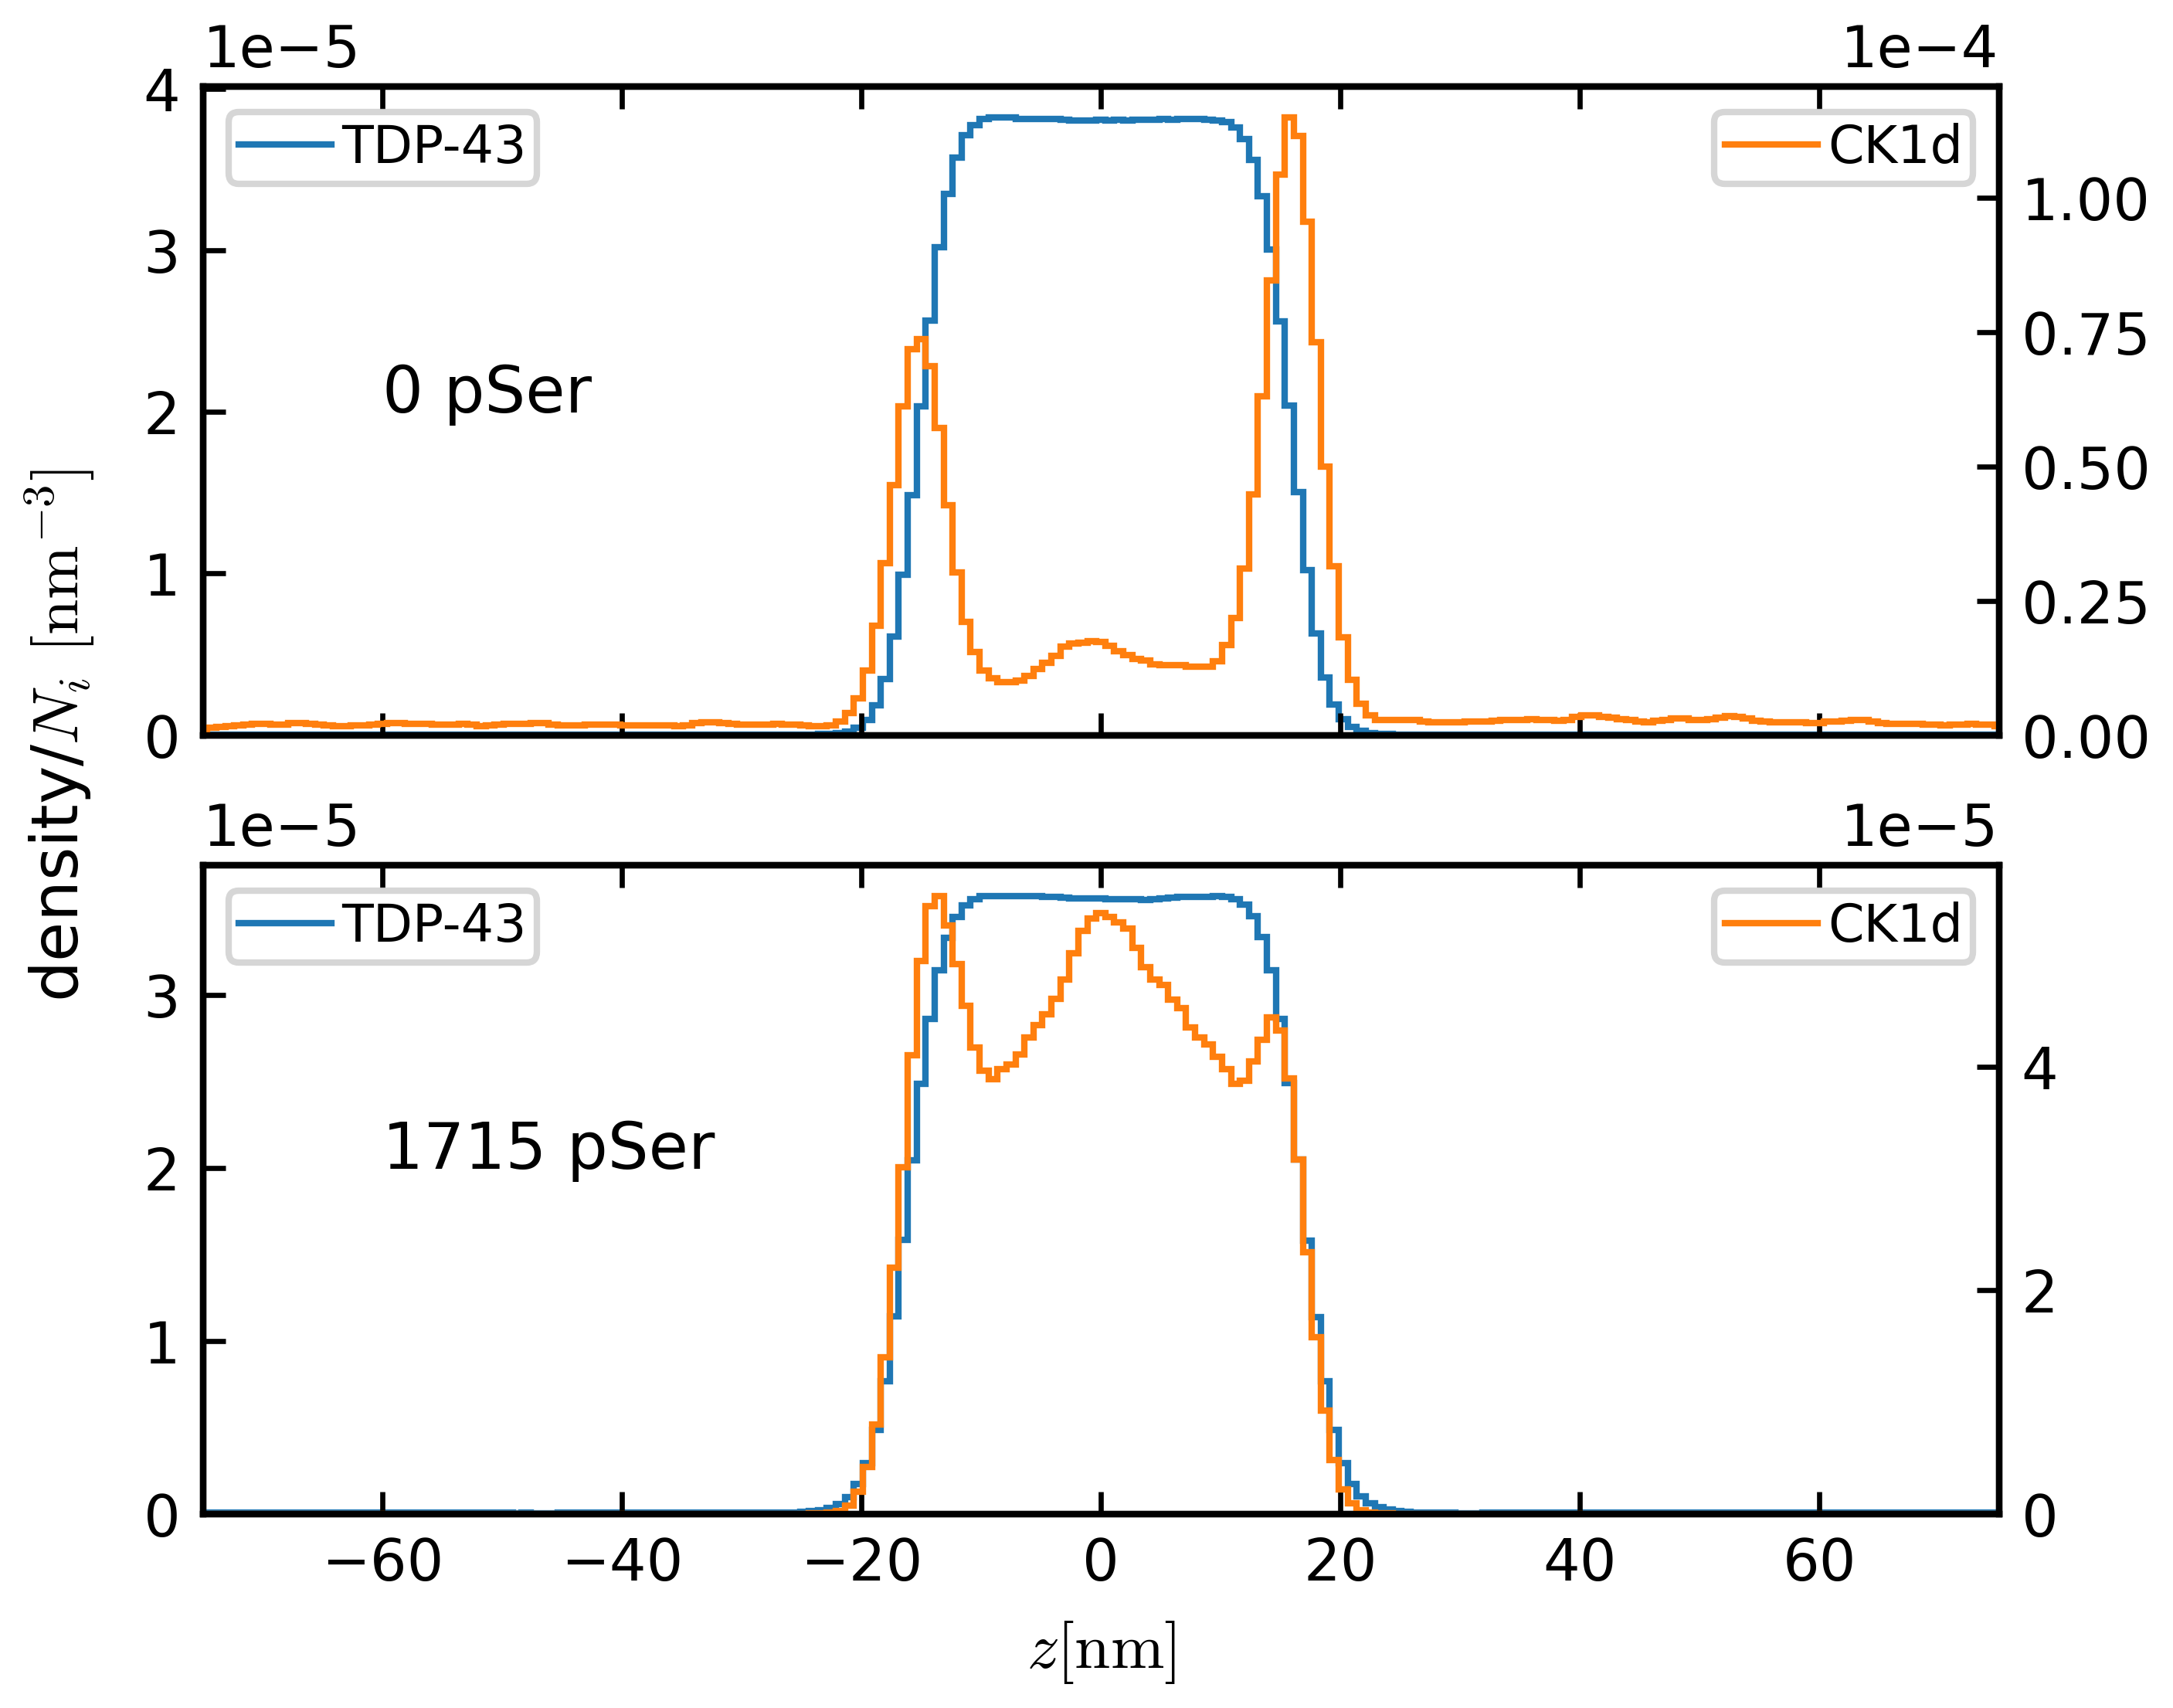

In [26]:
f, (ax1, ax2) = plt.subplots(2, 1, figsize=(5,4), sharex=True)
plt.subplots_adjust(hspace=0.2)
plt.xlim(-75,+75)

ax11 = ax1.twinx()
ax1.stairs(density_tdp_400lcd/200/414, np.append(bin_centers_tdp_400lcd,bin_centers_tdp_400lcd[-1]+0.5), ls='-', color='tab:blue', label='TDP-43')
ax11.stairs(density_ck1d_400lcd/5/292, np.append(bin_centers_ck1d_400lcd,bin_centers_ck1d_400lcd[-1]+0.5), color='tab:orange', label='CK1d')

ax21 = ax2.twinx()
ax2.stairs(density_tdp_400lcd_1715/200/414, np.append(bin_centers_tdp_400lcd_1715,bin_centers_tdp_400lcd_1715[-1]+0.5), ls='-', color='tab:blue', label='TDP-43')
ax21.stairs(density_ck1d_400lcd_1715/5/292, np.append(bin_centers_ck1d_400lcd_1715,bin_centers_ck1d_400lcd_1715[-1]+0.5), ls='-', color='tab:orange', label='CK1d')

ax1.legend(loc='upper left', )
ax2.legend(loc='upper left', )
ax11.legend(loc='upper right', )
ax21.legend(loc='upper right', )

ax2.set_xlabel('$z [\mathrm{nm}]$')
ax1.text(-90, 0., r'density/$N_i$ $[\mathrm{nm}^{-3}]$', va='center', rotation='vertical')

ax1.text(-60, 0.00002, '0 pSer')
ax2.text(-60, 0.00002, '1715 pSer')

filename=path_struct_pl+f'density_profile_400-tdp43-lcd_5-ck1d'
plt.savefig(filename+'.png', dpi=600)
plt.savefig(filename+'.pdf', dpi=600)


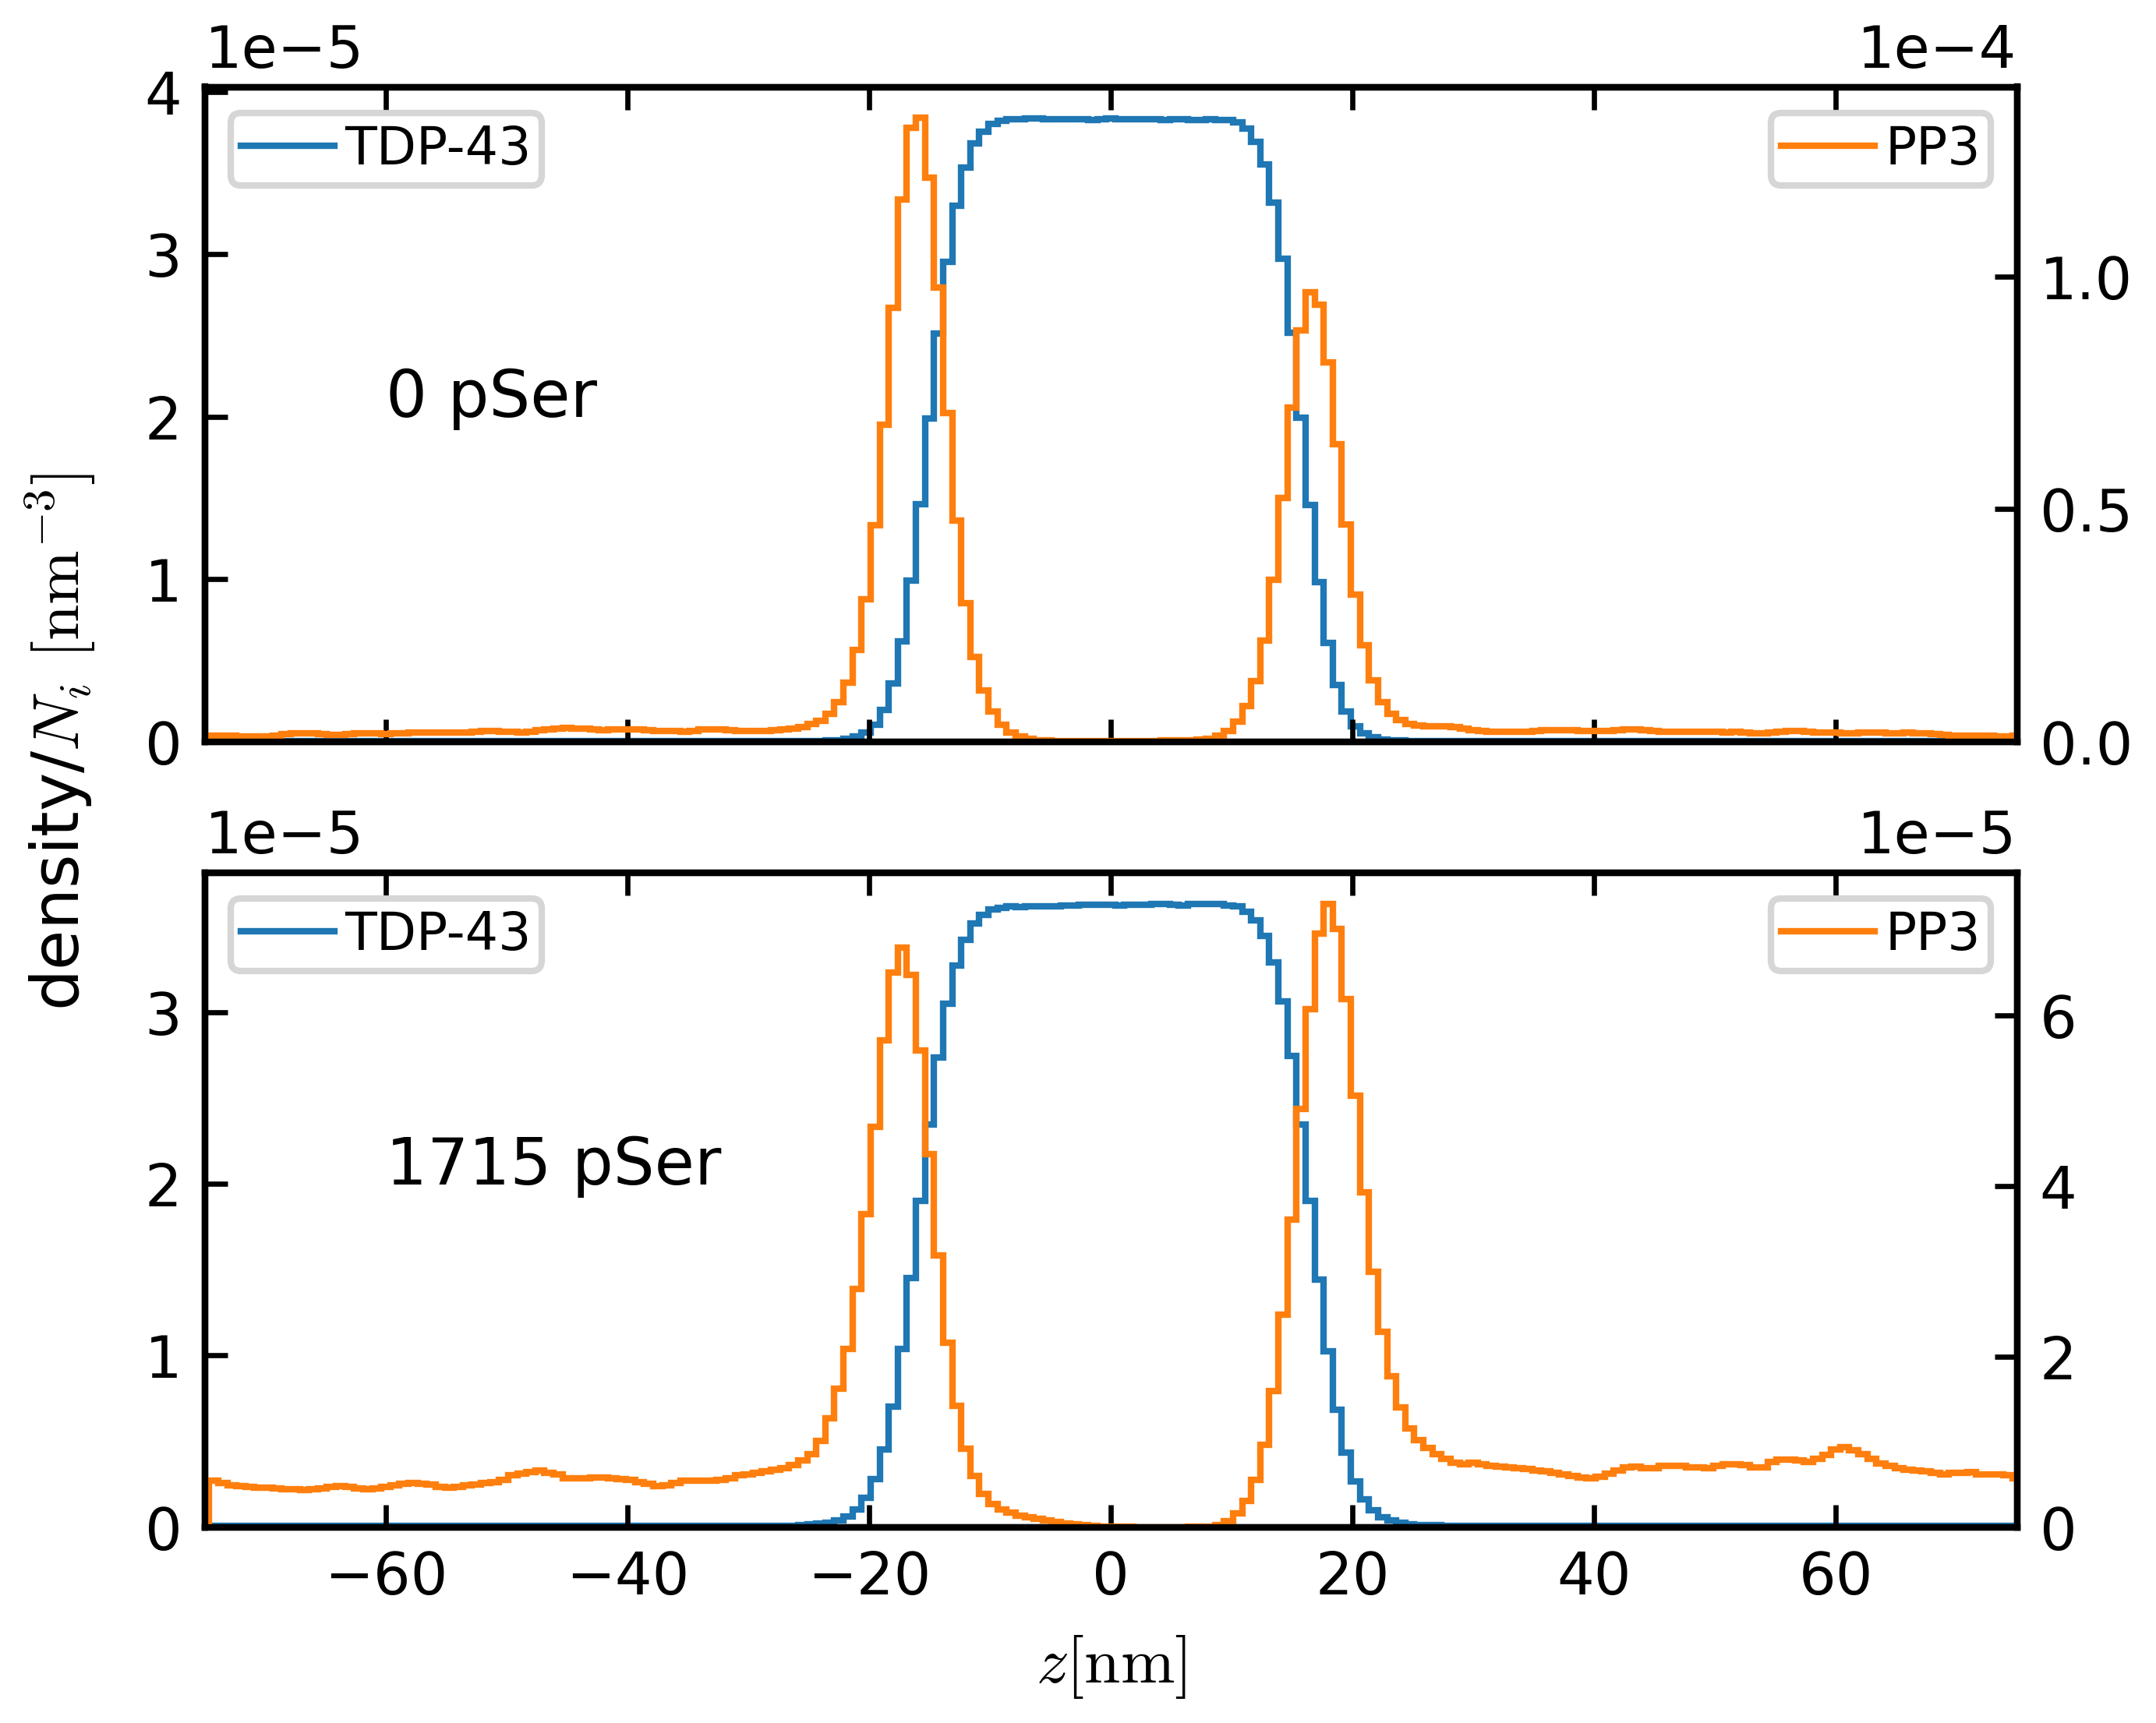

In [27]:
f, (ax1, ax2) = plt.subplots(2, 1, figsize=(5,4), sharex=True)
plt.subplots_adjust(hspace=0.2)
plt.xlim(-75,+75)

ax11 = ax1.twinx()
ax1.stairs(density_tdp_pp3_400lcd/200/414, np.append(bin_centers_tdp_pp3_400lcd,bin_centers_tdp_pp3_400lcd[-1]+0.5), ls='-', color='tab:blue', label='TDP-43')
ax11.stairs(density_pp3_400lcd/5/527, np.append(bin_centers_pp3_400lcd,bin_centers_pp3_400lcd[-1]+0.5), color='tab:orange', label='PP3')

ax21 = ax2.twinx()
ax2.stairs(density_tdp_pp3_400lcd_1715/200/414, np.append(bin_centers_tdp_pp3_400lcd_1715,bin_centers_tdp_pp3_400lcd_1715[-1]+0.5), ls='-', color='tab:blue', label='TDP-43')
ax21.stairs(density_pp3_400lcd_1715/5/527, np.append(bin_centers_pp3_400lcd_1715,bin_centers_pp3_400lcd_1715[-1]+0.5), ls='-', color='tab:orange', label='PP3')

ax1.legend(loc='upper left', )
ax2.legend(loc='upper left', )
ax11.legend(loc='upper right', )
ax21.legend(loc='upper right', )

ax2.set_xlabel('$z [\mathrm{nm}]$')
ax1.text(-90, 0., r'density/$N_i$ $[\mathrm{nm}^{-3}]$', va='center', rotation='vertical')

ax1.text(-60, 0.00002, '0 pSer')
ax2.text(-60, 0.00002, '1715 pSer')

filename=path_struct_pl+f'density_profile_400-tdp43-lcd_5-pp3'
plt.savefig(filename+'.png', dpi=600)
plt.savefig(filename+'.pdf', dpi=600)


#### TDP-43 species arrangement

In [29]:
filename = 'sim_eq_slab_150-full-tdp43/sim_eq_slab_150-full-tdp43_CAL3_dump_centered.gsd'

bin_centers_nt, density_nt = hpau.compute_density_profile(path_struct+filename, axis=2, 
                                                         nbins=200, group=[i+414*j for j in range(0,150) for i in range(0,260) ], therm=100)
#bin_centers_pp3, density_pp3 = hpau.compute_density_profile(path_dir+filename, axis=2, 
#                                                         nbins=200, group=[i for i in range(30800+292+292,36654)])
bin_centers_ct, density_ct = hpau.compute_density_profile(path_struct+filename, axis=2, 
                                                         nbins=200, group=[i+414*j for j in range(0,150) for i in range(260,414) ], therm=100)


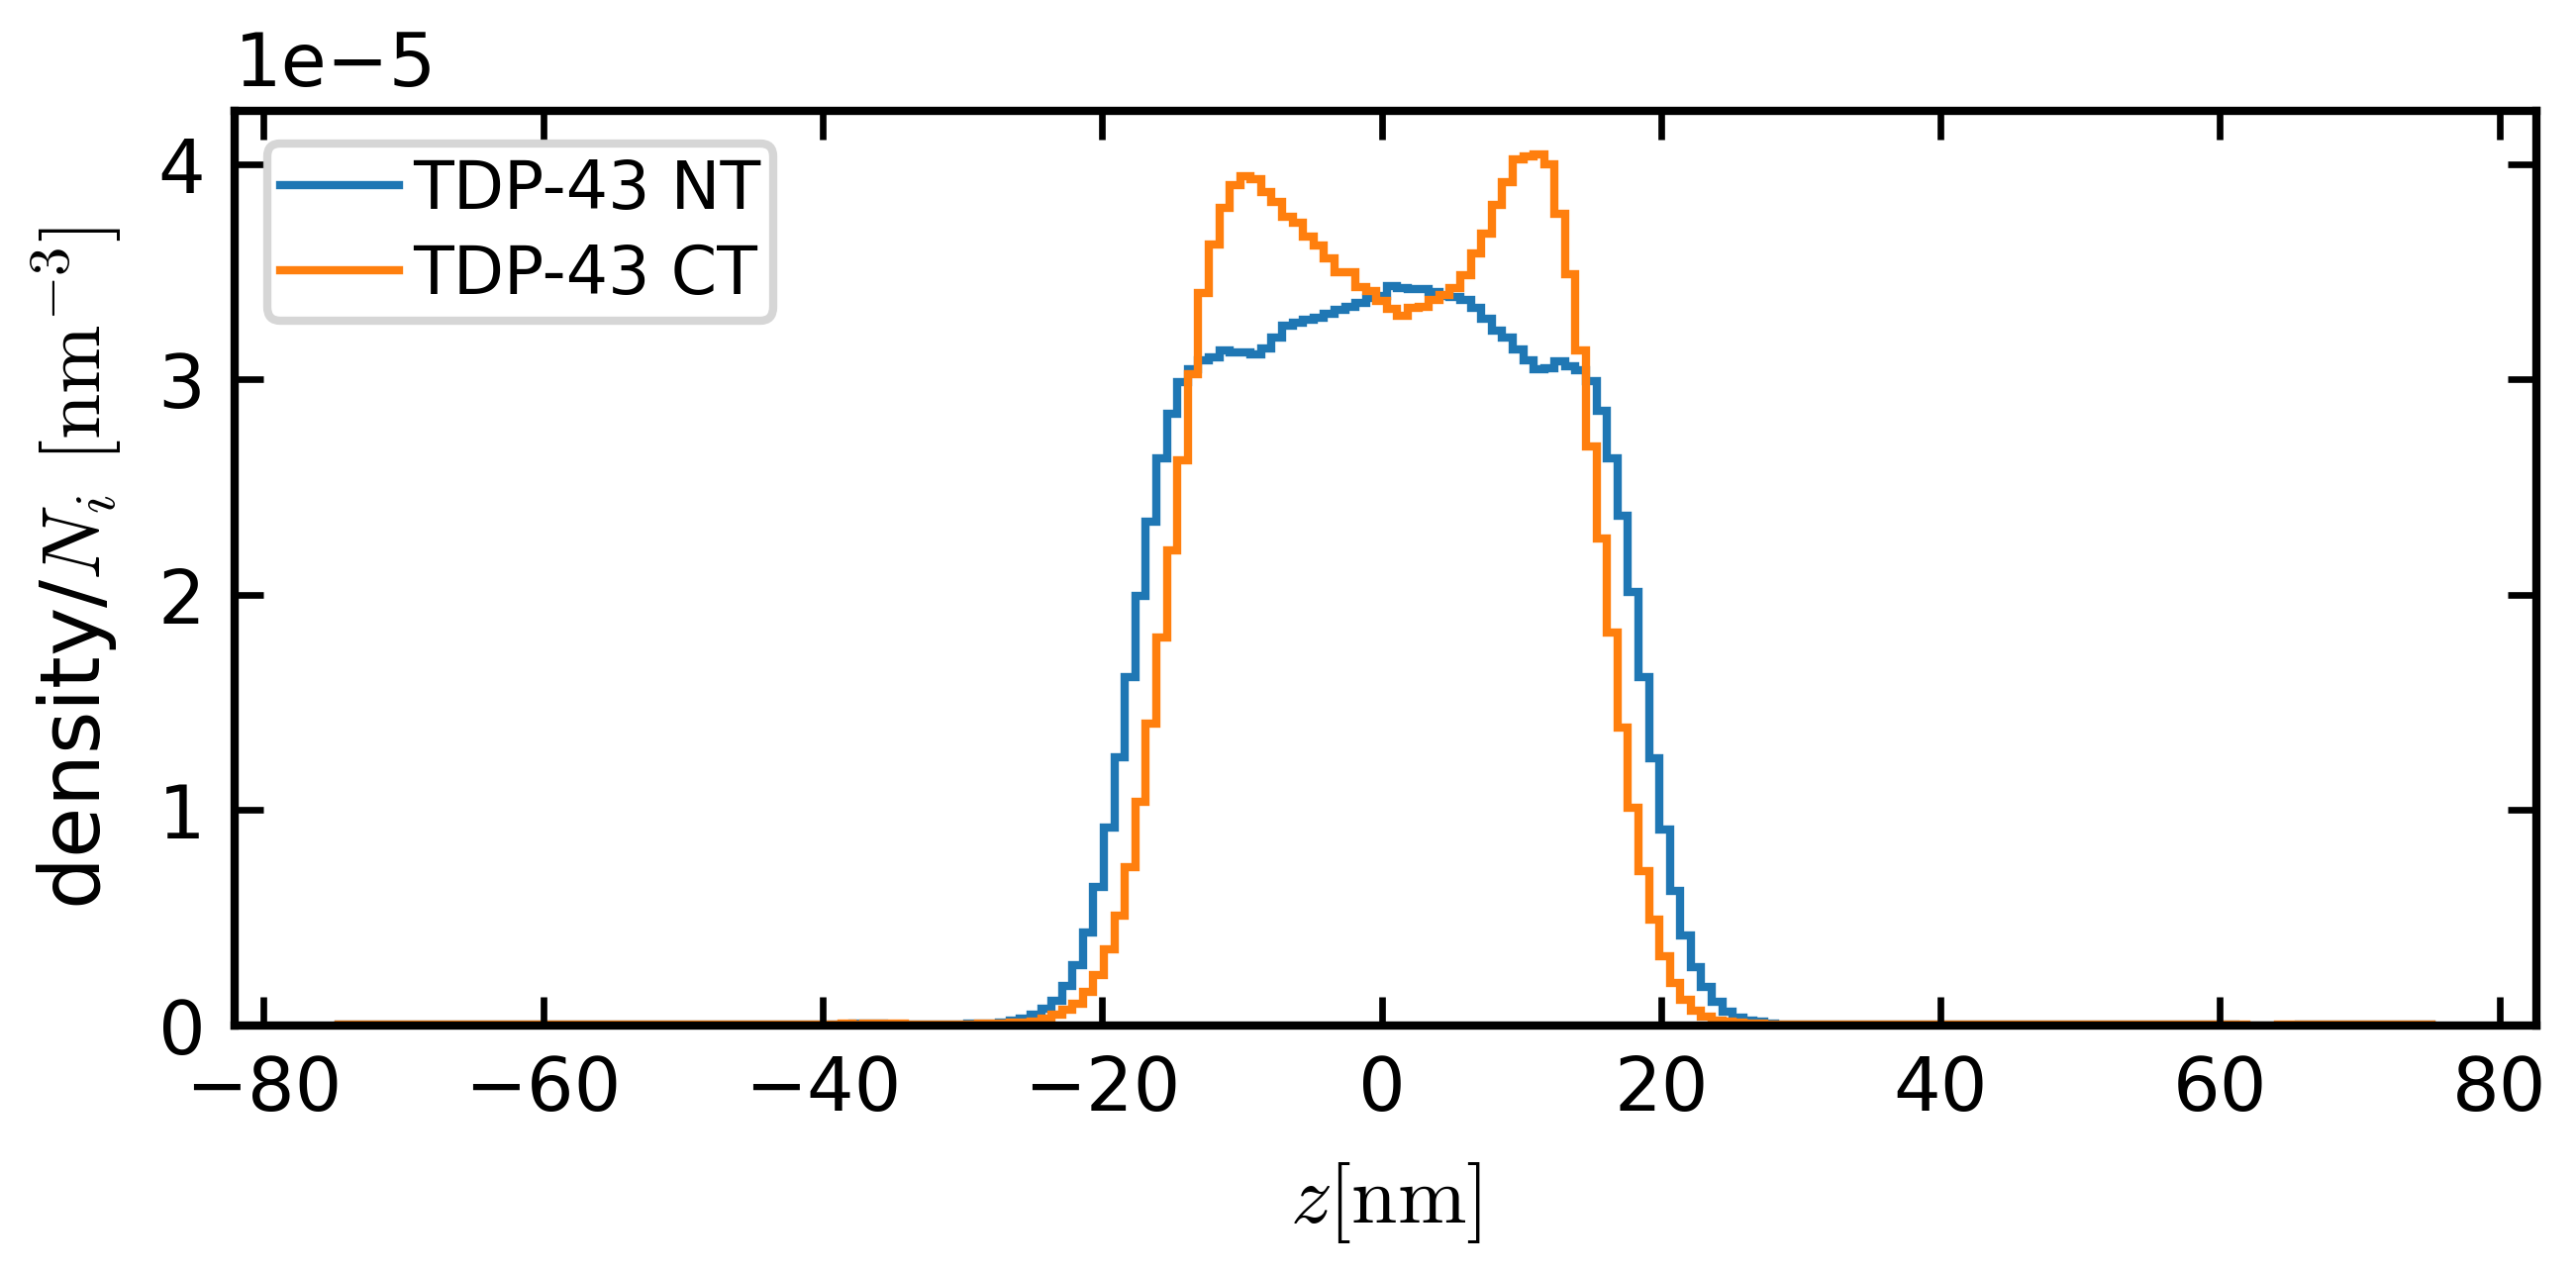

In [41]:
f, ax1 = plt.subplots(1, 1, figsize=(5,2), sharex=True)

ax1.stairs(density_nt/200/260, np.append(bin_centers_nt,bin_centers_nt[-1]+0.5), ls='-', color='tab:blue', label='TDP-43 NT')
ax1.stairs(density_ct/200/154, np.append(bin_centers_ct,bin_centers_ct[-1]+0.5), color='tab:orange', label='TDP-43 CT')

ax1.legend(loc='upper left', )

ax1.set_xlabel('$z [\mathrm{nm}]$')
ax1.set_ylabel(r'density/$N_i$ $[\mathrm{nm}^{-3}]$')

filename=path_struct_pl+f'density_profile_NT_CT_150-full-tdp43'
plt.savefig(filename+'.png', dpi=600)
plt.savefig(filename+'.pdf', dpi=600)

In [28]:
filename = 'sim_eq_400-tdp43-lcd_slab/sim_eq_400-tdp43-lcd-2301pser_CAL3_slab_dump_centered.gsd'

bin_centers, densities_by_pser, chain_counts = hpau.compute_density_profile_by_npSer(path_struct+filename, n_chains=400, beads_per_chain=154, 
                                                                       axis=2, nbins=200, therm=100)


/localscratch/zippoema/lib/python_envs/hpa_env/lib/python3.11/site-packages/gsd/hoomd.py:1125: FutureWarning: The 'rb' mode is deprecated, use 'r'
  gsdfileobj = fl.open(name=str(name),
Computing density profiles: 100%|███████████████████████████████████| 500/500 [00:00<00:00, 1377.12it/s]


/tmp/ipykernel_3430250/3975240226.py:87: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = cm.get_cmap(cmap)(np.linspace(0, 1, len(classes)))


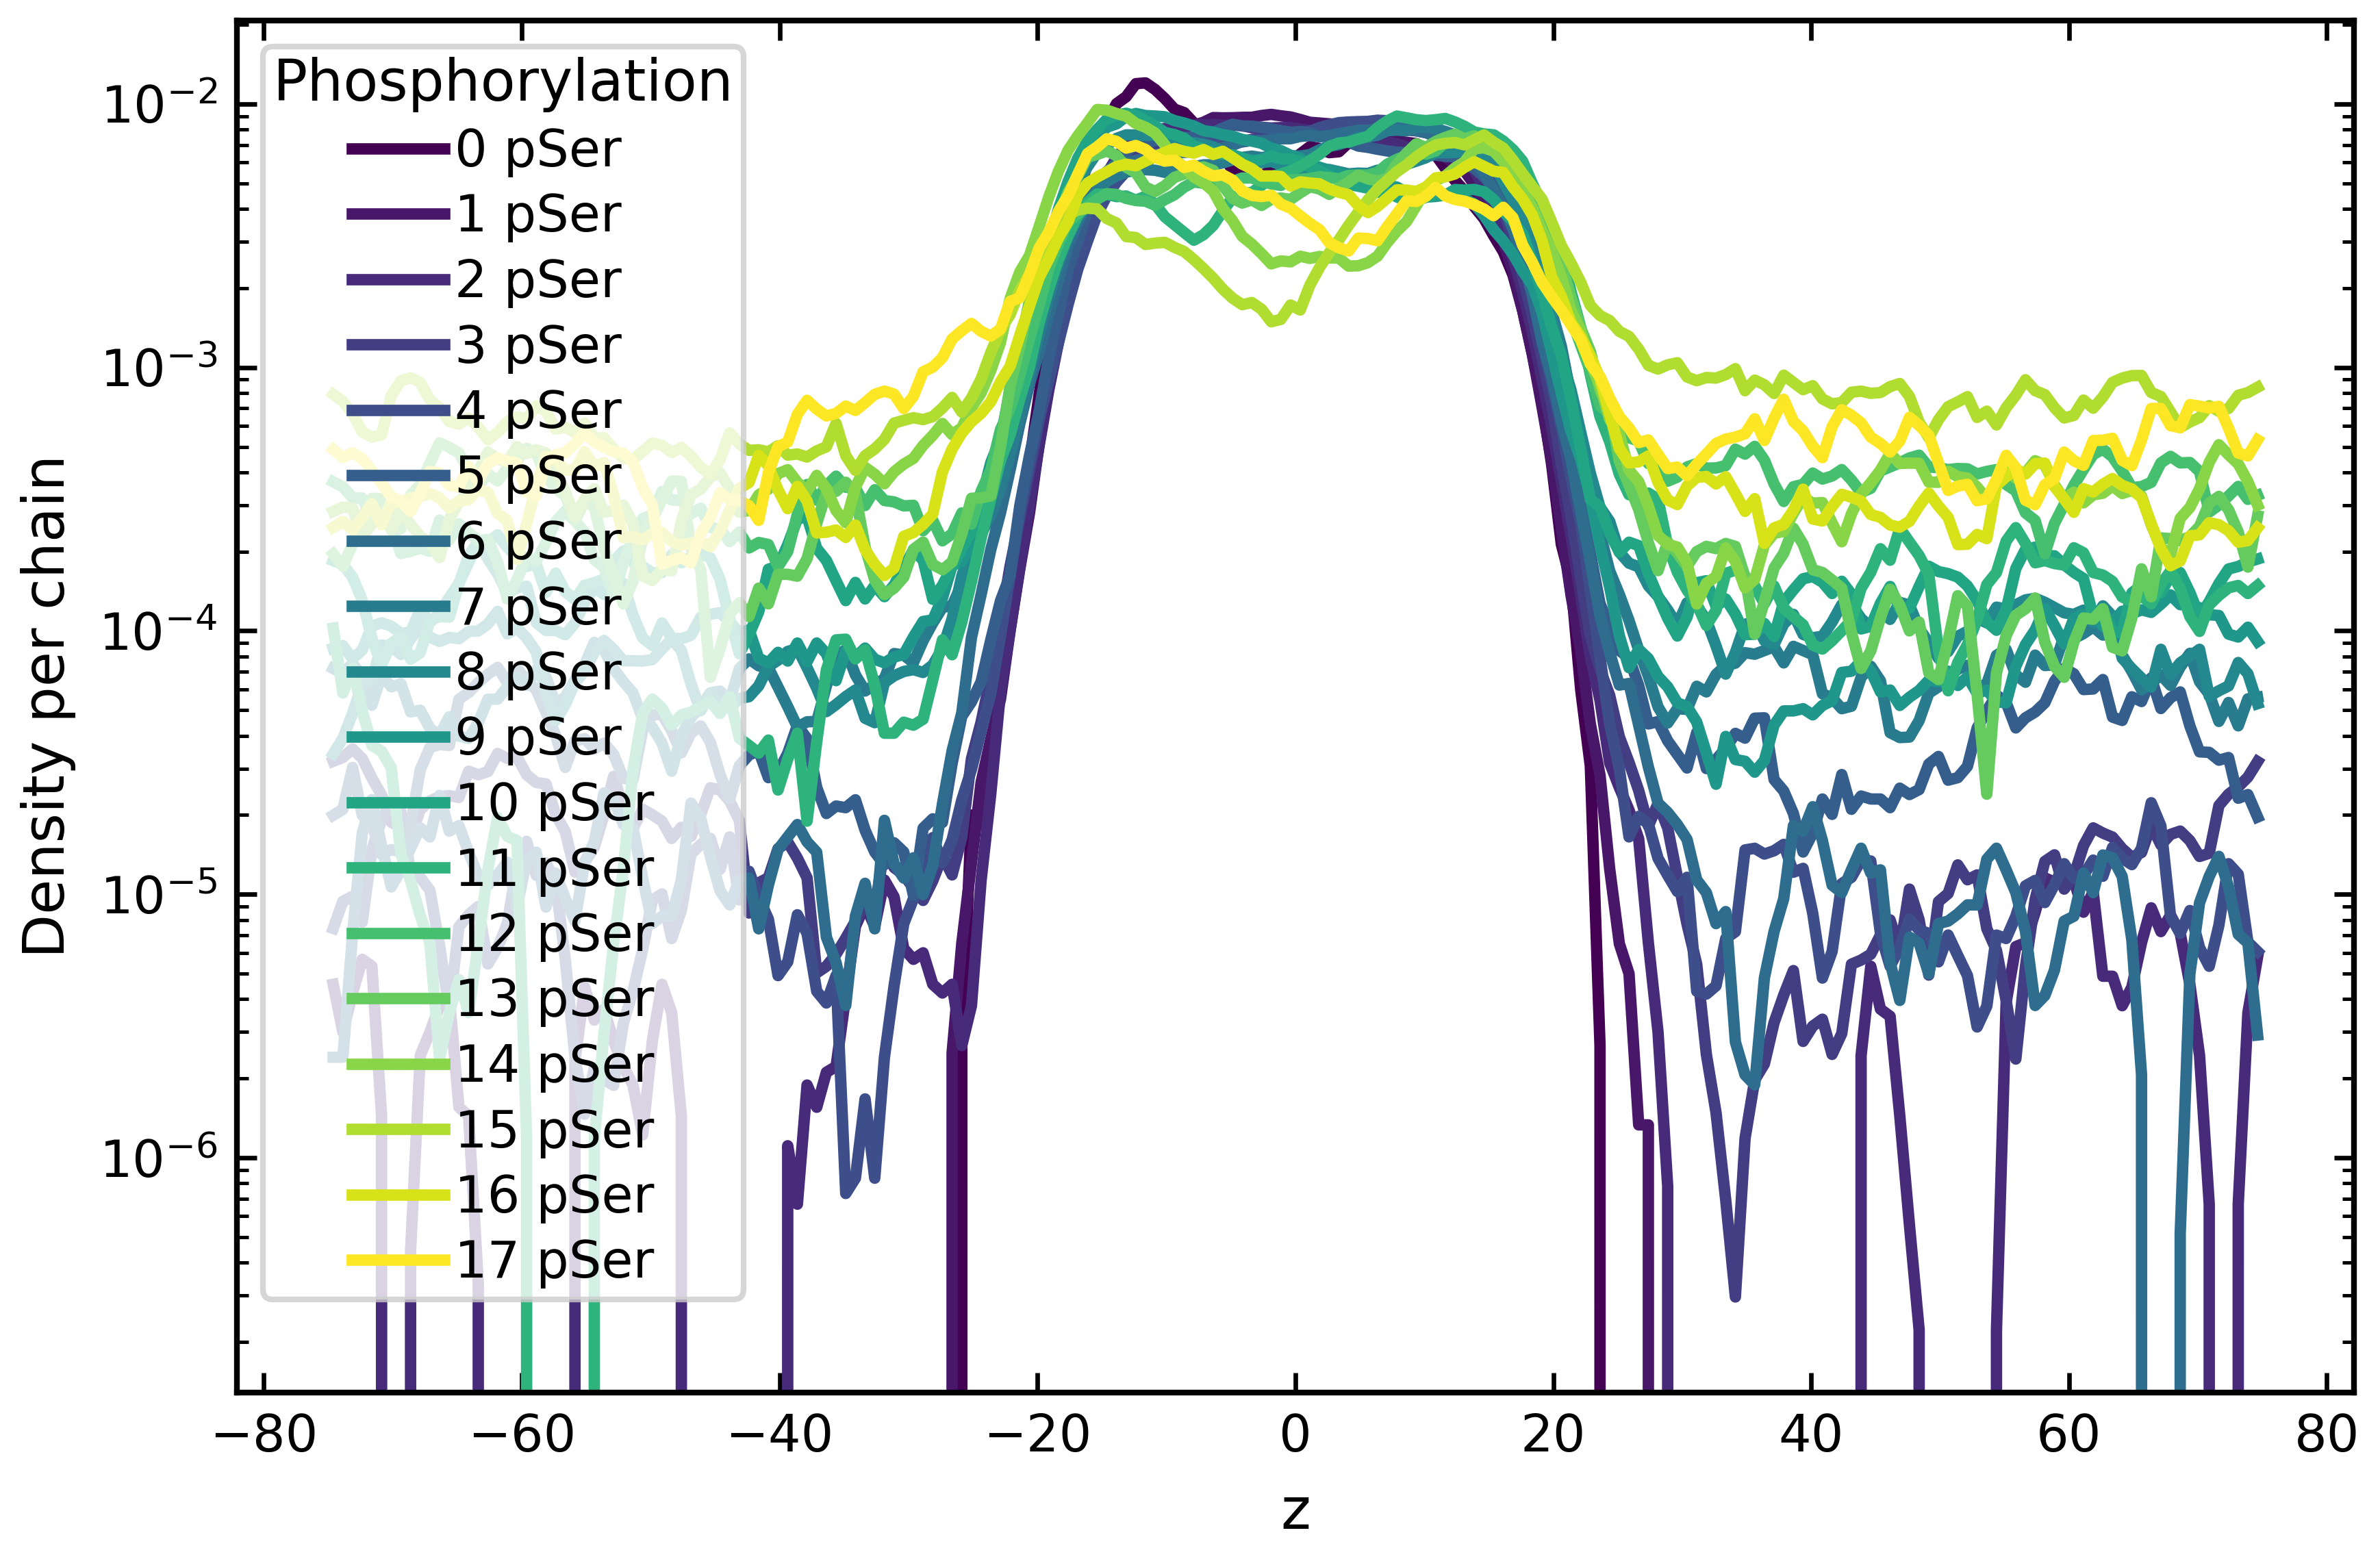

In [32]:
plot_radial_density_profiles_by_npSer(bin_centers, densities_by_pser,
    chain_counts, logscale=True, radial=False)  


/tmp/ipykernel_3474496/3975240226.py:72: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = cm.get_cmap(cmap)(np.linspace(0, 1, len(labels)))


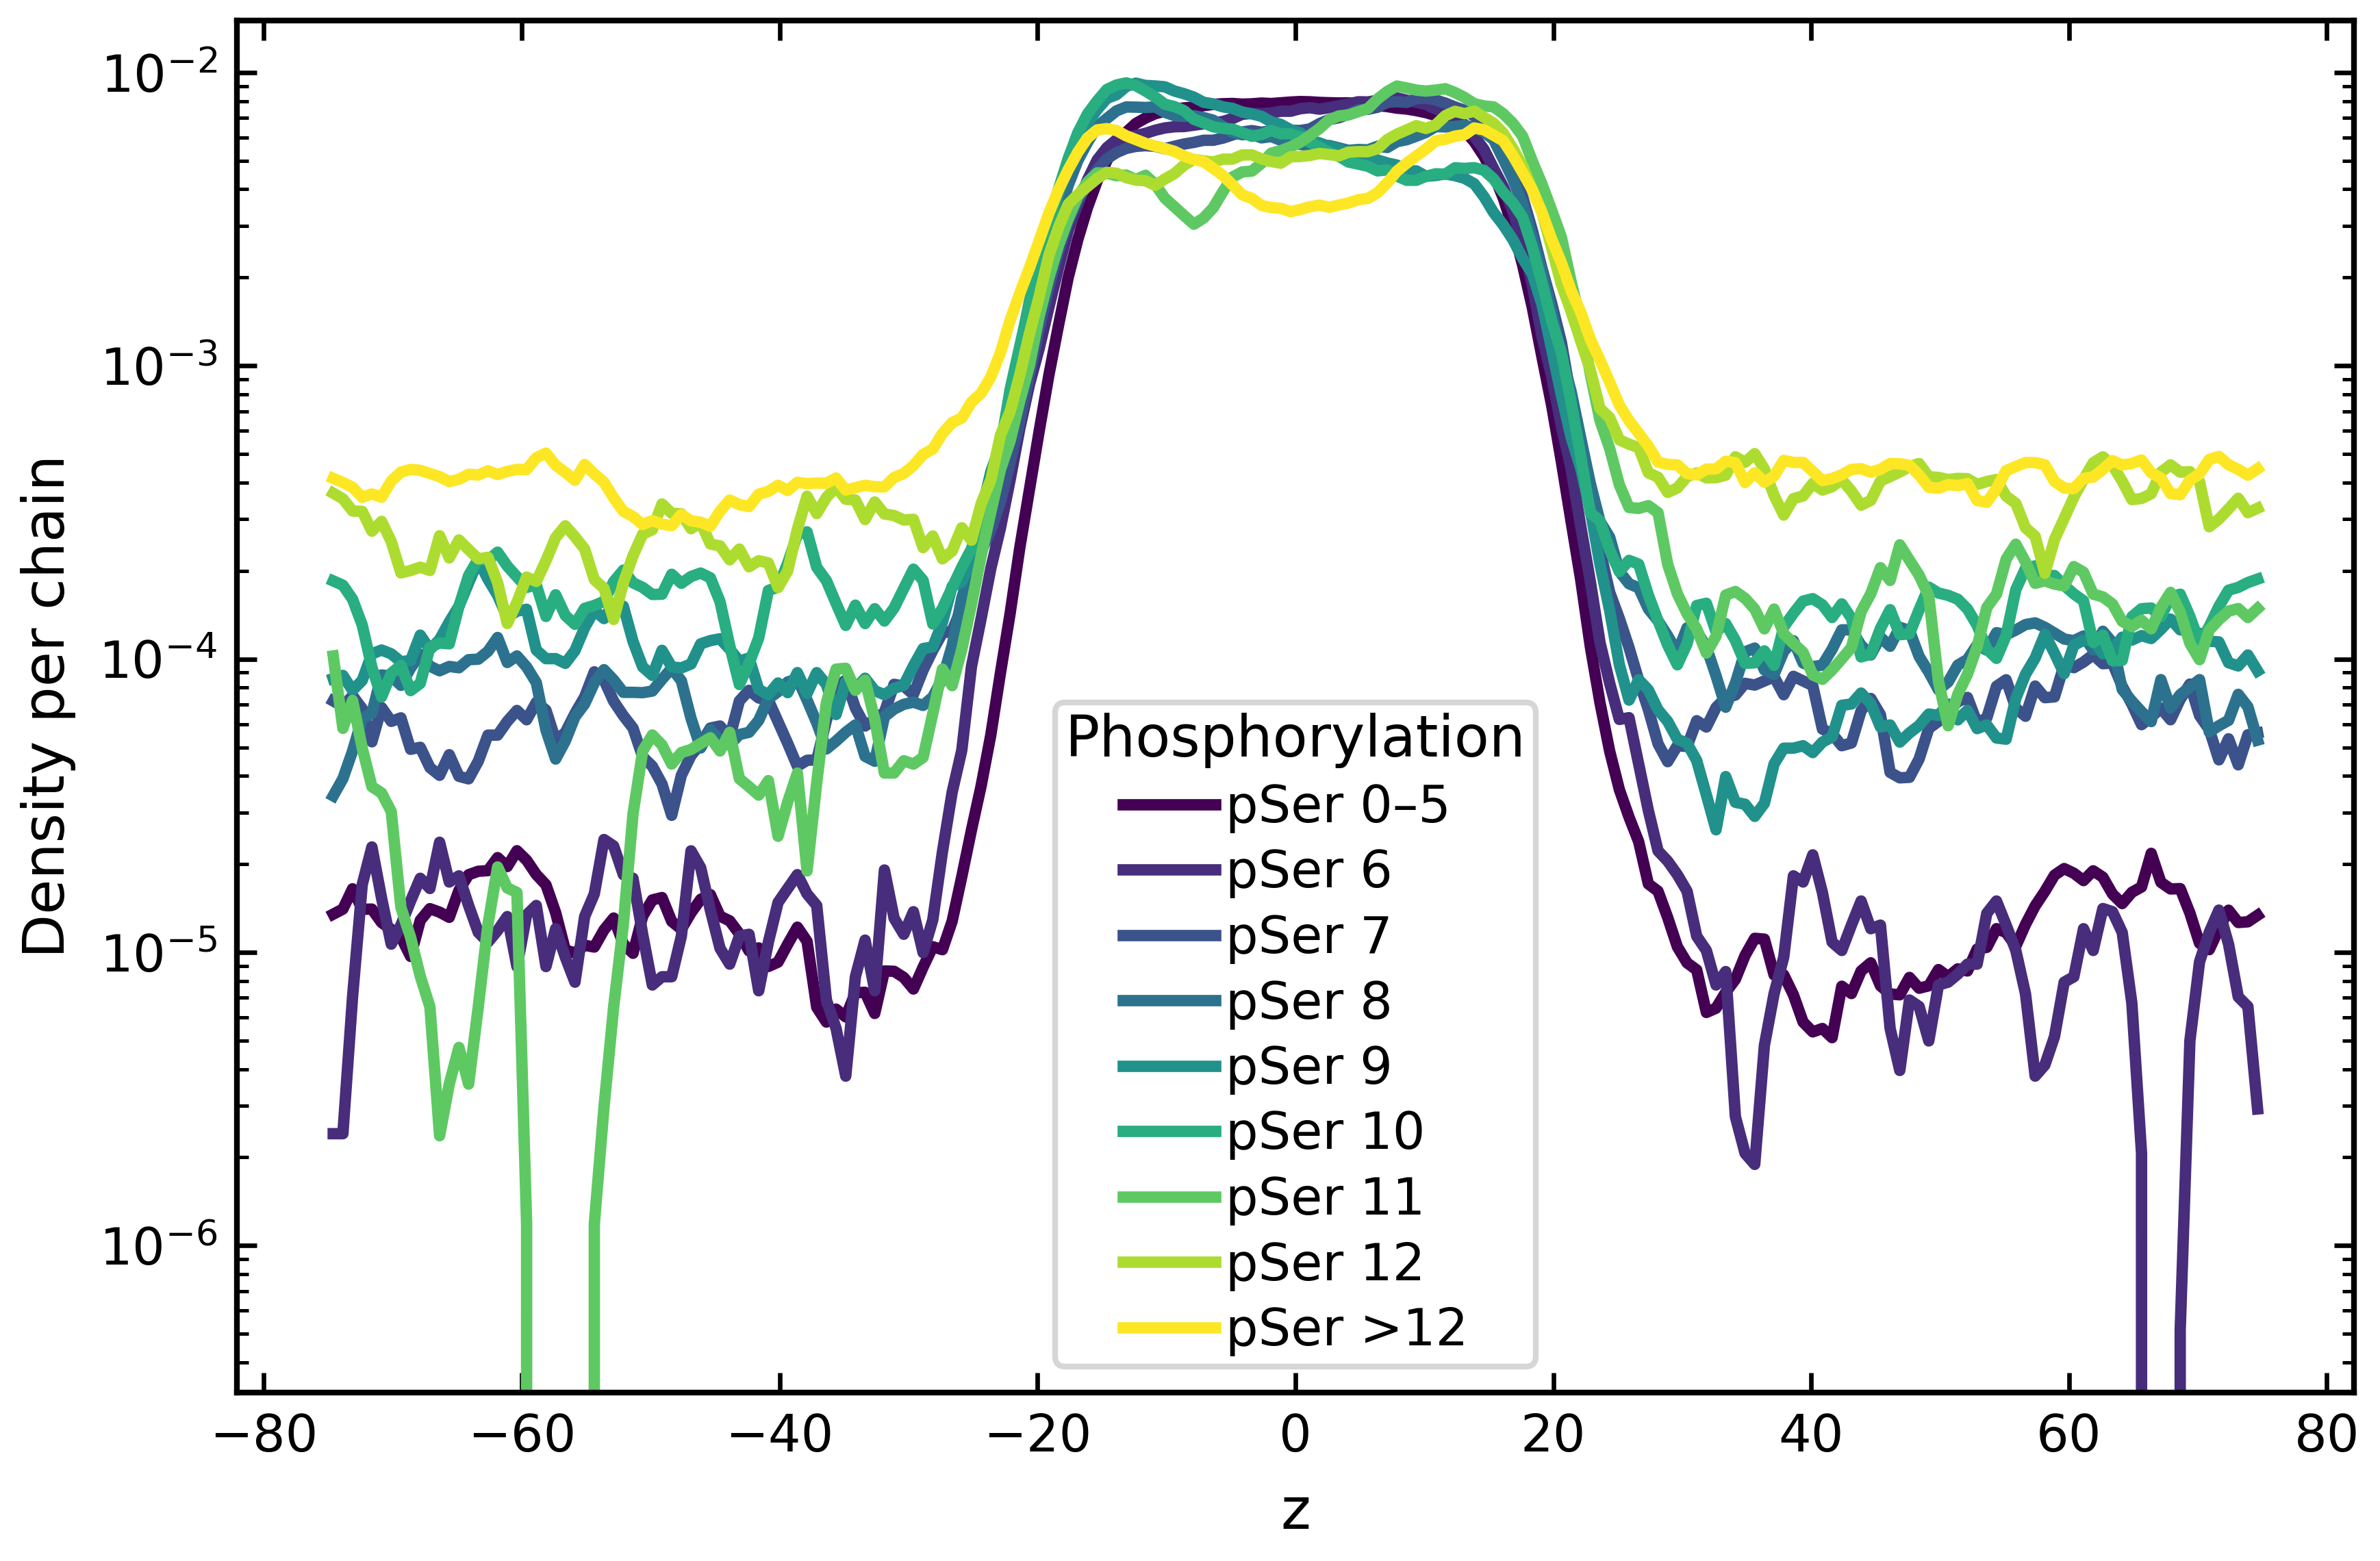

In [30]:
groups = {
    "pSer 0–5": lambda x: 0 <= x <= 5,
    "pSer 6": lambda x: x == 6,
    "pSer 7": lambda x: x == 7,
    "pSer 8": lambda x: x == 8,
    "pSer 9": lambda x: x == 9,
    "pSer 10": lambda x: x == 10,
    "pSer 11": lambda x: x == 11,
    "pSer 12": lambda x: x == 12,
    "pSer >12": lambda x: x > 12
}


plot_radial_density_profiles_by_npSer(bin_centers, densities_by_pser,
    chain_counts, logscale=True, radial=False, groups=groups, save=path_struct_pl+"density_z_by_npSer_400-tdp43-lcd-2301pSer_slab_log")  


### N_pser per chain in dilute

In [44]:
tstep = 50
times_dis = np.arange(0,1550, tstep)

npdil_5ck1d_list, npdil_5ck1d, dpdil_5ck1d, nchainsdil_5ck1d = hpacl.pSer_dilute(path_drop+f'sim_200-tdp43-lcd_5-ck1d-open/sim1_200-tdp43-lcd_5-com-ck1d-open_CAL3_dump_centered.gsd',
                                                                           times_dis, eps=1.0, min_sample=2)


/localscratch/zippoema/lib/python_envs/hpa_env/lib/python3.11/site-packages/gsd/hoomd.py:1125: FutureWarning: The 'rb' mode is deprecated, use 'r'
  gsdfileobj = fl.open(name=str(name),


2500


  0%|                                                                            | 0/31 [00:00<?, ?it/s]

0


  6%|████▍                                                               | 2/31 [00:00<00:05,  5.75it/s]

n chains dilute: 18
50
n chains dilute: 19
100


 13%|████████▊                                                           | 4/31 [00:00<00:03,  7.10it/s]

n chains dilute: 22
150
n chains dilute: 23
200


 19%|█████████████▏                                                      | 6/31 [00:00<00:03,  7.47it/s]

n chains dilute: 31
250
n chains dilute: 20
300


 26%|█████████████████▌                                                  | 8/31 [00:01<00:03,  7.66it/s]

n chains dilute: 21
350
n chains dilute: 12
400


 32%|█████████████████████▌                                             | 10/31 [00:01<00:02,  7.70it/s]

n chains dilute: 15
450
n chains dilute: 18
500


 39%|█████████████████████████▉                                         | 12/31 [00:01<00:02,  7.72it/s]

n chains dilute: 30
550
n chains dilute: 22
600


 45%|██████████████████████████████▎                                    | 14/31 [00:01<00:02,  7.08it/s]

n chains dilute: 29
650
n chains dilute: 28
700


 52%|██████████████████████████████████▌                                | 16/31 [00:02<00:01,  7.65it/s]

n chains dilute: 34
750
n chains dilute: 45
800


 58%|██████████████████████████████████████▉                            | 18/31 [00:02<00:01,  7.93it/s]

n chains dilute: 53
850
n chains dilute: 50
900


 65%|███████████████████████████████████████████▏                       | 20/31 [00:02<00:01,  8.32it/s]

n chains dilute: 52
950
n chains dilute: 72
1000


 71%|███████████████████████████████████████████████▌                   | 22/31 [00:02<00:01,  8.58it/s]

n chains dilute: 90
1050
n chains dilute: 97
1100


 77%|███████████████████████████████████████████████████▊               | 24/31 [00:03<00:00,  8.92it/s]

n chains dilute: 122
1150
n chains dilute: 138
1200


 84%|████████████████████████████████████████████████████████▏          | 26/31 [00:03<00:00,  8.94it/s]

n chains dilute: 152
1250
n chains dilute: 147
1300


 94%|██████████████████████████████████████████████████████████████▋    | 29/31 [00:03<00:00, 10.08it/s]

n chains dilute: 184
1350
n chains dilute: 189
1400
n chains dilute: 193
1450


100%|███████████████████████████████████████████████████████████████████| 31/31 [00:03<00:00,  8.19it/s]

n chains dilute: 189
1500
n chains dilute: 186


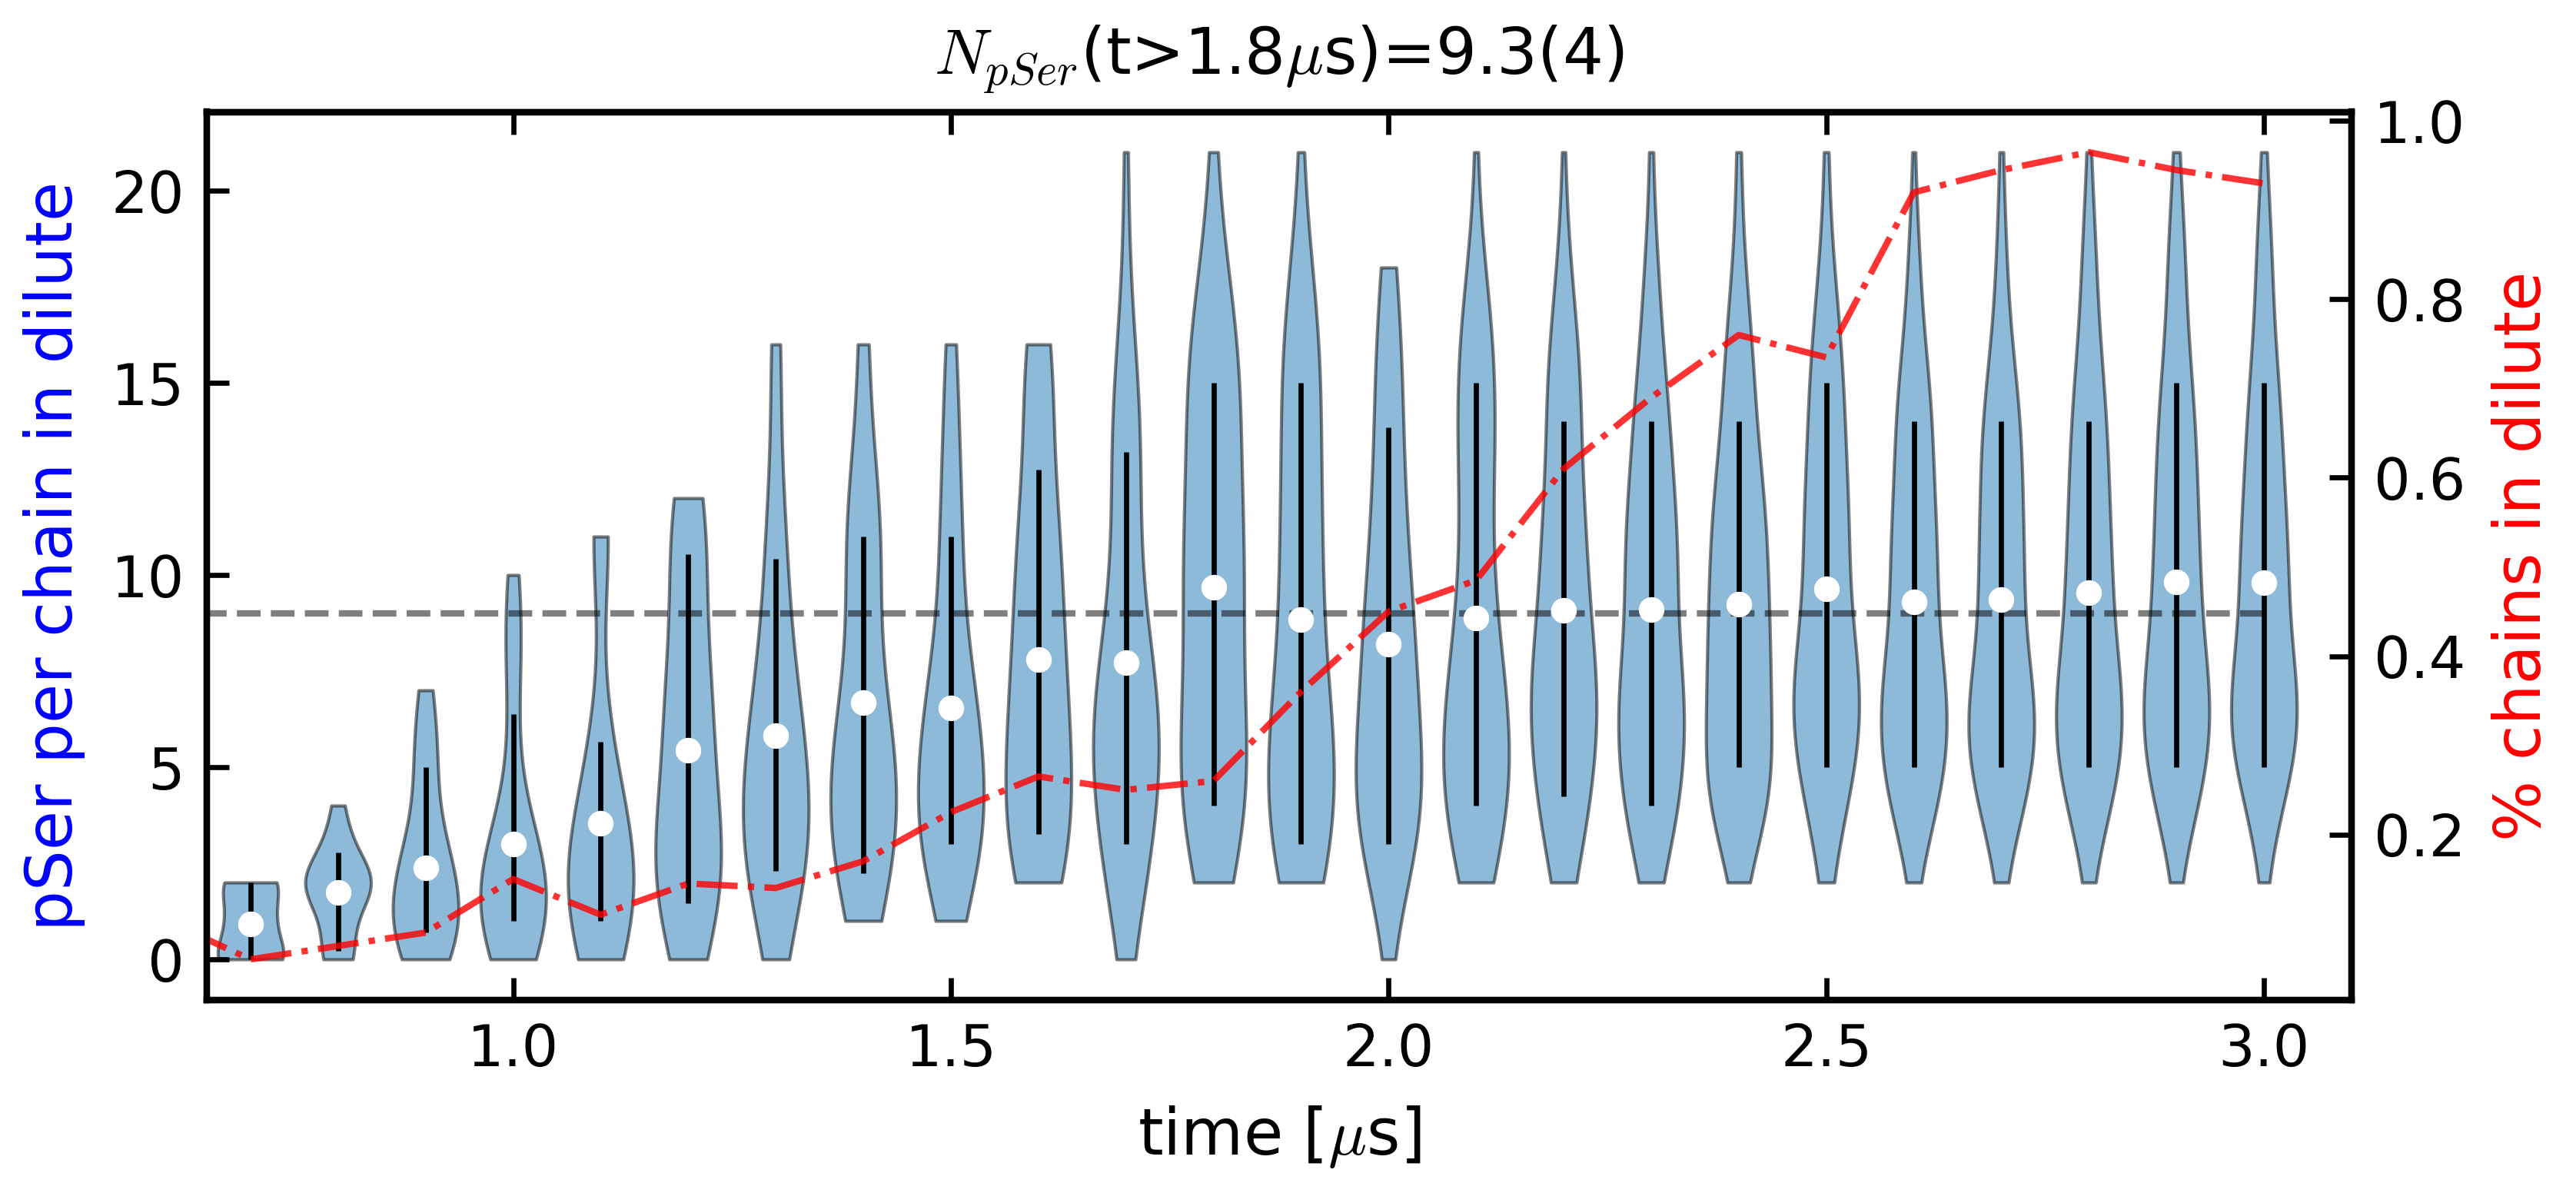

In [45]:
time_step_dis = times_dis*200000

def adjacent_values(vals, q1, q3):
    upper_adjacent_value = q3 + (q3 - q1) * 1.5
    upper_adjacent_value = np.clip(upper_adjacent_value, q3, vals[-1])

    lower_adjacent_value = q1 - (q3 - q1) * 1.5
    lower_adjacent_value = np.clip(lower_adjacent_value, vals[0], q1)
    return lower_adjacent_value, upper_adjacent_value

fig, ax1 = plt.subplots(figsize=(6, 2.5))
 
# Plot the first array with the primary y-axis
data = npdil_5ck1d_list # [5::2]
parts = ax1.violinplot(
        data, widths=0.75, 
        showmeans=False, showmedians=False, showextrema=False)

for pc in parts['bodies']:
    pc.set_facecolor('tab:blue')
    pc.set_edgecolor('black')
    pc.set_alpha(0.5)
    pc.set_lw(0.5)

percentile1 = [ np.percentile(data[i], 15.9) for i in range(len(data)) ]
percentile3 = [ np.percentile(data[i], 84.1) for i in range(len(data)) ]

inds = np.arange(1, len(data)+1)
ax1.vlines(inds, percentile1, percentile3, color='k', linestyle='-', lw=0.8)
ax1.scatter(inds, npdil_5ck1d, marker='o', color='white', zorder=3)
ax1.plot(inds, inds*0+9, ls='--', c='k', alpha=0.5)

ax1.set_xlabel('time [$\mu$s]')
ax1.set_ylabel('pSer per chain in dilute', color='b')
ax1.set_xticks(np.array([5,10,15,20,25,30])+1, np.array([5,10,15,20,25,30])*tstep*2/1e3)

# Create a secondary y-axis and plot the second array
ax2 = ax1.twinx()
ax2.plot(inds, nchainsdil_5ck1d/200, 'r-.', alpha=0.8)
ax2.set_ylabel('% chains in dilute', color='r')

plt.xlim(7.5,32)
plt.title(r'$N_{pSer}$(t>1.8$\mu$s)='+f'{np.mean(npdil_5ck1d[-13:]):.1f}({np.std(npdil_5ck1d[-13:])*10:.0f})', fontsize=10)

filename=path_drop_pl+'npser_per_chain_dilute_200-tdp43-lcd_5-ck1d-open'
plt.savefig(filename+'.png', dpi=600)
plt.savefig(filename+'.pdf', dpi=600)


### N_pser per chain in condensate

In [46]:
tstep = 50
times_dis = np.arange(0,1550, tstep)

npcond_5ck1d_list, npcond_5ck1d, dpcond_5ck1d, nchainscond_5ck1d = hpacl.pSer_condensate(path_drop+f'sim_200-tdp43-lcd_5-ck1d-open/sim1_200-tdp43-lcd_5-com-ck1d-open_CAL3_dump_centered.gsd',
                                                                           times_dis, ntdp43=200, len_tdp43=154, eps=1.0, min_sample=2)


/localscratch/zippoema/lib/python_envs/hpa_env/lib/python3.11/site-packages/gsd/hoomd.py:1125: FutureWarning: The 'rb' mode is deprecated, use 'r'
  gsdfileobj = fl.open(name=str(name),


2500


  3%|██▏                                                                 | 1/31 [00:00<00:03,  9.00it/s]

0
n chains dilute: 182
50


 10%|██████▌                                                             | 3/31 [00:00<00:02,  9.44it/s]

n chains dilute: 181
100
n chains dilute: 178
150


 16%|██████████▉                                                         | 5/31 [00:00<00:02,  9.57it/s]

n chains dilute: 177
200
n chains dilute: 169
250


 23%|███████████████▎                                                    | 7/31 [00:00<00:02,  9.52it/s]

n chains dilute: 180
300
n chains dilute: 179
350


 29%|███████████████████▋                                                | 9/31 [00:00<00:02,  9.35it/s]

n chains dilute: 188
400
n chains dilute: 185
450


 35%|███████████████████████▊                                           | 11/31 [00:01<00:02,  9.37it/s]

n chains dilute: 182
500
n chains dilute: 170
550


 42%|████████████████████████████                                       | 13/31 [00:01<00:01,  9.49it/s]

n chains dilute: 178
600
n chains dilute: 171
650


 48%|████████████████████████████████▍                                  | 15/31 [00:01<00:01,  9.59it/s]

n chains dilute: 172
700
n chains dilute: 166
750


 58%|██████████████████████████████████████▉                            | 18/31 [00:01<00:01,  9.89it/s]

n chains dilute: 155
800
n chains dilute: 147
850
n chains dilute: 150
900


 68%|█████████████████████████████████████████████▍                     | 21/31 [00:02<00:00, 10.19it/s]

n chains dilute: 148
950
n chains dilute: 128
1000
n chains dilute: 110
1050


 74%|█████████████████████████████████████████████████▋                 | 23/31 [00:02<00:00, 10.61it/s]

n chains dilute: 103
1100
n chains dilute: 78
1150
n chains dilute: 62
1200


 87%|██████████████████████████████████████████████████████████▎        | 27/31 [00:02<00:00, 11.63it/s]

n chains dilute: 48
1250
n chains dilute: 53
1300
n chains dilute: 16
1350


 94%|██████████████████████████████████████████████████████████████▋    | 29/31 [00:02<00:00, 12.19it/s]

n chains dilute: 11
1400
n chains dilute: 7
1450
n chains dilute: 11
1500


100%|███████████████████████████████████████████████████████████████████| 31/31 [00:02<00:00, 10.46it/s]

n chains dilute: 14


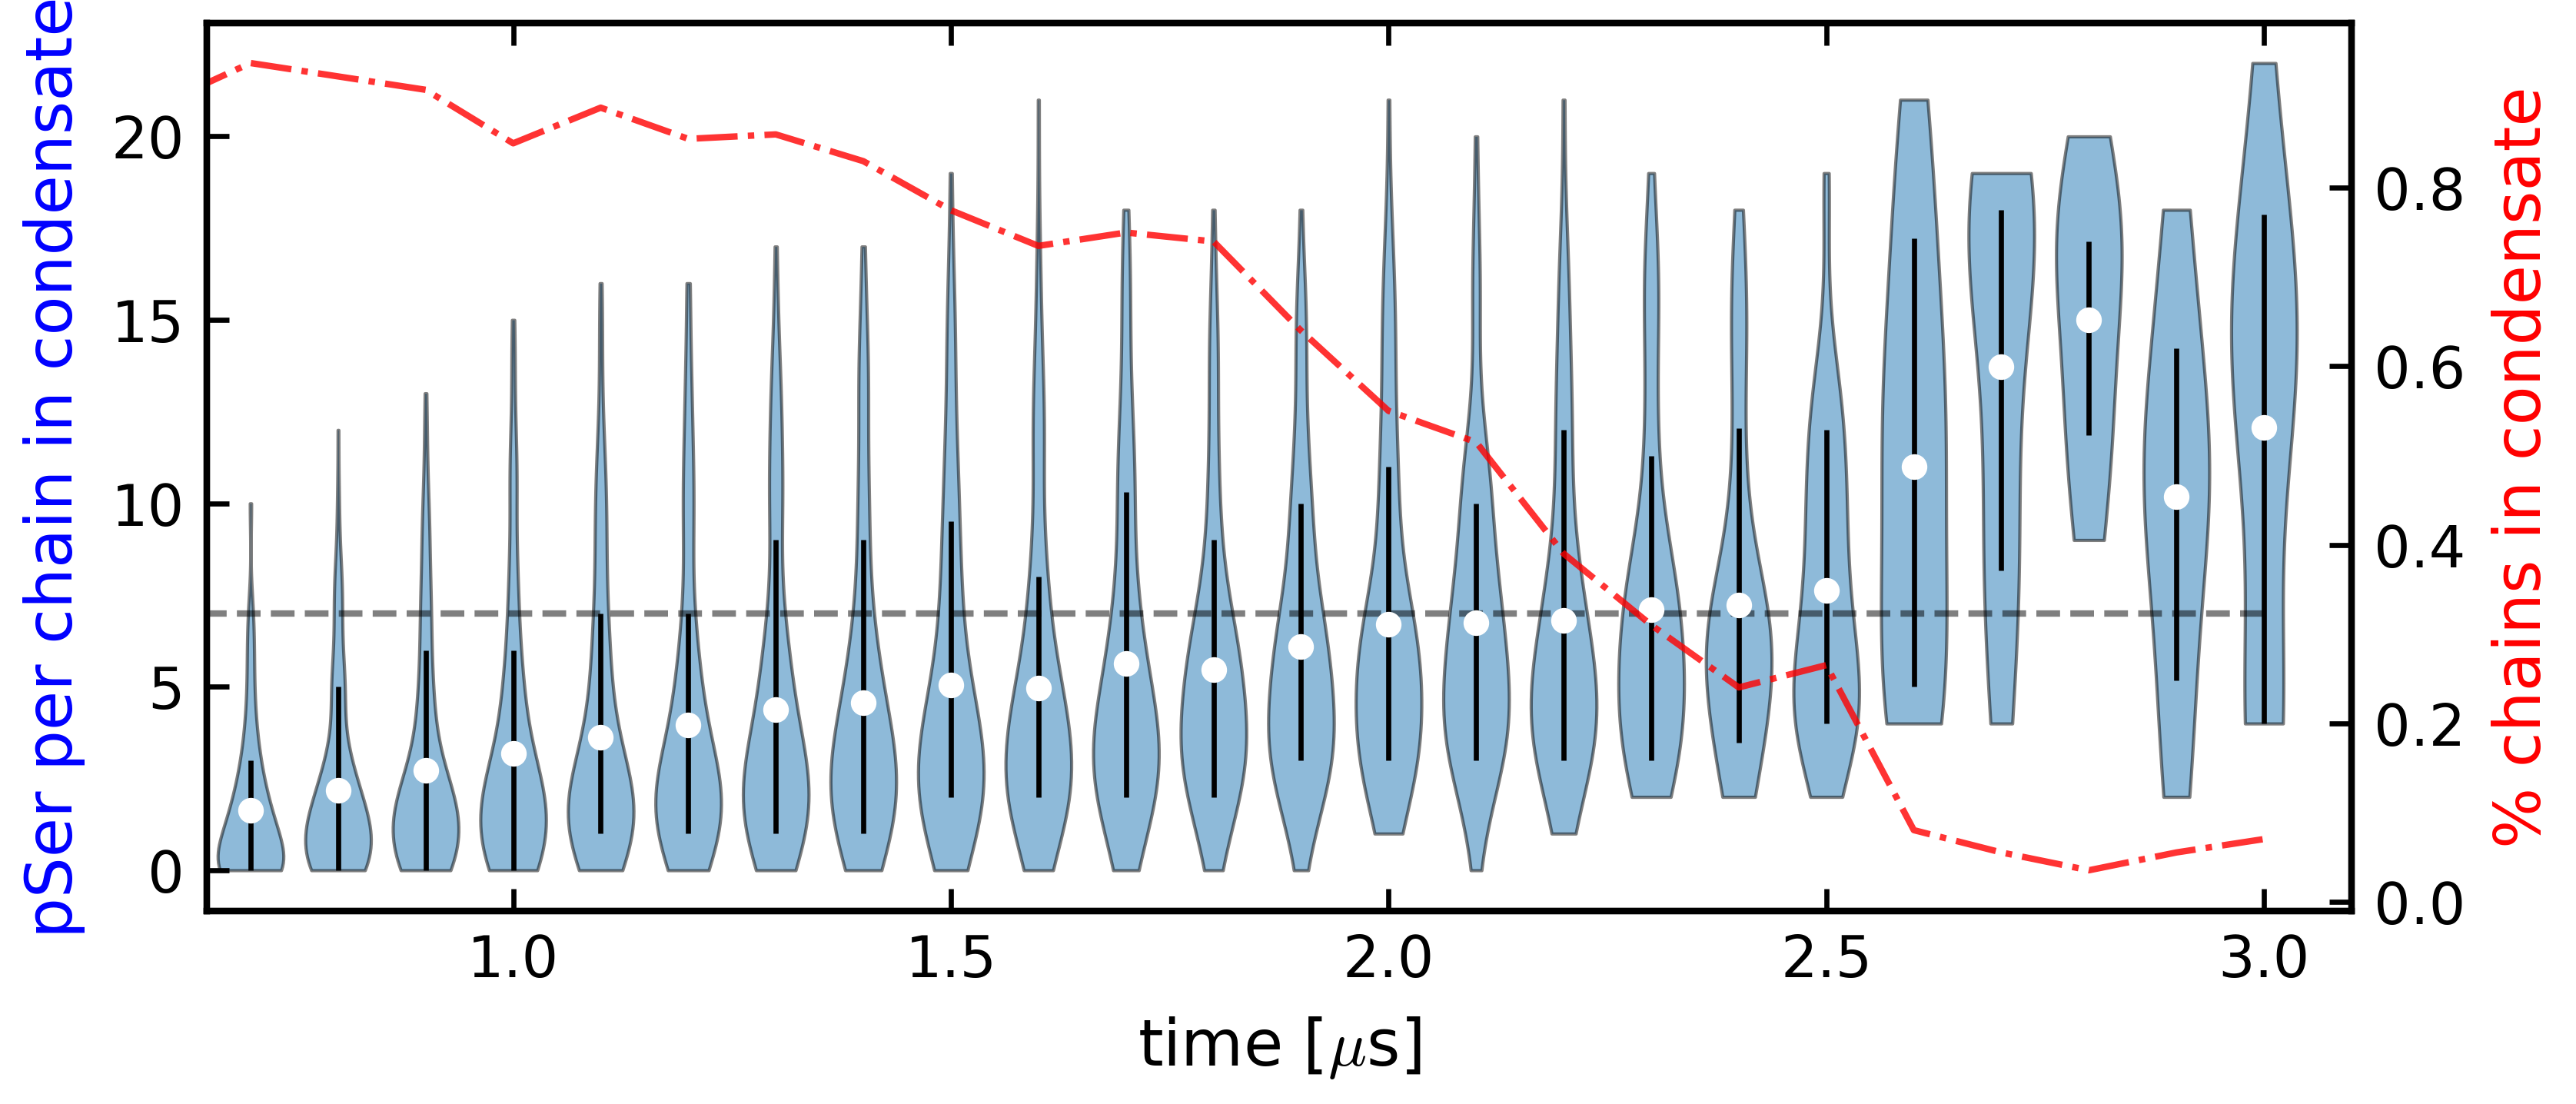

In [47]:
time_step_dis = times_dis*200000

def adjacent_values(vals, q1, q3):
    upper_adjacent_value = q3 + (q3 - q1) * 1.5
    upper_adjacent_value = np.clip(upper_adjacent_value, q3, vals[-1])

    lower_adjacent_value = q1 - (q3 - q1) * 1.5
    lower_adjacent_value = np.clip(lower_adjacent_value, vals[0], q1)
    return lower_adjacent_value, upper_adjacent_value

fig, ax1 = plt.subplots(figsize=(6, 2.5))
 
# Plot the first array with the primary y-axis
data = npcond_5ck1d_list # [5::2]
parts = ax1.violinplot(
        data, widths=0.75, 
        showmeans=False, showmedians=False, showextrema=False)

for pc in parts['bodies']:
    pc.set_facecolor('tab:blue')
    pc.set_edgecolor('black')
    pc.set_alpha(0.5)
    pc.set_lw(0.5)

percentile1 = [ np.percentile(data[i], 15.9) for i in range(len(data)) ]
percentile3 = [ np.percentile(data[i], 84.1) for i in range(len(data)) ]

inds = np.arange(1, len(data)+1)
ax1.vlines(inds, percentile1, percentile3, color='k', linestyle='-', lw=0.8)
ax1.scatter(inds, npcond_5ck1d, marker='o', color='white', zorder=3)
ax1.plot(inds, inds*0+7, ls='--', c='k', alpha=0.5)

ax1.set_xlabel('time [$\mu$s]')
ax1.set_ylabel('pSer per chain in condensate', color='b')
ax1.set_xticks(np.array([5,10,15,20,25,30])+1, np.array([5,10,15,20,25,30])*tstep*2/1e3)

# Create a secondary y-axis and plot the second array
ax2 = ax1.twinx()
ax2.plot(inds, nchainscond_5ck1d/200, 'r-.', alpha=0.8)
ax2.set_ylabel('% chains in condensate', color='r')

plt.xlim(7.5,32)
#plt.title(r'$N_{pSer}$(t>1.8$\mu$s)='+f'{np.mean(npcond_5ck1d[-13:]):.1f}({np.std(npcond_5ck1d[-13:])*10:.0f})', fontsize=10)
filename=path_drop_pl+'npser_per_chain_condensate_200-tdp43-lcd_5-ck1d-open'
plt.savefig(filename+'.png', dpi=600)
plt.savefig(filename+'.pdf', dpi=600)


/tmp/ipykernel_2175565/1407272229.py:11: RuntimeWarning: divide by zero encountered in divide
  ax2.plot(cc[1][2:-3]+0.5, cc[0][2:-2]/cd[0][2:-2], 'r-.')


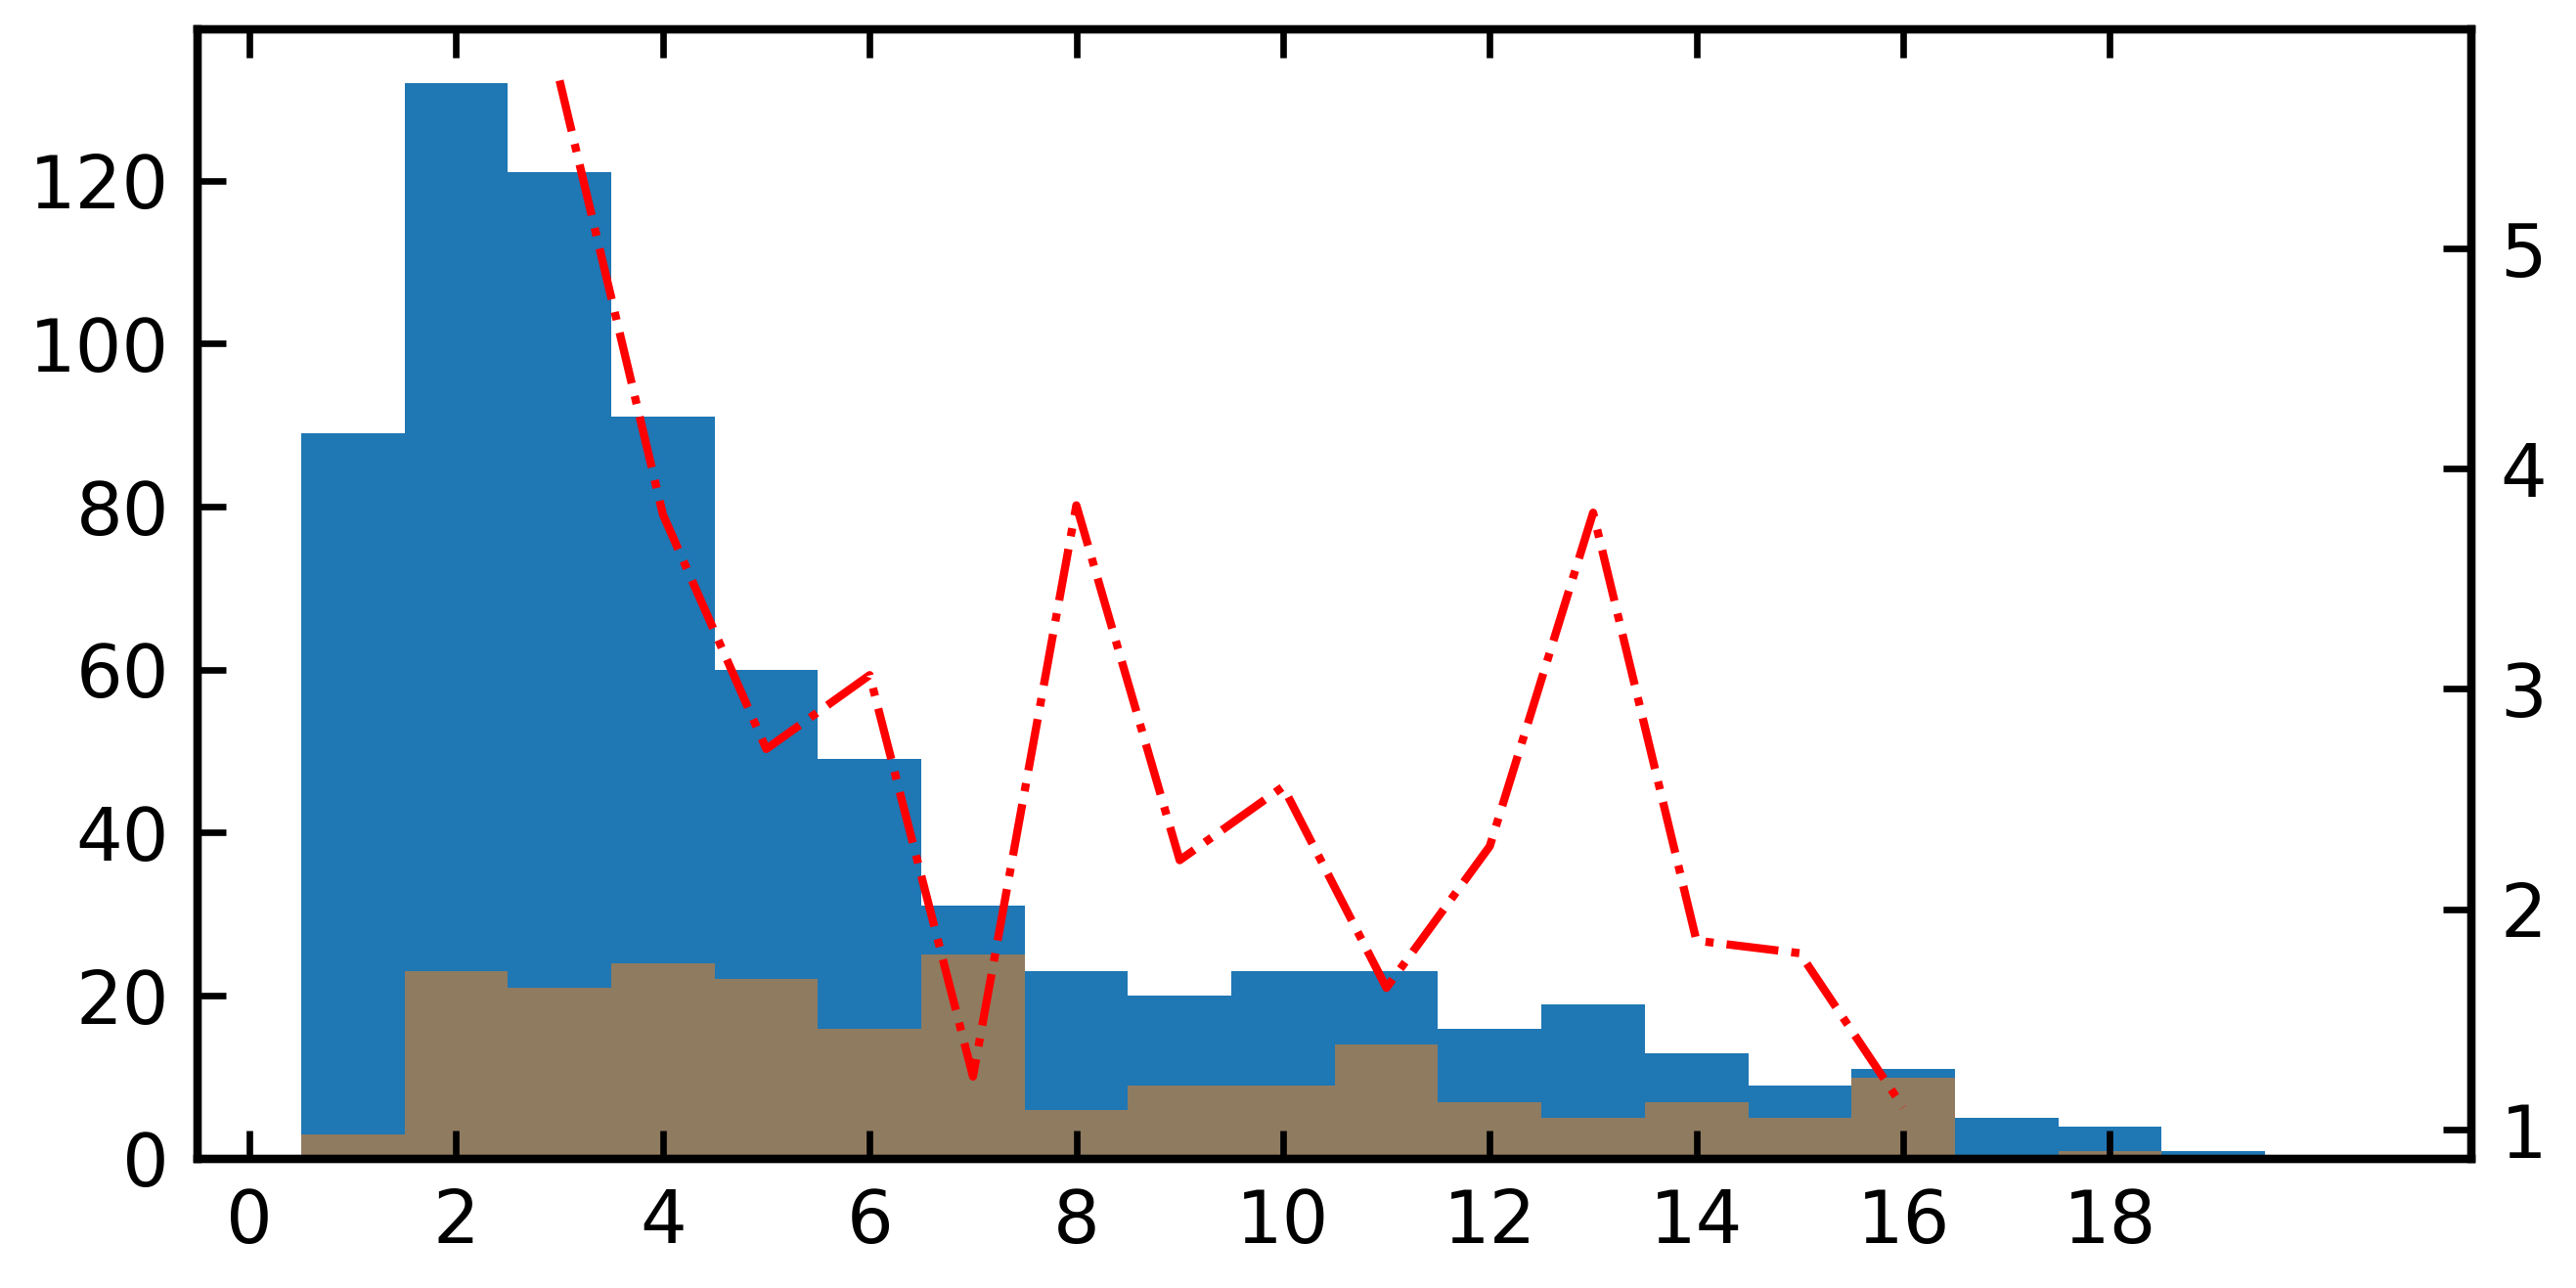

In [74]:
counts_d = np.concatenate(npdil_5ck1d_list[13:-13])
counts_c = np.concatenate(npcond_5ck1d_list[13:-13])

f,ax = plt.subplots(figsize=(5,2.5))

cc = ax.hist(counts_c, bins=np.arange(0,np.max(counts_c))+0.5 )
cd = ax.hist(counts_d, bins=np.arange(0,np.max(counts_d))+0.5 , alpha=0.5)
ax.set_xticks(np.arange(0,20,2), np.arange(0,20,2))

ax2 = ax.twinx()
ax2.plot(cc[1][2:-3]+0.5, cc[0][2:-2]/cd[0][2:-2], 'r-.')


plt.show()

## Orientation

### Slab

In [24]:
filename = path_struct+'sim_eq_400-tdp43-lcd_slab/sim_eq_400-tdp43-lcd-2301pser_CAL3_slab_dump_centered.gsd'


In [25]:
edges = np.concatenate([
    np.linspace(0, 10, 50),      # fine in condensate
    np.linspace(10, 25, 120),      # finer near interface
    np.linspace(25, 75, 30)      # coarser far away
])


hpau.compute_P2_profile(filename, n_bins_orient=edges, n_bins_density=200, density_threshold=0.5, 
                   mode="distance", save=path_struct_an+"P2_vs_distance_400-tdp43-lcd-2301pser.dat")

100%|█████████████████████████████████████████████████████████████████| 500/500 [03:28<00:00,  2.40it/s]


(array([ 0.10204082,  0.30612245,  0.51020408,  0.71428571,  0.91836735,
         1.12244898,  1.32653061,  1.53061224,  1.73469388,  1.93877551,
         2.14285714,  2.34693878,  2.55102041,  2.75510204,  2.95918367,
         3.16326531,  3.36734694,  3.57142857,  3.7755102 ,  3.97959184,
         4.18367347,  4.3877551 ,  4.59183673,  4.79591837,  5.        ,
         5.20408163,  5.40816327,  5.6122449 ,  5.81632653,  6.02040816,
         6.2244898 ,  6.42857143,  6.63265306,  6.83673469,  7.04081633,
         7.24489796,  7.44897959,  7.65306122,  7.85714286,  8.06122449,
         8.26530612,  8.46938776,  8.67346939,  8.87755102,  9.08163265,
         9.28571429,  9.48979592,  9.69387755,  9.89795918, 10.        ,
        10.06302521, 10.18907563, 10.31512605, 10.44117647, 10.56722689,
        10.69327731, 10.81932773, 10.94537815, 11.07142857, 11.19747899,
        11.32352941, 11.44957983, 11.57563025, 11.70168067, 11.82773109,
        11.95378151, 12.07983193, 12.20588235, 12.3

In [19]:
traj = gsd.hoomd.open(filename, 'r')
n_bins_density = 200      # bins to find interface
n_bins_orient = 100       # bins for P2(d)

first_frame = traj[0]
box_Lz = first_frame.configuration.box[2]

d_max = box_Lz / 2
d_edges = np.linspace(0, d_max, n_bins_orient + 1)

p2_total = np.zeros(n_bins_orient)
counts_total = np.zeros(n_bins_orient)

for frame in tqdm(traj):
    pos = frame.particles.position.copy()
    pos -= box_Lz * np.rint(pos[:, 2:3] / box_Lz) * np.array([0,0,1])  # unwrap z PBC

    z = pos[:, 2]
    z_centers, density = hpau.compute_density_profile_per_frame(z, box_Lz, n_bins_density)
    z_bottom, z_top = hpau.find_interfaces(z_centers, density)

    bonds = frame.bonds.group

    p2_sum, counts = hpau.p2_from_bonds(pos, bonds, box_Lz, z_bottom, z_top, d_edges)
    p2_total += p2_sum
    counts_total += counts

# Final average
P2_profile = np.divide(p2_total, counts_total, where=counts_total > 0)
d_centers = 0.5 * (d_edges[:-1] + d_edges[1:])


 23%|███████████████▏                                                 | 117/500 [00:48<02:39,  2.40it/s]


KeyboardInterrupt: 

In [14]:
pt_struct_an= '/localscratch/zippoema/project_ness/analysis/condensate_structure'
np.savetxt(pt_struct_an+"P2_vs_distance_400-tdp43-lcd.dat", np.column_stack([d_centers, P2_profile]),
           header="distance_from_interface  P2")


In [26]:
bin_centers, density = hpau.compute_density_profile(filename, axis=2, nbins=200, therm=100)

/localscratch/zippoema/lib/python_envs/hpa_env/lib/python3.11/site-packages/gsd/hoomd.py:1125: FutureWarning: The 'rb' mode is deprecated, use 'r'
  gsdfileobj = fl.open(name=str(name),


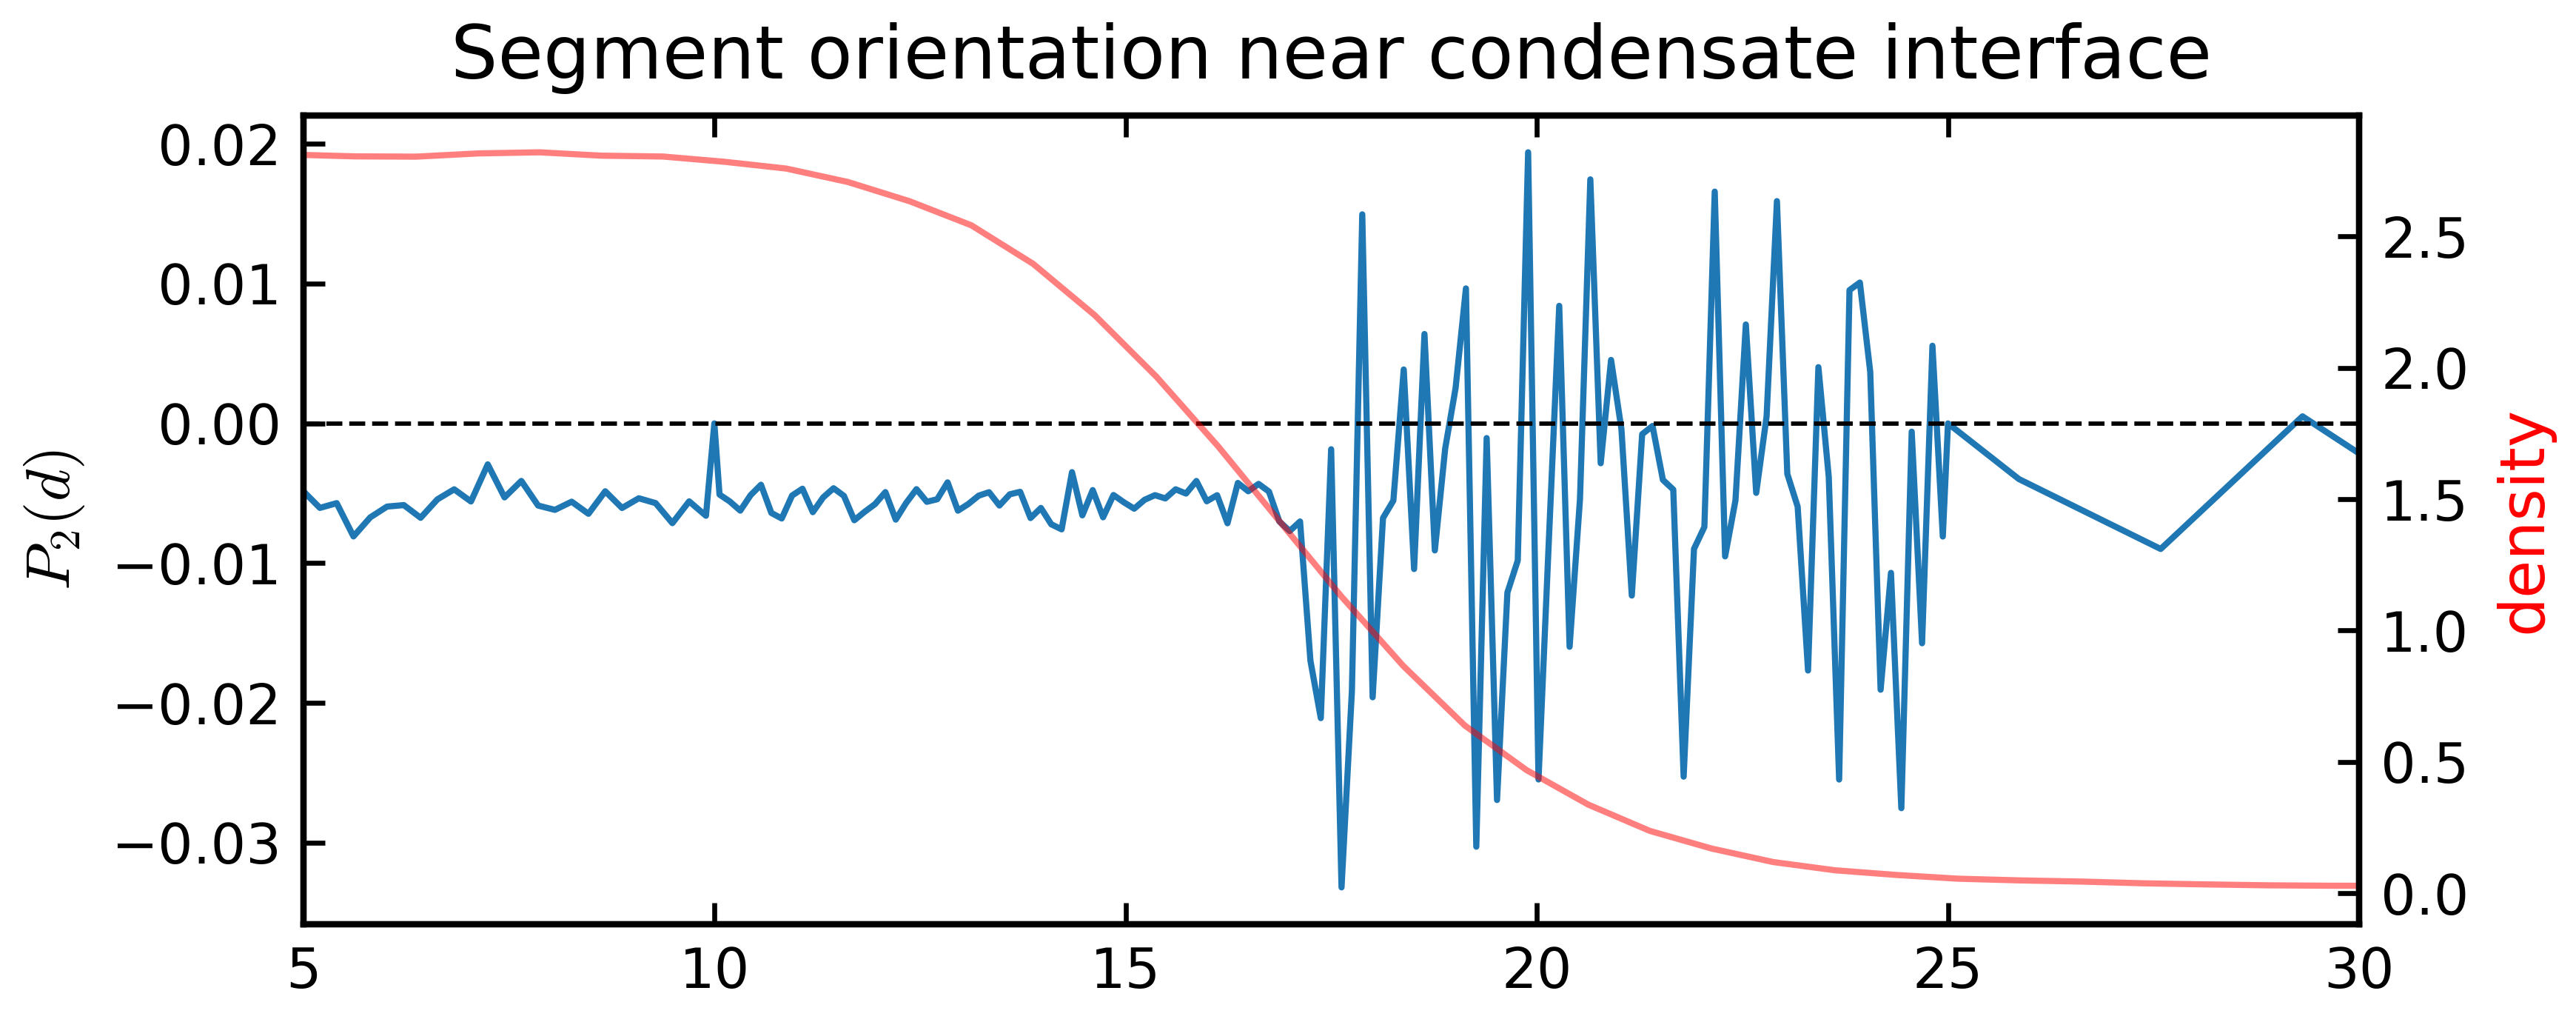

In [27]:
data = np.loadtxt(path_struct_an+"P2_vs_distance_400-tdp43-lcd-2301pser.dat")
d = data[:, 0]
P2 = data[:, 1]

f, ax = plt.subplots(figsize=(6, 2.5))
ax.plot(d, P2)
ax1 = ax.twinx()
ax1.plot(bin_centers, density, '-r', alpha=0.5)
ax.axhline(0, linestyle='--', lw=0.7, color='k')
plt.xlabel("Distance from interface")
ax.set_ylabel(r"$P_2(d)$")
ax1.set_ylabel(r"density", color='r')
plt.title("Segment orientation near condensate interface")
plt.tight_layout()
ax.set_xlim(5,30)

filename = '/localscratch/zippoema/project_ness/plots/condensate_structure/P2_vs_distance_400-tdp43-lcd-2301pser'
plt.savefig(filename+'.png', dpi=600)
plt.savefig(filename+'.pdf', dpi=600)
